# Business Report Analysis PT ABC International (toko.com)
- toko.com is fictional online shop platform developed by ABC International fictional FMCG as well, however the data used in this data analysis is relevant for Business Performance Analysis
- the data used in this analysis is a real case but has been processed in such a way to protect company confidentiality

###  This report was prepared as 
#### a. Business Performance Monitoring (Metrices: GMV, AOV, ARPU, RPR, RR, Growth Rate YTD & MTM)
1. **GMV:  Gross Merchandise Volume:** total value of all goods or services have been sold through toko.com
2. **AOV:  Average Order Value:**             the average of monetary value of each order from toko.com
3. **ARPU: Average Revenue per User:** the average revenue generated by toko.com from each users
4. **RPR:  Repeat Purchase Rate:**          the percentage of customers who made more than one purchase from toko.com over a specific period
5. **RR:   Retention Rate:**                        The indicator of customer loyalty and reflects the ability of toko.com to retain its existing customer base
6. **Growth Rate YTD: year-to-date:**      the percentage of sales increase/decrease from the beginning year to the current date
7. **Growth Rate MTM: month-to-month:** the percentage of sales increas/decreasee from the end of the previous month to the end of the current month

#### b. Diagnose whether there is a false leveling of sales agent due to their purchase behavior as business partner. (Machine Learning Methods DBSCAN : _Density-Based Spatial Clustering of Applications with Noise_)
- Due to we have 5 level sales agent, it should be that we have 5 cluster based on purchase behavior, but we have assumption that some sales agent didn't perform a business performance as their contract with company

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings("ignore", message="A NumPy version.*")

In [2]:
def custom_format(x):
  return locale.format_string('%0.1f', x, grouping=True)
pd.set_option('display.float_format', custom_format)

In [3]:
def billions_formatter(x, pos):
  return f'{x / 1e9:.1f}B'
def millions_formater(x,pos):
  return f'{x / 1e6:.1f}M'
def percent_formatter(x, pos):
  return f'{x:.0f}%'

## A. Set Function for Data Inspecting

In [4]:
# function to check data frame and the dimension
def inspect_data(df,col=None,n_rows=5):
    '''
    function to inspect how many rows & columns, and what the columns are the data had
    parameter:
    df     : pandas.DataFrame : dataset to be inspected
    col    : str : column name to be checked
    n_rows : int : number of rows to be displayed
    '''
    # check data shape
    print(f'data shape: {df.shape}')

    # define col to be inspected
    if col is None:
        col = df.columns

    # display head data as dataframe
    display(df[col].head(n_rows))

In [5]:
# function to check missing values
def check_missing(df,cut_off=0,sort=True):
    '''
    function to detect missing value in data set. the number, percentage of missing value in each columns,
    type and unique value of the columns

    Parameter:
    df:     : pandas.DataFrame : dataset to be checked
    cut_off : float : lower limit percentage of rows that having missing value to be displayed
    sort    : bool (True/False) : define whether sorting is needed or not needed
    '''
    freq = df.isnull().sum()
    percent = 100*df.isnull().sum()/df.shape[0]
    types = df.dtypes
    unique = df.apply(pd.unique)
    df_miss = pd.DataFrame({'missing_frequency':freq,'missing_percentage':percent,'type':types,'unique_value':unique})
    if sort: df_miss.sort_values(by='missing_percentage',ascending=False,inplace=True)
    return df_miss[df_miss['missing_percentage']>=cut_off]

In [6]:
# function to fill in the NaN
def fillna_by_metric(df,column,metric='mean',custom_value=None):
    '''
    function to fill the missing value by certain metric (mean, median, mode, zero, custom value)

    parameter:
    df           : pandas.DataFrame :
    column       : str : column name with missing value will be filled in
    metric       : str : choose the metric which will be used to fill in the missing value
                        (mean, median, mode, zero, custom)
    custom_value : str : it will be used when parameter:metric use "custom", this parameter could use "other", stc
    '''
    # define the metric that will be used to fill in the missing value
    if metric=='mean':
        metric_value = df[column].mean()
    elif metric=='median':
        metric_value = df[column].median()
    elif metric=='mode':
        metric_value = df[column].mode()
    elif metric=='zero':
        metric_value = 0
    elif metric=='custom':
        metric_value = custom_value

    # filling in the missing value
    df[column].fillna(value=metric_value,inplace=True)

    return df

## B. Set Function for Data Analysis Process

In [7]:
# Monthly GMV Dataset by condition
def dataset_monthly_amount_by_condition(df,col_condition=None,condition=None):
    '''
    function to set new data frame which is used in monthly report

    parameter:
    df : pandas.DataFrame
    col_condition : str : select column which is having condition to arrange new dataset for report (None = all columns)
    condition  : str : unique value in col_condition which is considered as condition in arrangement new dataset
    '''
    if col_condition is None:
        if condition is None:
            df_filtered = df[df.columns]
    else:
        df_filtered = df[df[col_condition].isin([condition])]

# monthly growth percentage
    # aggregate sales monthly
    df_filtered_monthly = df_filtered.resample('M', on='barcode_date')['amount'].sum().reset_index()
    df_filtered_monthly['month'] = df_filtered_monthly['barcode_date'].dt.strftime('%b')
    df_filtered_monthly['year'] = df_filtered_monthly['barcode_date'].dt.year
    df_filtered_monthly['month_year'] = df_filtered_monthly['month']+'-'+df_filtered_monthly['year'].astype(str)

    # Year-to-Date
    df_filtered_monthly['amount_ytd'] = 0
    for i, row in df_filtered_monthly.iterrows():
        current_month = row['barcode_date'].month
        if current_month == 1:
            df_filtered_monthly.at[i, 'amount_ytd'] = row['amount']
        else:
            prev_row = df_filtered_monthly.iloc[i - 1]
            df_filtered_monthly.at[i, 'amount_ytd'] = prev_row['amount_ytd'] + row['amount']

    # calculate percentage growth
    df_filtered_monthly['amount_percent_growth_mtm'] = (df_filtered_monthly['amount'].pct_change() * 100).fillna(0)
    df_filtered_monthly['amount_percent_growth_ytd'] = (df_filtered_monthly['amount_ytd'].pct_change(periods=12)*100).fillna(0)

    # select last 25 row
    df_filtered_monthly_25 = df_filtered_monthly.tail(25).reset_index()
    df_filtered_monthly_25.to_excel(f'df_{condition}_amount_monthly.xlsx',index=False)
    
    return df_filtered_monthly_25

In [8]:
# Monthly Quantity Sales Dataset by Condition
def dataset_monthly_quantity_by_condition(df,col_condition=None,condition=None):
    '''
    function to set new data frame which is used in monthly report

    parameter:
    df : pandas.DataFrame
    col_condition : str : select column which is having condition to arrange new dataset for report (None = all columns)
    condition  : str : unique value in col_condition which is considered as condition in arrangement new dataset
    '''
    if col_condition is None:
        if condition is None:
            df_filtered = df[df.columns]
    else:
        df_filtered = df[df[col_condition].isin([condition])]

# monthly growth percentage
    # aggregate sales monthly
    df_filtered_monthly = df_filtered.resample('M', on='barcode_date')['quantity'].sum().reset_index()
    df_filtered_monthly['month'] = df_filtered_monthly['barcode_date'].dt.strftime('%b')
    df_filtered_monthly['year'] = df_filtered_monthly['barcode_date'].dt.year
    df_filtered_monthly['month_year'] = df_filtered_monthly['month']+'-'+df_filtered_monthly['year'].astype(str)

    # Year-to-Date
    df_filtered_monthly['quantity_ytd'] = 0
    for i, row in df_filtered_monthly.iterrows():
        current_month = row['barcode_date'].month
        if current_month == 1:
            df_filtered_monthly.at[i, 'quantity_ytd'] = row['quantity']
        else:
            prev_row = df_filtered_monthly.iloc[i - 1]
            df_filtered_monthly.at[i, 'quantity_ytd'] = prev_row['quantity_ytd'] + row['quantity']

    # calculate percentage growth
    df_filtered_monthly['quantity_percent_growth_mtm'] = (df_filtered_monthly['quantity'].pct_change() * 100).fillna(0)
    df_filtered_monthly['quantity_percent_growth_ytd'] = (df_filtered_monthly['quantity_ytd'].pct_change(periods=12)*100).fillna(0)

    # select last 25 row
    df_filtered_monthly_25 = df_filtered_monthly.tail(25).reset_index()
    df_filtered_monthly_25.to_csv(f'df_{condition}_quantity_monthly.csv',index=False)
    
    return df_filtered_monthly_25

In [9]:
# Quarterly GMV Sales Dataset by Condition
def dataset_quarterly_amount_by_condition(df,col_condition=None,condition=None):
    '''
    function to set new data frame which is used in monthly report

    parameter:
    df : pandas.DataFrame
    col_condition : str : select column which is having condition to arrange new dataset for report (None = all columns)
    condition  : str : unique value in col_condition which is considered as condition in arrangement new dataset
    '''
    if col_condition is None:
        if condition is None:
            df_filtered = df[df.columns]
    else:
        df_filtered = df[df[col_condition].isin([condition])]

# quarterly growth percentage
    # aggregate sales quarterly
    df_filtered_quarterly = df_filtered.resample('Q', on='barcode_date')['amount'].sum().reset_index()
    df_filtered_quarterly['quarter'] = 'q'+df_filtered_quarterly['barcode_date'].dt.quarter.astype(str)
    df_filtered_quarterly['year'] = df_filtered_quarterly['barcode_date'].dt.year
    df_filtered_quarterly['quarter_year'] = df_filtered_quarterly['quarter']+'-'+df_filtered_quarterly['year'].astype(str)

    # percentage growth
    df_filtered_quarterly['amount_percent_growth_qtq'] = (df_filtered_quarterly['amount'].pct_change() * 100).fillna(0)
    df_filtered_quarterly['amount_percent_growth_lyq'] = (df_filtered_quarterly['amount'].pct_change(periods=4)*100).fillna(0)

    # select last 13 row
    df_filtered_quarterly_13 = df_filtered_quarterly.tail(13).reset_index()
    df_filtered_quarterly_13.to_csv(f'df_{condition}_amount_quarterly.csv',index=False)
    
    return df_filtered_quarterly_13

In [10]:
# Quarterly Quantity Sales Dataset by Condition
def dataset_quarterly_quantity_by_condition(df,col_condition=None,condition=None):
    '''
    function to set new data frame which is used in monthly report

    parameter:
    df : pandas.DataFrame
    col_condition : str : select column which is having condition to arrange new dataset for report (None = all columns)
    condition  : str : unique value in col_condition which is considered as condition in arrangement new dataset
    '''
    if col_condition is None:
        if condition is None:
            df_filtered = df[df.columns]
    else:
        df_filtered = df[df[col_condition].isin([condition])]

# quarterly growth percentage
    # aggregate sales quarterly
    df_filtered_quarterly = df_filtered.resample('Q', on='barcode_date')['quantity'].sum().reset_index()
    df_filtered_quarterly['quarter'] = 'q'+df_filtered_quarterly['barcode_date'].dt.quarter.astype(str)
    df_filtered_quarterly['year'] = df_filtered_quarterly['barcode_date'].dt.year
    df_filtered_quarterly['quarter_year'] = df_filtered_quarterly['quarter']+'-'+df_filtered_quarterly['year'].astype(str)

    # percentage growth
    df_filtered_quarterly['quantity_percent_growth_qtq'] = (df_filtered_quarterly['quantity'].pct_change() * 100).fillna(0)
    df_filtered_quarterly['quantity_percent_growth_lyq'] = (df_filtered_quarterly['quantity'].pct_change(periods=4)*100).fillna(0)

    # select last 13 row
    df_filtered_quarterly_13 = df_filtered_quarterly.tail(13).reset_index()
    df_filtered_quarterly_13.to_csv(f'df_{condition}_quantity_quarterly.csv',index=False)
    
    return df_filtered_quarterly_13

In [11]:
# Function for Monthly GMV Chart by condition
def chart_monthly_amount_by_condition(df,bar_color,line_1_color,line_2_color,background_color,col_condition=None,condition=None):
    '''
    function to set new data frame which is used in monthly report

    parameter:
    df : pandas.DataFrame
    bar_color  : str : define color for bar chart
    line_1_color : str : define color for line 1 growth chart (darker)
    line_2_color : str : define color for line 2 growth chart (lighter)
    background_color : str : define color for background
    col_condition : str : select column which is having condition to arrange new dataset for report (None = all columns)
    condition  : str : unique value in col_condition which is considered as condition in arrangement new dataset
    '''
    if col_condition is None:
        if condition is None:
            df_filtered = df[df.columns]
    else:
        df_filtered = df[df[col_condition].isin([condition])]

# monthly growth percentage
    # aggregate sales monthly
    df_filtered_monthly = df_filtered.resample('M', on='barcode_date')['amount'].sum().reset_index()
    df_filtered_monthly['month'] = df_filtered_monthly['barcode_date'].dt.strftime('%b')
    df_filtered_monthly['year'] = df_filtered_monthly['barcode_date'].dt.year
    df_filtered_monthly['month_year'] = df_filtered_monthly['month']+'-'+df_filtered_monthly['year'].astype(str)

    # Year-to-Date
    df_filtered_monthly['amount_ytd'] = 0
    for i, row in df_filtered_monthly.iterrows():
        current_month = row['barcode_date'].month
        if current_month == 1:
            df_filtered_monthly.at[i, 'amount_ytd'] = row['amount']
        else:
            prev_row = df_filtered_monthly.iloc[i - 1]
            df_filtered_monthly.at[i, 'amount_ytd'] = prev_row['amount_ytd'] + row['amount']

    # calculate percentage growth
    df_filtered_monthly['amount_percent_growth_mtm'] = (df_filtered_monthly['amount'].pct_change() * 100).fillna(0)
    df_filtered_monthly['amount_percent_growth_ytd'] = (df_filtered_monthly['amount_ytd'].pct_change(periods=12)*100).fillna(0)

    # select last 25 row
    df_filtered_monthly_25 = df_filtered_monthly.tail(25).reset_index()

# Monthly chart
    # Create a figure and axis for the bar chart
    plt.figure(figsize=(12,6))
    # bar chart
    ax1 = sns.barplot(data=df_filtered_monthly_25,x='month_year',y='amount',color=bar_color)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45,ha='right')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Amount Sales')
    ax1.yaxis.set_major_formatter(FuncFormatter(millions_formater))
    ax1.yaxis.grid(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.set_facecolor(background_color)

    # line chart
    ax2=ax1.twinx()
    ax2.plot(df_filtered_monthly_25['month_year'],df_filtered_monthly_25['amount_percent_growth_mtm'],
             color=line_2_color,label='Growth MTM',dashes=[1,2])
    ax2.plot(df_filtered_monthly_25['month_year'],df_filtered_monthly_25['amount_percent_growth_ytd'],
             color=line_1_color, label='Growth YTD',dashes=[6,2])
    ax2.axhline(0, color='#F75984', linestyle='--', linewidth=1.5, label='Zero Growth')  # zero growth line
    ax2.set_ylabel('Sales Growth')
    ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    ax2.yaxis.grid(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.legend(loc='upper left')

    # atributes data value label
    label_indices = [0, 4, 10, 12, 15, 20, 23, 24]
    # bar chart
    for i, mon in enumerate(df_filtered_monthly_25['month_year']):
        if i in label_indices:
            ax1.annotate(f'{df_filtered_monthly_25["amount"].iloc[i]/1e6:,.1f}M',
                         (i,df_filtered_monthly_25["amount"].iloc[i]),
                         textcoords="offset points", xytext=(0,10), ha='center')
    plt.title(f'Monthly Sales Amount vs Percentage Growth\nSKU {condition}')
    # line chart
    for i, (x, y1, y2) in enumerate(zip(df_filtered_monthly_25['month_year'],
                                        df_filtered_monthly_25['amount_percent_growth_mtm'],
                                        df_filtered_monthly_25['amount_percent_growth_ytd'])):
        if i in label_indices:
            ax2.annotate(f'{y1:.1f}%', (x, y1), textcoords="offset points", xytext=(0,0), ha='center', color=line_2_color)
            ax2.annotate(f'{y2:.1f}%', (x, y2), textcoords="offset points", xytext=(0,-10), ha='center', color=line_1_color)
    plt.savefig(f'monthly_sales_SKU_{condition} {df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}.png')
    plt.show()

In [12]:
# Function for Monthly Quantity Sales Chart by Condition
def chart_monthly_quantity_by_condition(df,bar_color,line_1_color,line_2_color,background_color,col_condition=None,condition=None):
    '''
    function to set new data frame which is used in monthly report

    parameter:
    df : pandas.DataFrame
    bar_color  : str : define color for bar chart
    line_1_color : str : define color for line 1 growth chart (darker)
    line_2_color : str : define color for line 2 growth chart (lighter)
    background_color : str : define color for background
    col_condition : str : select column which is having condition to arrange new dataset for report (None = all columns)
    condition  : str : unique value in col_condition which is considered as condition in arrangement new dataset
    '''
    if col_condition is None:
        if condition is None:
            df_filtered = df[df.columns]
    else:
        df_filtered = df[df[col_condition].isin([condition])]

# monthly growth percentage
    # aggregate sales monthly
    df_filtered_monthly = df_filtered.resample('M', on='barcode_date')['quantity'].sum().reset_index()
    df_filtered_monthly['month'] = df_filtered_monthly['barcode_date'].dt.strftime('%b')
    df_filtered_monthly['year'] = df_filtered_monthly['barcode_date'].dt.year
    df_filtered_monthly['month_year'] = df_filtered_monthly['month']+'-'+df_filtered_monthly['year'].astype(str)

    # Year-to-Date
    df_filtered_monthly['quantity_ytd'] = 0
    for i, row in df_filtered_monthly.iterrows():
        current_month = row['barcode_date'].month
        if current_month == 1:
            df_filtered_monthly.at[i, 'quantity_ytd'] = row['quantity']
        else:
            prev_row = df_filtered_monthly.iloc[i - 1]
            df_filtered_monthly.at[i, 'quantity_ytd'] = prev_row['quantity_ytd'] + row['quantity']

    # calculate percentage growth
    df_filtered_monthly['quantity_percent_growth_mtm'] = (df_filtered_monthly['quantity'].pct_change() * 100).fillna(0)
    df_filtered_monthly['quantity_percent_growth_ytd'] = (df_filtered_monthly['quantity_ytd'].pct_change(periods=12)*100).fillna(0)

    # select last 25 row
    df_filtered_monthly_25 = df_filtered_monthly.tail(25).reset_index()

# Monthly chart
    # Create a figure and axis for the bar chart
    plt.figure(figsize=(12,6))
    # bar chart
    ax1 = sns.barplot(data=df_filtered_monthly_25,x='month_year',y='quantity',color=bar_color)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45,ha='right')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Quantity Sales (in pcs)')
    ax1.yaxis.grid(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.set_facecolor(background_color)

    # line chart
    ax2=ax1.twinx()
    ax2.plot(df_filtered_monthly_25['month_year'],df_filtered_monthly_25['quantity_percent_growth_mtm'],
             color=line_2_color,label='Growth MTM',dashes=[1,2])
    ax2.plot(df_filtered_monthly_25['month_year'],df_filtered_monthly_25['quantity_percent_growth_ytd'],
             color=line_1_color, label='Growth YTD',dashes=[6,2])
    ax2.axhline(0, color='#F75984', linestyle='--', linewidth=1.5, label='Zero Growth')  # zero growth line
    ax2.set_ylabel('Sales Growth')
    ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    ax2.yaxis.grid(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.legend(loc='upper left')

    # atributes data value label
    label_indices = [0, 4, 10, 12, 15, 20, 23, 24]
    # bar chart
    for i, mon in enumerate(df_filtered_monthly_25['month_year']):
        if i in label_indices:
            ax1.annotate(df_filtered_monthly_25["quantity"].iloc[i],
                         (i,df_filtered_monthly_25["quantity"].iloc[i]),
                         textcoords="offset points", xytext=(0,10), ha='center')
    plt.title(f'Monthly Sales Quantity vs Percentage Growth\nSKU {condition}')
    # line chart
    for i, (x, y1, y2) in enumerate(zip(df_filtered_monthly_25['month_year'],
                                        df_filtered_monthly_25['quantity_percent_growth_mtm'],
                                        df_filtered_monthly_25['quantity_percent_growth_ytd'])):
        if i in label_indices:
            ax2.annotate(f'{y1:.1f}%', (x, y1), textcoords="offset points", xytext=(0,10), ha='center', color=line_2_color)
            ax2.annotate(f'{y2:.1f}%', (x, y2), textcoords="offset points", xytext=(0,10), ha='center', color=line_1_color)
    plt.savefig(f'monthly_quantity_SKU_{condition} {df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}.png')
    plt.show()

In [13]:
# Function for Quarterly GMV Sales Chart by Condition
def chart_quarterly_amount_by_condition(df,bar_color,line_1_color,line_2_color,background_color,col_condition=None,condition=None):
    '''
    function to set new data frame which is used in monthly report

    parameter:
    df : pandas.DataFrame
    bar_color  : str : define color for bar chart
    line_1_color : str : define color for line 1 growth chart (darker)
    line_2_color : str : define color for line 2 growth chart (lighter)
    background_color : str : define color for background
    col_condition : str : select column which is having condition to arrange new dataset for report (None = all columns)
    condition  : str : unique value in col_condition which is considered as condition in arrangement new dataset
    '''
    if col_condition is None:
        if condition is None:
            df_filtered = df[df.columns]
    else:
        df_filtered = df[df[col_condition].isin([condition])]

# quarterly growth percentage
    # aggregate sales quarterly
    df_filtered_quarterly = df_filtered.resample('Q', on='barcode_date')['amount'].sum().reset_index()
    df_filtered_quarterly['quarter'] = 'q'+df_filtered_quarterly['barcode_date'].dt.quarter.astype(str)
    df_filtered_quarterly['year'] = df_filtered_quarterly['barcode_date'].dt.year
    df_filtered_quarterly['quarter_year'] = df_filtered_quarterly['quarter']+'-'+df_filtered_quarterly['year'].astype(str)

    # percentage growth
    df_filtered_quarterly['amount_percent_growth_qtq'] = (df_filtered_quarterly['amount'].pct_change() * 100).fillna(0)
    df_filtered_quarterly['amount_percent_growth_lyq'] = (df_filtered_quarterly['amount'].pct_change(periods=4)*100).fillna(0)

    # select last 13 row
    df_filtered_quarterly_13 = df_filtered_quarterly.tail(13).reset_index()

# Monthly chart
    # Create a figure and axis for the bar chart
    plt.figure(figsize=(6,6))
    # bar chart
    ax1 = sns.barplot(data=df_filtered_quarterly_13,x='quarter_year',y='amount',color=bar_color)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45,ha='right')
    ax1.set_xlabel('Quarter')
    ax1.set_ylabel('Amount Sales')
    ax1.yaxis.set_major_formatter(FuncFormatter(millions_formater))
    ax1.yaxis.grid(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.set_facecolor(background_color)

    # line chart
    ax2=ax1.twinx()
    ax2.plot(df_filtered_quarterly_13['quarter_year'],df_filtered_quarterly_13['amount_percent_growth_qtq'],
             color=line_2_color,label='Growth QTQ',dashes=[1,2])
    ax2.plot(df_filtered_quarterly_13['quarter_year'],df_filtered_quarterly_13['amount_percent_growth_lyq'],
             color=line_1_color, label='Growth vs LY-Quarter',dashes=[6,2])
    ax2.axhline(0, color='#F75984', linestyle='--', linewidth=1.5, label='Zero Growth')  # zero growth line
    ax2.set_ylabel('Sales Growth')
    ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    ax2.yaxis.grid(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.legend(loc='upper left')

    # atributes data value label
    label_indices = [0, 4, 8, 11, 12]
    # bar chart
    for i, mon in enumerate(df_filtered_quarterly_13['quarter_year']):
        if i in label_indices:
            ax1.annotate(f'{df_filtered_quarterly_13["amount"].iloc[i]/1e6:,.1f}M',
                         (i,df_filtered_quarterly_13["amount"].iloc[i]),
                         textcoords="offset points", xytext=(0,10), ha='center')
    plt.title(f'Quarterly Sales Amount vs Percentage Growth\nSKU {condition}')
    # line chart
    for i, (x, y1, y2) in enumerate(zip(df_filtered_quarterly_13['quarter_year'],
                                        df_filtered_quarterly_13['amount_percent_growth_qtq'],
                                        df_filtered_quarterly_13['amount_percent_growth_lyq'])):
        if i in label_indices:
            ax2.annotate(f'{y1:.1f}%', (x, y1), textcoords="offset points", xytext=(0,10), ha='center', color=line_2_color)
            ax2.annotate(f'{y2:.1f}%', (x, y2), textcoords="offset points", xytext=(0,10), ha='center', color=line_1_color)
    plt.savefig(f'quarterly_sales_SKU_{condition} {df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}.png')
    plt.show()

In [14]:
# Function for Quarterly Quantity Sales Chart by Condition
def chart_quarterly_quantity_by_condition(df,bar_color,line_1_color,line_2_color,background_color,col_condition=None,condition=None):
    '''
    function to set new data frame which is used in monthly report

    parameter:
    df : pandas.DataFrame
    bar_color  : str : define color for bar chart
    line_1_color : str : define color for line 1 growth chart (darker)
    line_2_color : str : define color for line 2 growth chart (lighter)
    background_color : str : define color for background
    col_condition : str : select column which is having condition to arrange new dataset for report (None = all columns)
    condition  : str : unique value in col_condition which is considered as condition in arrangement new dataset
    '''
    if col_condition is None:
        if condition is None:
            df_filtered = df[df.columns]
    else:
        df_filtered = df[df[col_condition].isin([condition])]

# quarterly growth percentage
    # aggregate sales quarterly
    df_filtered_quarterly = df_filtered.resample('Q', on='barcode_date')['quantity'].sum().reset_index()
    df_filtered_quarterly['quarter'] = 'q'+df_filtered_quarterly['barcode_date'].dt.quarter.astype(str)
    df_filtered_quarterly['year'] = df_filtered_quarterly['barcode_date'].dt.year
    df_filtered_quarterly['quarter_year'] = df_filtered_quarterly['quarter']+'-'+df_filtered_quarterly['year'].astype(str)

    # percentage growth
    df_filtered_quarterly['quantity_percent_growth_qtq'] = (df_filtered_quarterly['quantity'].pct_change() * 100).fillna(0)
    df_filtered_quarterly['quantity_percent_growth_lyq'] = (df_filtered_quarterly['quantity'].pct_change(periods=4)*100).fillna(0)

    # select last 13 row
    df_filtered_quarterly_13 = df_filtered_quarterly.tail(13).reset_index()

# Monthly chart
    # Create a figure and axis for the bar chart
    plt.figure(figsize=(6,6))
    # bar chart
    ax1 = sns.barplot(data=df_filtered_quarterly_13,x='quarter_year',y='quantity',color=bar_color)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45,ha='right')
    ax1.set_xlabel('Quarter')
    ax1.set_ylabel('Quantity Sales (in pcs)')
    ax1.yaxis.grid(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.set_facecolor(background_color) # Set background color

    # line chart
    ax2=ax1.twinx()
    ax2.plot(df_filtered_quarterly_13['quarter_year'],df_filtered_quarterly_13['quantity_percent_growth_qtq'],
             color=line_2_color,label='Growth QTQ',dashes=[1,2])
    ax2.plot(df_filtered_quarterly_13['quarter_year'],df_filtered_quarterly_13['quantity_percent_growth_lyq'],
             color=line_1_color, label='Growth vs LY-Quarter',dashes=[6,2])
    ax2.axhline(0, color='#F75984', linestyle='--', linewidth=1.5, label='Zero Growth')  # zero growth line
    ax2.set_ylabel('Sales Growth')
    ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    ax2.yaxis.grid(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.legend(loc='upper left')

    # atributes data value label
    label_indices = [0, 4, 8, 11, 12]
    # bar chart
    for i, mon in enumerate(df_filtered_quarterly_13['quarter_year']):
        if i in label_indices:
            ax1.annotate(df_filtered_quarterly_13["quantity"].iloc[i],
                         (i,df_filtered_quarterly_13["quantity"].iloc[i]),
                         textcoords="offset points", xytext=(0,10), ha='center')
    plt.title(f'Quarterly Sales Quantity vs Percentage Growth\nSKU {condition}')
    # line chart
    for i, (x, y1, y2) in enumerate(zip(df_filtered_quarterly_13['quarter_year'],
                                        df_filtered_quarterly_13['quantity_percent_growth_qtq'],
                                        df_filtered_quarterly_13['quantity_percent_growth_lyq'])):
        if i in label_indices:
            ax2.annotate(f'{y1:.1f}%', (x, y1), textcoords="offset points", xytext=(0,10), ha='center', color=line_2_color)
            ax2.annotate(f'{y2:.1f}%', (x, y2), textcoords="offset points", xytext=(0,10), ha='center', color=line_1_color)
    plt.savefig(f'quarterly_quantity_SKU_{condition} {df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}.png')
    plt.show()

## C. Data Preparation

In [15]:
# load data
df_sales = pd.read_csv('data_sales_ABC.csv', low_memory=False, dtype={'invoice': str})
inspect_data(df=df_sales,n_rows=3)

data shape: (67937, 18)


invoice sales_id sales_agent        level distibutor agent reseller  \
0   K1925      116      Anna R     Reseller       HAYA  KRIS      NaN   
1   K1926      121      M Herm  Distributor        NaN   NaN      NaN   
2   K1927       63      HERI S         Agen       HAYA   NaN      NaN   

  customer_email customer_hp cutomer_name barcode_date  subdistrict  district  \
0            NaN         NaN          NaN     2/2/2018      Rungkut  Surabaya   
1            NaN         NaN          NaN     2/2/2018  Balongbendo  Sidoarjo   
2            NaN         NaN          NaN     2/2/2018  Balongbendo  Sidoarjo   

     province          product  box  pack    amount  
0  Jawa Timur  ALGATEA REGULER    2     0 358,750.0  
1  Jawa Timur  ALGATEA REGULER    2     0 315,000.0  
2  Jawa Timur               AK    2     0 332,500.0

In [138]:
df_sales

invoice sales_id sales_agent        level distibutor agent reseller  \
0       K1925      116      Anna R     Reseller       HAYA  KRIS      NaN   
1       K1926      121      M Herm  Distributor        NaN   NaN      NaN   
2       K1927       63      HERI S        Agent       HAYA   NaN      NaN   
3       K1927       63      HERI S        Agent       HAYA   NaN      NaN   
4       K1927       63      HERI S        Agent       HAYA   NaN      NaN   
...       ...      ...         ...          ...        ...   ...      ...   
67932  t12403     1972      Sudars     Retailer       RONG   NaN     Mudz   
67933  t12404     1902      DR. ED     Reseller       HAYA   NaN      NaN   
67934  t12404     1902      DR. ED     Reseller       HAYA   NaN      NaN   
67935  t12406      928      Tokar      Retailer       HAYA   NaN      NaN   
67936    2045       76      PT. OR    Principal        NaN   NaN      NaN   

                         customer_email customer_hp  cutomer_name  \
0                                   NaN         NaN           NaN   
1                                   NaN         NaN           NaN   
2                                   NaN         NaN           NaN   
3                                   NaN         NaN           NaN   
4                                   NaN         NaN           NaN   
...                                 ...         ...           ...   
67932            darso1979.ss@gmail.com    6.28E+12     Sudarsono   
67933          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67934          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67935  Konsumentokarindonesia@gmail.com    6.28E+12    Ibu Swanny   
67936                               NaN         NaN           NaN   

      barcode_date  subdistrict            district     province  \
0       2018-02-02      Rungkut            Surabaya   Jawa Timur   
1       2018-02-02  Balongbendo            Sidoarjo   Jawa Timur   
2       2018-02-02  Balongbendo            Sidoarjo   Jawa Timur   
3       2018-02-02  Balongbendo            Sidoarjo   Jawa Timur   
4       2018-02-02  Balongbendo            Sidoarjo   Jawa Timur   
...            ...          ...                 ...          ...   
67932   2023-09-30      Rembang  Kabupaten Pasuruan   Jawa Timur   
67933   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67934   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67935   2023-09-30  Kediri Kota         Kota Kediri   Jawa Timur   
67936   2023-09-30      Buduran            Sidoarjo   Jawa Timur   

                     product  box  pack       amount   buyer_type  quantity  \
0            ALGATEA REGULER    2     0    358,750.0  sales agent       2.0   
1            ALGATEA REGULER    2     0    315,000.0  sales agent       2.0   
2                         AK    2     0    332,500.0  sales agent       2.0   
3      ALGA Kirei Beauty Pck    0     4    665,000.0  sales agent       1.0   
4            ALGATEA REGULER    2     0    332,500.0  sales agent       2.0   
...                      ...  ...   ...          ...          ...       ...   
67932        FLOSSOM ROSELLA    0     2     71,750.0     end user       0.5   
67933           BERAS KARNUS    0     2     91,000.0     end user       0.5   
67934       STARTERPACK AGAT    2     0    547,750.0     end user       2.0   
67935               GoodMove    0     4    577,500.0     end user       1.0   
67936      Otulgro 10 sachet    0  1152 40,320,000.0  sales agent     288.0   

        brand   main_sku  month  year month_year  
0      health        Tea      2  2018    2018-02  
1      health        Tea      2  2018    2018-02  
2      health  Chocolate      2  2018    2018-02  
3      health  Chocolate      2  2018    2018-02  
4      health        Tea      2  2018    2018-02  
...       ...        ...    ...   ...        ...  
67932   other      other      9  2023    2023-09  
67933   other       Rice      9  2023    2023-09  
67934  health     Cereal   

In [16]:
# check missing value
check_missing(df_sales)

missing_frequency  missing_percentage     type  \
reseller                    56501                83.2   object   
customer_email              52829                77.8   object   
cutomer_name                52753                77.6   object   
customer_hp                 52745                77.6   object   
agent                       51112                75.2   object   
distibutor                   7025                10.3   object   
level                        3187                 4.7   object   
subdistrict                  3038                 4.5   object   
province                     3027                 4.5   object   
district                     3022                 4.4   object   
pack                            0                 0.0    int64   
box                             0                 0.0    int64   
product                         0                 0.0   object   
invoice                         0                 0.0   object   
barcode_date                    0                 0.0   object   
sales_id                        0                 0.0   object   
sales_agent                     0                 0.0   object   
amount                          0                 0.0  float64   

                                                     unique_value  
reseller        [nan, DRA., PURN, OMAR, ABDU, IDHA, OKY , HADI...  
customer_email  [nan, padiwicaksono@gmail.com, arief.budiman19...  
cutomer_name    [nan, Sri Laswantini, Arief, Zainul arifin, Ta...  
customer_hp     [nan, 6.29E+12, 6.28E+11, 8121707566, 81288064...  
agent           [KRIS, nan, Muha, LUKM, NUNU, SULI, Diya, WIDI...  
distibutor      [HAYA, nan, RONG, Rini, ANDI, Bayu, MAJA, TARD...  
level           [Reseller, Distributor, Agen, Retailer, nan, A...  
subdistrict     [Rungkut, Balongbendo, Tembelang, Bangsal, Kud...  
province        [Jawa Timur, Jawa Tengah, DI Yogyakarta, Jawa ...  
district        [Surabaya, Sidoarjo, Jombang, Mojokerto, Kudus...  
pack            [0, 4, 2, 6, 8, 1000, 24, 30, 144, 36, 20, 10,...  
box             [2, 0, 6, 8, 4, 20, 12, 10, 16, 40, 14, 28, 18...  
product         [ALGATEA REGULER, AK, ALGA Kirei Beauty Pck, F...  
invoice         [K1925, K1926, K1927, K1930, K1931, K1934, K19...  
barcode_date    [2/2/2018, 2/3/2018, 2/4/2018, 2/5/2018, 2/7/2...  
sales_id        [116, 121, 63, 385, 219, 389, 46, 142, 208, 26...  
sales_agent     [Anna R, M Herm, HERI S, AHMAD , dr.Moh, ABDUL...  
amount          [358750.0, 315000.0, 332500.0, 665000.0, 52500...

1) Set Buyer Type

the analysis process for **buyer type** would be represented by 2 methods:
1. columns **"level"**
2. Other methods to analyze **buyer type** could use one new columns to define buyer type. Column **"buyer type** is based on **"customer_email" / "customer_hp" / "customer_name"**. If those clumns are empty, the buyer should be **"sales agent", other wise is "end user"**

2) change barcode_date to datetime type

In [17]:
# check unique value of level column
df_sales['level'].unique()

array(['Reseller', 'Distributor', 'Agen', 'Retailer', nan, 'Agent'],
      dtype=object)

there is a false value in level column, where "Agen" should be written as "Agent"

#### Fill in the missing value cells & replace the false value
#### a. Missing Value: columns buyer's location (subdistrict, district, province) have missing value. Due to Missing Value means buyer's transaction is at Principal Office, so subdistrict = "Buduran", district = "Sidoarjo", Province = "Jawa Timur"
#### b. Missing Value in level column means the transactions are with Principal
#### c. False Value: "Agent" and "Agen" are same value so the "Agen" must be revised to Agent

In [18]:
# fill the missing value
## columns buyer location have missing value (empty means buyer's transaction is at Principal Office)
for col in ['subdistrict']:
    fillna_by_metric(df_sales,column=col,metric='custom',custom_value='Buduran')

for col in ['district']:
    fillna_by_metric(df_sales,column=col,metric='custom',custom_value='Sidoarjo')

for col in ['province']:
    fillna_by_metric(df_sales,column=col,metric='custom',custom_value='Jawa Timur')

# missing values in column level fills in with "Principal"
fillna_by_metric(df_sales,column='level',metric='custom',custom_value='Principal')

# replace "Agen" with "Agent"
df_sales['level'].replace('Agen','Agent',inplace=True)

check_missing(df_sales)

missing_frequency  missing_percentage     type  \
reseller                    56501                83.2   object   
customer_email              52829                77.8   object   
cutomer_name                52753                77.6   object   
customer_hp                 52745                77.6   object   
agent                       51112                75.2   object   
distibutor                   7025                10.3   object   
district                        0                 0.0   object   
pack                            0                 0.0    int64   
box                             0                 0.0    int64   
product                         0                 0.0   object   
province                        0                 0.0   object   
invoice                         0                 0.0   object   
subdistrict                     0                 0.0   object   
barcode_date                    0                 0.0   object   
sales_id                        0                 0.0   object   
level                           0                 0.0   object   
sales_agent                     0                 0.0   object   
amount                          0                 0.0  float64   

                                                     unique_value  
reseller        [nan, DRA., PURN, OMAR, ABDU, IDHA, OKY , HADI...  
customer_email  [nan, padiwicaksono@gmail.com, arief.budiman19...  
cutomer_name    [nan, Sri Laswantini, Arief, Zainul arifin, Ta...  
customer_hp     [nan, 6.29E+12, 6.28E+11, 8121707566, 81288064...  
agent           [KRIS, nan, Muha, LUKM, NUNU, SULI, Diya, WIDI...  
distibutor      [HAYA, nan, RONG, Rini, ANDI, Bayu, MAJA, TARD...  
district        [Surabaya, Sidoarjo, Jombang, Mojokerto, Kudus...  
pack            [0, 4, 2, 6, 8, 1000, 24, 30, 144, 36, 20, 10,...  
box             [2, 0, 6, 8, 4, 20, 12, 10, 16, 40, 14, 28, 18...  
product         [ALGATEA REGULER, AK, ALGA Kirei Beauty Pck, F...  
province        [Jawa Timur, Jawa Tengah, DI Yogyakarta, Jawa ...  
invoice         [K1925, K1926, K1927, K1930, K1931, K1934, K19...  
subdistrict     [Rungkut, Balongbendo, Tembelang, Bangsal, Kud...  
barcode_date    [2/2/2018, 2/3/2018, 2/4/2018, 2/5/2018, 2/7/2...  
sales_id        [116, 121, 63, 385, 219, 389, 46, 142, 208, 26...  
level           [Reseller, Distributor, Agent, Retailer, Princ...  
sales_agent     [Anna R, M Herm, HERI S, AHMAD , dr.Moh, ABDUL...  
amount          [358750.0, 315000.0, 332500.0, 665000.0, 52500...

In [19]:
# barcode date type needs to be changed
df_sales['barcode_date'] = pd.to_datetime(df_sales['barcode_date'], format='%m/%d/%Y')

df_sales['barcode_date'].dtype

dtype('<M8[ns]')

These columns **("reseller" : reseller name, "agent" : agent name, "distibutor" : distributor name, "customer_email", "customer_name", "customer_hp")** are not involved in analysis process,

**but** these columns represent a buyer type as well.

Methods to define missing values in these columns
1. Missing values means the transactions are from "sales agent"
2. Other wise it means from "end user"

#### Define Buyer Type

In [20]:
# define buyer type, isna: true = "sales agent", isna: false = "end user"
df_sales['buyer_type'] = df_sales['customer_email'].isna()
df_sales['buyer_type'] = df_sales['buyer_type'].replace({True:'sales agent', False:'end user'})
df_sales['buyer_type'].unique()

array(['sales agent', 'end user'], dtype=object)

#### Define Sales Quantity
##### as ARN has 2 types of packaging (box & pack), which 4 packs = 1 box.
##### the Analysis process use 3 types for Quantity :
a) box, b) pack, and c) total in box (the pack type is equated to box)

In [21]:
# Calculate the total sales quantity
df_sales['quantity'] = df_sales['box']+df_sales['pack']/4
df_sales['quantity']

0         2.0
1         2.0
2         2.0
3         1.0
4         2.0
         ... 
67932     0.5
67933     0.5
67934     2.0
67935     1.0
67936   288.0
Name: quantity, Length: 67937, dtype: float64

### Check SKU

In [22]:
sorted(df_sales['product'].unique())

['AG ECCO',
 'AG ECCO KARTON',
 'AG REGULER',
 'AGDAILY',
 'AGDAILY KARTON',
 'AGM 190',
 'AK',
 'ALGA Gold Sereal 160',
 'ALGA Gold Sereal 275',
 'ALGA Gold Sereal Eceran',
 'ALGA Gold Sereal Free',
 'ALGA Gold Sereal Karyawan',
 'ALGA Kirei Beauty Pck',
 'ALGA Kirei Beauty Pck Karyawan',
 'ALGA Kirei Drink 160',
 'ALGA Kirei Drink 275',
 'ALGA Kirei Drink Eceran',
 'ALGA Kirei Drink Free',
 'ALGA Kirei Drink Karyawan',
 'ALGA Tea 230',
 'ALGA Tea Eceran',
 'ALGA Tea Free',
 'ALGA Tea Harga Khusus',
 'ALGA Tea Karyawan',
 'ALGATEA ECCO',
 'ALGATEA ECCO KARTON',
 'ALGATEA IMPROVE',
 'ALGATEA REGULER',
 'BERAS KARNUS',
 'Buku Fundamental Konsep Karnus',
 'Buku Konsep Kesehatan Umum',
 'Buku Panduan Program Sembuh Diabetes Karnus',
 'Buletin Edisi 1',
 'Buletin Edisi 1 dan 2',
 'Buletin Edisi 2',
 'FIBROSHAKE',
 'FIBROSHAKE KARTON',
 'FLOSSOM',
 'FLOSSOM KARTON',
 'FLOSSOM ROSELLA',
 'FLOSSOM ROSELLA KARTON',
 'FS 180',
 'FS 190',
 'FSL Acne Solution Herb Serum',
 'FSL Age Defying Serum'

### Define Group for Brand and SKU
since ARN has many SKUs that mostly typical, grouping is necessary, so the analysis process would be focus

In [23]:
# define brand_group dictionary
brand_mapping = {
    'health':['AG ECCO', 'AG ECCO KARTON', 'AG REGULER', 'AGDAILY', 'AGDAILY KARTON', 'AGM 190', 'AK',
                   'ALGA Gold Sereal 160', 'ALGA Gold Sereal 275', 'ALGA Gold Sereal Eceran', 'ALGA Gold Sereal Free',
                   'ALGA Gold Sereal Karyawan', 'ALGA Kirei Beauty Pck', 'ALGA Kirei Beauty Pck Karyawan',
                   'ALGA Kirei Drink 160', 'ALGA Kirei Drink 275', 'ALGA Kirei Drink Eceran', 'ALGA Kirei Drink Free',
                   'ALGA Kirei Drink Karyawan', 'ALGA Tea 230', 'ALGA Tea Eceran', 'ALGA Tea Free', 'ALGA Tea Harga Khusus',
                   'ALGA Tea Karyawan', 'ALGATEA ECCO', 'ALGATEA ECCO KARTON', 'ALGATEA IMPROVE', 'ALGATEA REGULER',
                   'Paket Haji AG AT', 'Paket Haji AK AT', 'STARTERPACK AGAT', 'STARTERPACK AKAT'],
    'beauty':['FSL Acne Solution Herb Serum', 'FSL Age Defying Serum', 'FSL COLLAGEN HAIR SERUM', 'FSL Collagen Drink',
              'FSL Collagen Drink 15 Sachet', 'FSL Collagen Drink Paket 15 pcs', 'FSL Collagen Drink Paket 7 pcs',
              'FSL Daily Facial Cleanser', 'FSL moisturizer', 'RAISSA BEAUTY ULTIMATE', 'RAISSA BEAUTY ULTIMATE KARTON',
              'Sabun Salisa 7 Pack', 'Sabun Salisa 7 Pack 275']
}

# create 'brand' based on brand_group
df_sales['brand'] = df_sales['product'].apply(lambda x: next((brand for brand, products in brand_mapping.items()
                                                              if x in brand_mapping[brand]), 'other'))
df_sales['brand']

0        health
1        health
2        health
3        health
4        health
          ...  
67932     other
67933     other
67934    health
67935     other
67936     other
Name: brand, Length: 67937, dtype: object

In [24]:
# define backbone_SKU dictionary
main_sku = {
    'Cereal':['AG ECCO', 'AG ECCO KARTON', 'AG REGULER', 'ALGA Gold Sereal 160', 'ALGA Gold Sereal 275',
              'ALGA Gold Sereal Eceran', 'ALGA Gold Sereal Karyawan','STARTERPACK AGAT', 'Optimate Chocholalga',
              'Optimate Cocolalga Cereal'],
    'Tea':['ALGA Tea 230', 'ALGA Tea Eceran', 'ALGA Tea Free', 'ALGA Tea Harga Khusus', 'ALGA Tea Karyawan',
           'ALGATEA ECCO', 'ALGATEA ECCO KARTON', 'ALGATEA IMPROVE', 'ALGATEA REGULER', 'Optimate Roselalga Matcha',
           'Optimate Roselalga Tea','Optimate Roselalga Tea Pack'],
    'Chocolate':['AK','ALGA Kirei Beauty Pck','ALGA Kirei Beauty Pck Karyawan','ALGA Kirei Drink 160','ALGA Kirei Drink 275',
                 'ALGA Kirei Drink Eceran','ALGA Kirei Drink Free','ALGA Kirei Drink Karyawan','STARTERPACK AKAT'],
    'Coffee':['KOPI LOVE','KOPI LOVE GINSENG','KOPILOVE','KOPILOVE KARTON','Kopi Love','Kopi Love Eceran','Kopi Love Karyawan',
              'Kopi Love Siap Action 275','Kopi Love Siap Action Eceran','Kopi Love Siap Action Free',
              'Kopi Love Siap Action Harga Khusus','Kopi Love Siap Action Karyawan','Kopi Love Siap Action Outlet',
              'Kopi Zikra Quat'],
    'Rice':['BERAS KARNUS'],
    'Ointment':['GoodMove'],
    'Beauty Care':['FSL Acne Solution Herb Serum', 'FSL Age Defying Serum', 'FSL COLLAGEN HAIR SERUM', 'FSL Collagen Drink',
                   'FSL Collagen Drink 15 Sachet', 'FSL Collagen Drink Paket 15 pcs', 'FSL Collagen Drink Paket 7 pcs',
                   'FSL Daily Facial Cleanser', 'FSL moisturizer'],
    'Body Care':['RAISSA BEAUTY ULTIMATE','RAISSA BEAUTY ULTIMATE KARTON']
}

# create 'main sku name' based on brand_group
df_sales['main_sku'] = df_sales['product'].apply(lambda x: next((sku for sku, products in main_sku.items()
                                                              if x in main_sku[sku]), 'other'))
df_sales['main_sku']

0              Tea
1              Tea
2        Chocolate
3        Chocolate
4              Tea
           ...    
67932        other
67933         Rice
67934       Cereal
67935     Ointment
67936        other
Name: main_sku, Length: 67937, dtype: object

In [25]:
df_sales.describe()

box     pack        amount  quantity
count 67,937.0 67,937.0      67,937.0  67,937.0
mean       6.2      2.0   1,231,222.4       6.7
std       29.1     30.4   4,785,697.8      30.0
min        0.0      0.0           0.0       0.0
25%        2.0      0.0     385,000.0       2.0
50%        2.0      0.0     537,250.0       2.0
75%        6.0      0.0   1,074,500.0       6.0
max    1,456.0  2,420.0 253,750,000.0   1,456.0

In [26]:
df_sales['month'] = df_sales['barcode_date'].dt.month
df_sales['year'] = df_sales['barcode_date'].dt.year
df_sales['month_year'] = df_sales['year'].astype(str)+'-'+df_sales['month'].astype(str).str.zfill(2)
df_sales.head()

invoice sales_id sales_agent        level distibutor agent reseller  \
0   K1925      116      Anna R     Reseller       HAYA  KRIS      NaN   
1   K1926      121      M Herm  Distributor        NaN   NaN      NaN   
2   K1927       63      HERI S        Agent       HAYA   NaN      NaN   
3   K1927       63      HERI S        Agent       HAYA   NaN      NaN   
4   K1927       63      HERI S        Agent       HAYA   NaN      NaN   

  customer_email customer_hp cutomer_name barcode_date  subdistrict  district  \
0            NaN         NaN          NaN   2018-02-02      Rungkut  Surabaya   
1            NaN         NaN          NaN   2018-02-02  Balongbendo  Sidoarjo   
2            NaN         NaN          NaN   2018-02-02  Balongbendo  Sidoarjo   
3            NaN         NaN          NaN   2018-02-02  Balongbendo  Sidoarjo   
4            NaN         NaN          NaN   2018-02-02  Balongbendo  Sidoarjo   

     province                product  box  pack    amount   buyer_type  \
0  Jawa Timur        ALGATEA REGULER    2     0 358,750.0  sales agent   
1  Jawa Timur        ALGATEA REGULER    2     0 315,000.0  sales agent   
2  Jawa Timur                     AK    2     0 332,500.0  sales agent   
3  Jawa Timur  ALGA Kirei Beauty Pck    0     4 665,000.0  sales agent   
4  Jawa Timur        ALGATEA REGULER    2     0 332,500.0  sales agent   

   quantity   brand   main_sku  month  year month_year  
0       2.0  health        Tea      2  2018    2018-02  
1       2.0  health        Tea      2  2018    2018-02  
2       2.0  health  Chocolate      2  2018    2018-02  
3       1.0  health  Chocolate      2  2018    2018-02  
4       2.0  health        Tea      2  2018    2018-02

In [27]:
db_agent_id_name = df_sales[['sales_id','sales_agent']].drop_duplicates(subset='sales_id', keep='first')
db_agent_id_name.to_csv('db_agent_id_name.csv')
db_agent_id_name

sales_id sales_agent
0          116      Anna R
1          121      M Herm
2           63      HERI S
6          385      AHMAD 
7          219      dr.Moh
...        ...         ...
67621     2360      Budian
67766       86        Byan
67771     2362      Amy He
67797     2364      Dr. dr
67904     2363      Janahm

[1900 rows x 2 columns]

In [28]:
db_agent_id_name[db_agent_id_name['sales_agent'].str.contains('tuhu', case=False, na=True)]

sales_id sales_agent
42646            2081      Tuhu S
66931  9/11/2005 0:00      Tuhu S

In [29]:
db_agent_id_name['sales_id'].fillna(2081,inplace=True)
db_agent_id_name[db_agent_id_name['sales_agent'].str.contains('tuhu', case=False, na=False)]

sales_id sales_agent
42646            2081      Tuhu S
66931  9/11/2005 0:00      Tuhu S

In [30]:
db_agent_id_name = db_agent_id_name.drop_duplicates(subset='sales_id', keep='first')
db_agent_id_name[db_agent_id_name['sales_agent'].str.contains('tuhu',case=False,na=False)]

sales_id sales_agent
42646            2081      Tuhu S
66931  9/11/2005 0:00      Tuhu S

In [31]:
db_agent_id_name['sales_id'] = pd.to_numeric(db_agent_id_name['sales_id'], errors='coerce')
db_agent_id_name['sales_id'].dtype

dtype('float64')

In [32]:
df_sales[df_sales['sales_agent'].str.contains('tuhu',case=False,na=False)]

invoice        sales_id sales_agent     level distibutor agent reseller  \
42646  K26945            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
42647  K26945            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
42648  K26945            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
42649  K26945            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
42650  K26945            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
42651  K26945            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
42652  K26945            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
43966   t7705            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
43967   t7705            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
45422  K28442            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
45423  K28442            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
45424  K28442            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
46919  K29255            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
47331  K29452            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
47332  K29452            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
47761  K29653            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
47762  K29653            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
48026  K29760            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
48027  K29760            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
49138  K30319            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
49139  K30319            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
49140  K30319            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
49409  K30469            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
49410  K30469            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
49411  K30469            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
49412  K30469            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
49481  K30497            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
49973  K30757            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
49974  K30757            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
49975  K30757            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
51091  K31342            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
51092  K31342            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
51093  K31342            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
51820  K31693            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
51821  K31693            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
55783  K33639            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
55784  K33639            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
55785  K33639            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
57875  K34636            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
57876  K34636            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
57877  K34636            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
57878  K34636            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
61867  K36736            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
61868  K36736            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
66930  K39470            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
66931  K39470  9/11/2005 0:00      Tuhu S  Retailer       MAJA   NaN      NaN   
67290  t12274            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
67291  t12274            2081      Tuhu S  Retailer       MAJA   NaN      NaN   
67292  t12274            2081      Tu

In [33]:
df_sales['sales_id'].isna().sum()

0

In [34]:
df_sales['sales_id'] = df_sales['sales_id'].astype(str)
df_sales['sales_id'].dtype

dtype('O')

#### Missing value have been cleaned, Data type have been adjusted for analysis needs, new columns (sales quantity, grouping SKU & brand) have been created according to sales analysis requirements. Final check the data

### Final Check in Data Preparation

In [35]:
check_missing(df_sales)

missing_frequency  missing_percentage            type  \
reseller                    56501                83.2          object   
customer_email              52829                77.8          object   
cutomer_name                52753                77.6          object   
customer_hp                 52745                77.6          object   
agent                       51112                75.2          object   
distibutor                   7025                10.3          object   
invoice                         0                 0.0          object   
pack                            0                 0.0           int64   
year                            0                 0.0           int64   
month                           0                 0.0           int64   
main_sku                        0                 0.0          object   
brand                           0                 0.0          object   
quantity                        0                 0.0         float64   
buyer_type                      0                 0.0          object   
amount                          0                 0.0         float64   
district                        0                 0.0          object   
box                             0                 0.0           int64   
product                         0                 0.0          object   
province                        0                 0.0          object   
sales_id                        0                 0.0          object   
subdistrict                     0                 0.0          object   
barcode_date                    0                 0.0  datetime64[ns]   
level                           0                 0.0          object   
sales_agent                     0                 0.0          object   
month_year                      0                 0.0          object   

                                                     unique_value  
reseller        [nan, DRA., PURN, OMAR, ABDU, IDHA, OKY , HADI...  
customer_email  [nan, padiwicaksono@gmail.com, arief.budiman19...  
cutomer_name    [nan, Sri Laswantini, Arief, Zainul arifin, Ta...  
customer_hp     [nan, 6.29E+12, 6.28E+11, 8121707566, 81288064...  
agent           [KRIS, nan, Muha, LUKM, NUNU, SULI, Diya, WIDI...  
distibutor      [HAYA, nan, RONG, Rini, ANDI, Bayu, MAJA, TARD...  
invoice         [K1925, K1926, K1927, K1930, K1931, K1934, K19...  
pack            [0, 4, 2, 6, 8, 1000, 24, 30, 144, 36, 20, 10,...  
year                         [2018, 2019, 2020, 2021, 2022, 2023]  
month                     [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1]  
main_sku        [Tea, Chocolate, other, Cereal, Coffee, Rice, ...  
brand                                     [health, other, beauty]  
quantity        [2.0, 1.0, 0.5, 6.0, 8.0, 4.0, 20.0, 12.0, 10....  
buyer_type                                [sales agent, end user]  
amount          [358750.0, 315000.0, 332500.0, 665000.0, 52500...  
district        [Surabaya, Sidoarjo, Jombang, Mojokerto, Kudus...  
box             [2, 0, 6, 8, 4, 20, 12, 10, 16, 40, 14, 28, 18...  
product         [ALGATEA REGULER, AK, ALGA Kirei Beauty Pck, F...  
province        [Jawa Timur, Jawa Tengah, DI Yogyakarta, Jawa ...  
sales_id        [116, 121, 63, 385, 219, 389, 46, 142, 208, 26...  
subdistrict     [Rungkut, Balongbendo, Tembelang, Bangsal, Kud...  
barcode_date    [2018-02-02T00:00:00.000000000, 2018-02-03T00:...  
level           [Reseller, Distributor, Agent, Retailer, Princ...  
sales_agent     [Anna R, M Herm, HERI S, AHMAD , dr.Moh, ABDUL...  
month_year      [2018-02, 2018-03, 2018-04, 2018-05, 2018-06, ...

In [36]:
inspect_data(df_sales)

data shape: (67937, 25)


invoice sales_id sales_agent        level distibutor agent reseller  \
0   K1925      116      Anna R     Reseller       HAYA  KRIS      NaN   
1   K1926      121      M Herm  Distributor        NaN   NaN      NaN   
2   K1927       63      HERI S        Agent       HAYA   NaN      NaN   
3   K1927       63      HERI S        Agent       HAYA   NaN      NaN   
4   K1927       63      HERI S        Agent       HAYA   NaN      NaN   

  customer_email customer_hp cutomer_name barcode_date  subdistrict  district  \
0            NaN         NaN          NaN   2018-02-02      Rungkut  Surabaya   
1            NaN         NaN          NaN   2018-02-02  Balongbendo  Sidoarjo   
2            NaN         NaN          NaN   2018-02-02  Balongbendo  Sidoarjo   
3            NaN         NaN          NaN   2018-02-02  Balongbendo  Sidoarjo   
4            NaN         NaN          NaN   2018-02-02  Balongbendo  Sidoarjo   

     province                product  box  pack    amount   buyer_type  \
0  Jawa Timur        ALGATEA REGULER    2     0 358,750.0  sales agent   
1  Jawa Timur        ALGATEA REGULER    2     0 315,000.0  sales agent   
2  Jawa Timur                     AK    2     0 332,500.0  sales agent   
3  Jawa Timur  ALGA Kirei Beauty Pck    0     4 665,000.0  sales agent   
4  Jawa Timur        ALGATEA REGULER    2     0 332,500.0  sales agent   

   quantity   brand   main_sku  month  year month_year  
0       2.0  health        Tea      2  2018    2018-02  
1       2.0  health        Tea      2  2018    2018-02  
2       2.0  health  Chocolate      2  2018    2018-02  
3       1.0  health  Chocolate      2  2018    2018-02  
4       2.0  health        Tea      2  2018    2018-02

In [37]:
df_sales.to_csv(f'df_sales_final_{df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].max().year}.csv')

## *Data is ready for Analysis Process*

## D. Data Analysis
### 1) Sales Performance Sept 2023

In [38]:
# Set dataframe in the latest month (Sep 2023)
df_sales_latest_month = df_sales[df_sales['barcode_date'].dt.to_period('M') == df_sales['barcode_date'].dt.to_period('M').max()]
df_sales_latest_month.head(3)

invoice sales_id sales_agent     level distibutor agent reseller  \
66015  K39011     1442      Yuniza  Retailer       MAJA   NaN      NaN   
66016  K39011     1442      Yuniza  Retailer       MAJA   NaN      NaN   
66017  K39028      383      JEFNI      Agent       TARD   NaN      NaN   

      customer_email customer_hp cutomer_name barcode_date subdistrict  \
66015            NaN         NaN          NaN   2023-09-01  Muara Satu   
66016            NaN         NaN          NaN   2023-09-01  Muara Satu   
66017            NaN         NaN          NaN   2023-09-01   Cimanggis   

          district                        province          product  box  \
66015  Lhokseumawe  Nanggroe Aceh Darussalam (NAD)       AG REGULER   12   
66016  Lhokseumawe  Nanggroe Aceh Darussalam (NAD)  ALGATEA REGULER    8   
66017        Depok                      Jawa Barat       AG REGULER   20   

       pack      amount   buyer_type  quantity   brand main_sku  month  year  \
66015     0 2,577,750.0  sales agent      12.0  health   Cereal      9  2023   
66016     0 1,718,500.0  sales agent       8.0  health      Tea      9  2023   
66017     0 3,710,000.0  sales agent      20.0  health   Cereal      9  2023   

      month_year  
66015    2023-09  
66016    2023-09  
66017    2023-09

In [39]:
# GMV & AOV Sep 2023
total_revenue = df_sales_latest_month['amount'].sum()
sales_volume = df_sales_latest_month['quantity'].sum()
number_invoice = df_sales_latest_month['invoice'].nunique()
aov = total_revenue / number_invoice
unique_customers = df_sales_latest_month['sales_id'].nunique()
arpu = total_revenue/unique_customers
df_sales_summary_latest_month = pd.DataFrame({
    'GMV (Rp)':total_revenue,
    'Sales Volume (pcs)':sales_volume,
    'Number of Sales Agent':unique_customers,
    'Number of Invoice':number_invoice,
    'AOV (Rp)':aov,
    'ARPU (Rp)':arpu
},index=[0])
print(f'Sales Performance Summary\n{df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}')
df_sales_summary_latest_month

Sales Performance Summary
September 2023


GMV (Rp)  Sales Volume (pcs)  Number of Sales Agent  \
0 3,771,659,953.2            20,410.0                    287   

   Number of Invoice    AOV (Rp)    ARPU (Rp)  
0                855 4,411,298.2 13,141,672.3

In [40]:
# GMV & AOV per SKU
revenue_per_sku = df_sales_latest_month.groupby('main_sku')['amount'].sum()
number_invoice_per_sku = df_sales_latest_month.groupby('main_sku')['invoice'].nunique()
aov_per_sku = revenue_per_sku / number_invoice_per_sku
number_invoice = len(df_sales_latest_month.groupby('invoice')['invoice'].nunique())
percent_invoice = number_invoice_per_sku / number_invoice
df_gmv_aov = pd.DataFrame({'gross_merchandise_volume':revenue_per_sku,'number_invoice':number_invoice_per_sku,
                           'percent_invoice':round(percent_invoice*100,1),
                           'average_order_value':aov_per_sku}).sort_values(by='gross_merchandise_volume',ascending=False)
df_gmv_aov = df_gmv_aov.reset_index()
print(f'total invoice {df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].dt.year.max()}: {df_sales_latest_month["invoice"].nunique()} invoices')
df_gmv_aov.to_csv(f'df_gmv_aov_{df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].dt.year.max()}.csv')
df_gmv_aov

total invoice September 2023: 855 invoices


main_sku  gross_merchandise_volume  number_invoice  percent_invoice  \
0       Cereal           2,411,720,535.0             679             79.4   
1          Tea             680,681,522.5             395             46.2   
2         Rice             236,766,250.0             207             24.2   
3        other             183,343,912.5             187             21.9   
4    Chocolate             136,589,040.0             103             12.0   
5     Ointment              51,963,625.0              53              6.2   
6  Beauty Care              39,565,730.8              73              8.5   
7       Coffee              22,555,452.5              34              4.0   
8    Body Care               8,473,885.0              22              2.6   

   average_order_value  
0          3,551,871.2  
1          1,723,244.4  
2          1,143,798.3  
3            980,448.7  
4          1,326,107.2  
5            980,445.8  
6            541,996.3  
7            663,395.7  
8            385,176.6

### Gross Merchandise Volume per SKU

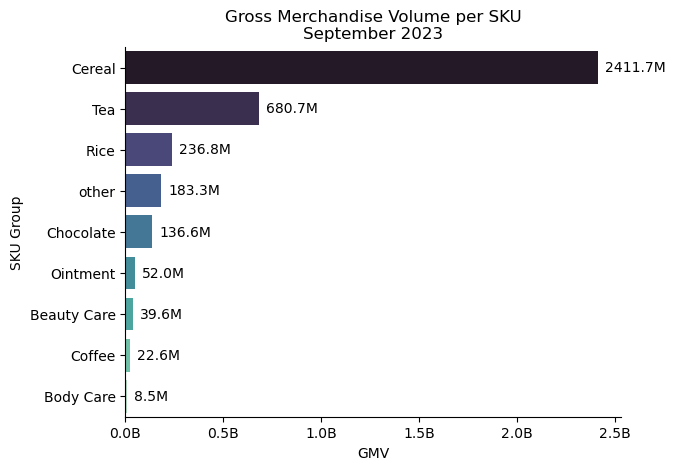

In [41]:
# chart GMV per SKU
ax = sns.barplot(data=df_gmv_aov,x='gross_merchandise_volume',y='main_sku',palette='mako')
ax.xaxis.set_major_formatter(FuncFormatter(billions_formatter))
for p in ax.patches:
    ax.annotate(f'{p.get_width() / 1e6:.1f}M',(p.get_width(),p.get_y()+p.get_height()/2),ha='left',va='center',
                color='black',xytext=(5,0),textcoords='offset points')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(f'Gross Merchandise Volume per SKU\n{df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}')
plt.xlabel('GMV')
plt.ylabel('SKU Group')
plt.savefig(f'GMV per SKU {df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}.png')
plt.show()

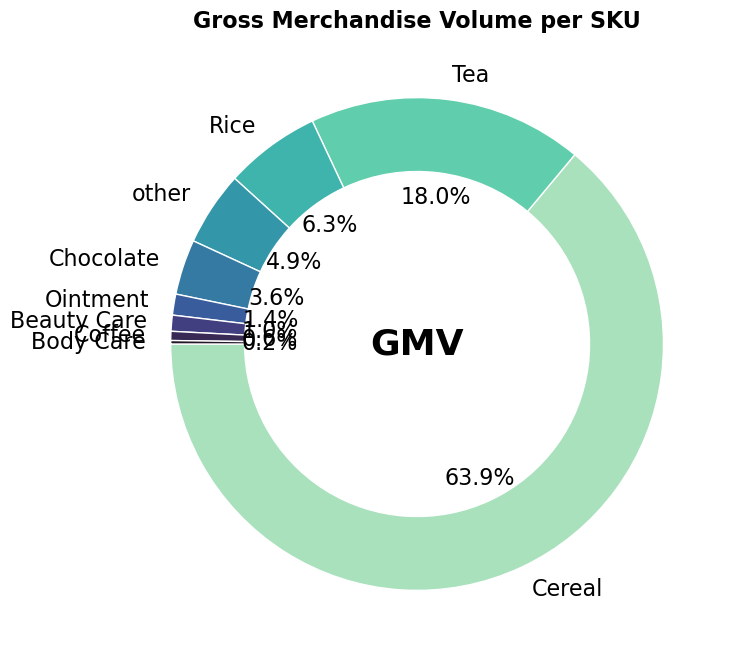

In [42]:
# Donnut Chart
plt.figure(figsize=(8, 8))
ax = plt.gca()
total_gmv = df_gmv_aov['gross_merchandise_volume'].sum()
colors = sns.color_palette('mako_r', len(df_gmv_aov['main_sku']))

ax.pie(df_gmv_aov['gross_merchandise_volume'], labels=df_gmv_aov['main_sku'], autopct='%1.1f%%', startangle=180,
       colors=colors, wedgeprops=dict(width=0.3, edgecolor='w'), textprops={'fontsize': 16})

# hole for donnut chart
center_circle = plt.Circle((0, 0), 0.7, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.text(0, 0, 'GMV', ha='center', va='center', fontsize=26, fontweight='bold')
plt.title('Gross Merchandise Volume per SKU', fontsize=16, fontweight='bold')
plt.savefig(f'pie chart GMV per SKU {df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}.png')
plt.show()

### Average Order Value per SKU

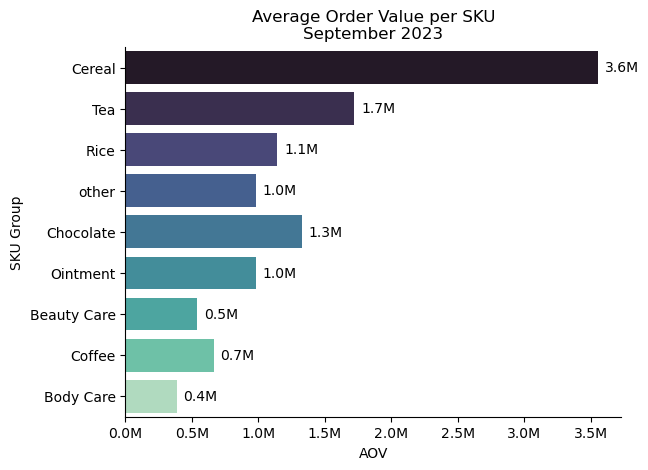

In [43]:
# chart AOV per SKU latest Month
ax = sns.barplot(data=df_gmv_aov,x='average_order_value',y='main_sku',palette='mako')
ax.xaxis.set_major_formatter(FuncFormatter(millions_formater))
for p in ax.patches:
    ax.annotate(f'{p.get_width() / 1e6:.1f}M',(p.get_width(),p.get_y()+p.get_height()/2),ha='left',va='center',
                color='black',xytext=(5,0),textcoords='offset points')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(f'Average Order Value per SKU\n{df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}')
plt.xlabel('AOV')
plt.ylabel('SKU Group')
plt.savefig(f'AOV per SKU {df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}.png')
plt.show()

### Number of Invoice 

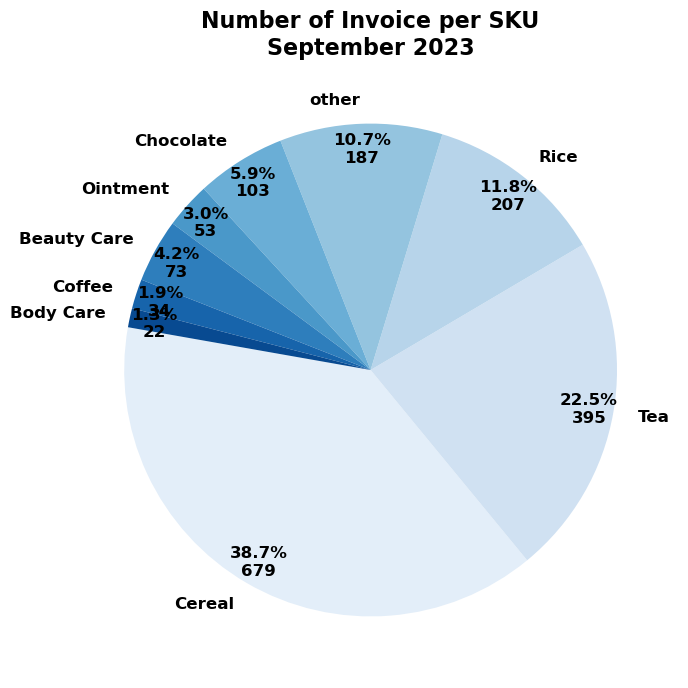

In [44]:
# Membuat pie chart dengan data value label di dalam garis
colors = sns.color_palette('Blues', len(df_gmv_aov['main_sku']))
plt.figure(figsize=(8,8))
plt.pie(df_gmv_aov['number_invoice'], labels=df_gmv_aov['main_sku'], colors=colors,
        autopct=lambda p: '{:.1f}%\n{:.0f}'.format(p, p * sum(df_gmv_aov['number_invoice']) / 100),
        startangle=170, pctdistance=0.9, textprops=dict(fontsize=12, weight='bold'))
plt.title(f'Number of Invoice per SKU\n{df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}', fontsize=16, weight='bold')
plt.savefig(f'invoice_per_SKU_{df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].max().year}.png')
plt.show()

### Average Revenue per User

In [45]:
# Revenue per User
revenue_per_user = pd.DataFrame(df_sales_latest_month.groupby('sales_id')['amount'].sum())
df_revenue_per_user = revenue_per_user.sort_values(by='amount',ascending=False).reset_index()

# show amount > ARPU
threshold = arpu
#df_revenue_per_user['sales_id'] = df_revenue_per_user.apply(lambda row: row['sales_id'] if row['amount'] > threshold else 'other', axis=1)
df_revenue_top10 = df_revenue_per_user.head(10)
print(f'{df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}\nARPU:{arpu:,.1f}\nNumber of Agent: {unique_customers}\nTop 10 Revenue: {len(df_revenue_top10)}')
df_revenue_top10.to_csv(f'df_arpu_{df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].dt.year.max()}.csv')
df_revenue_top10

September 2023
ARPU:13,141,672.3
Number of Agent: 287
Top 10 Revenue: 10


sales_id        amount
0       81 771,611,575.0
1       21 581,959,350.0
2       40 372,365,000.0
3       23 153,756,750.0
4     1902 153,541,500.0
5      912  85,580,250.0
6     2140  74,710,125.0
7     1023  66,281,425.0
8     1070  57,859,725.0
9      928  51,215,500.0

In [46]:
df_revenue_per_user.head()

sales_id        amount
0       81 771,611,575.0
1       21 581,959,350.0
2       40 372,365,000.0
3       23 153,756,750.0
4     1902 153,541,500.0

In [47]:
df_revenue_per_user.tail(10)

sales_id    amount
277     2256 429,625.0
278      696 400,750.0
279      380 400,750.0
280       86 315,000.0
281       50 315,000.0
282      375 189,000.0
283       62 173,425.0
284      927 145,425.0
285       46 145,250.0
286       85 143,500.0

In [48]:
df_under_1million = df_revenue_per_user[df_revenue_per_user['amount']<1000000]
df_under_1million.to_csv(f'df_under_1million_{df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}.csv')
df_under_1million

sales_id    amount
223            1056 946,750.0
224              48 945,000.0
225              25 903,000.0
226             222 893,375.0
227            2246 865,375.0
228            1537 861,000.0
229            1824 861,000.0
230             628 861,000.0
231            1798 861,000.0
232            1205 860,125.0
233            2330 859,250.0
234            1743 859,250.0
235             668 859,250.0
236            2254 859,250.0
237            1496 859,250.0
238            1721 859,250.0
239            1926 859,250.0
240            1590 859,250.0
241            1847 859,250.0
242            1761 859,250.0
243              80 859,250.0
244            1171 859,250.0
245              58 859,250.0
246            1053 859,250.0
247            2231 859,250.0
248            2071 836,500.0
249             401 822,500.0
250            1637 815,500.0
251             227 805,007.0
252             112 801,500.0
253            2233 735,000.0
254             777 726,250.0
255            2268 677,425.0
256             350 644,875.0
257             577 537,250.0
258            2363 535,675.0
259              75 525,000.0
260              24 502,250.0
261              79 483,000.0
262            2068 478,975.0
263  9/11/2005 0:00 453,250.0
264              74 446,775.0
265            2309 435,750.0
266            1606 430,500.0
267            1941 430,500.0
268            1048 430,500.0
269            1814 430,500.0
270            1488 429,625.0
271             132 429,625.0
272            1712 429,625.0
273            2108 429,625.0
274              67 429,625.0
275            1013 429,625.0
276            1072 429,625.0
277            2256 429,625.0
278             696 400,750.0
279             380 400,750.0
280              86 315,000.0
281              50 315,000.0
282             375 189,000.0
283              62 173,425.0
284             927 145,425.0
285              46 145,250.0
286              85 143,500.0

In [49]:
df_low_arpu = df_revenue_per_user[df_revenue_per_user['amount']<arpu]
df_high_arpu = df_revenue_per_user[df_revenue_per_user['amount']>arpu]
print(f'number low arpu agent : {len(df_low_arpu)}\nnumber high arpu agent : {len(df_high_arpu)}')

number low arpu agent : 250
number high arpu agent : 37


In [50]:
df_summary = pd.DataFrame({
    'number of low arpu agent':len(df_low_arpu),
    'number of hi arpu agent':len(df_high_arpu),
    'total revenue low arpu': df_low_arpu['amount'].sum(),
    'total revenue hi arpu': df_high_arpu['amount'].sum(),
    'perc low arpu': round(100*df_low_arpu['amount'].sum() / df_revenue_per_user['amount'].sum(),2),
    'perc hi arpu': round(100*df_high_arpu['amount'].sum() / df_revenue_per_user['amount'].sum(),2)
},index=[0])
df_summary = df_summary.T
df_summary.to_csv('df_summary_revenue_per_user.csv')
df_summary

0
number of low arpu agent           250.0
number of hi arpu agent             37.0
total revenue low arpu     675,313,485.0
total revenue hi arpu    3,096,346,468.2
perc low arpu                       17.9
perc hi arpu                        82.1

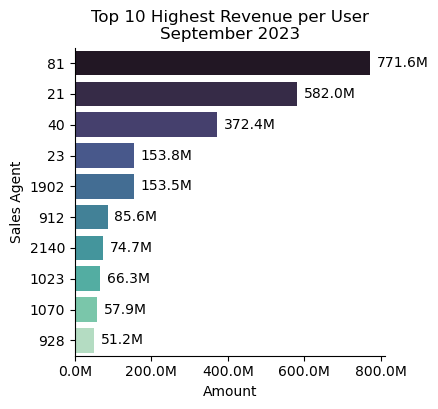

In [51]:
# Chart Revenue Per User > ARPU
plt.figure(figsize=(4,4))
ax = sns.barplot(data=df_revenue_top10,x='amount',y='sales_id',palette='mako')
ax.xaxis.set_major_formatter(FuncFormatter(millions_formater))
for p in ax.patches:
    ax.annotate(f'{p.get_width() / 1e6:.1f}M',(p.get_width(),p.get_y()+p.get_height()/2),ha='left',va='center',
                color='black',xytext=(5,0),textcoords='offset points')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(f'Top 10 Highest Revenue per User\n{df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}')
plt.xlabel('Amount')
plt.ylabel('Sales Agent')
plt.savefig(f'Revenue per User {df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}.png')
plt.show()

### Repeat Purchase Rate
RPR provides insight into how well we retains customers and encourages them to return to shop

In [52]:
# assign month label
df_rpr = df_sales.assign(month_year=df_sales['barcode_date'].dt.to_period('M'))
df_rpr

invoice sales_id sales_agent        level distibutor agent reseller  \
0       K1925      116      Anna R     Reseller       HAYA  KRIS      NaN   
1       K1926      121      M Herm  Distributor        NaN   NaN      NaN   
2       K1927       63      HERI S        Agent       HAYA   NaN      NaN   
3       K1927       63      HERI S        Agent       HAYA   NaN      NaN   
4       K1927       63      HERI S        Agent       HAYA   NaN      NaN   
...       ...      ...         ...          ...        ...   ...      ...   
67932  t12403     1972      Sudars     Retailer       RONG   NaN     Mudz   
67933  t12404     1902      DR. ED     Reseller       HAYA   NaN      NaN   
67934  t12404     1902      DR. ED     Reseller       HAYA   NaN      NaN   
67935  t12406      928      Tokar      Retailer       HAYA   NaN      NaN   
67936    2045       76      PT. OR    Principal        NaN   NaN      NaN   

                         customer_email customer_hp  cutomer_name  \
0                                   NaN         NaN           NaN   
1                                   NaN         NaN           NaN   
2                                   NaN         NaN           NaN   
3                                   NaN         NaN           NaN   
4                                   NaN         NaN           NaN   
...                                 ...         ...           ...   
67932            darso1979.ss@gmail.com    6.28E+12     Sudarsono   
67933          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67934          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67935  Konsumentokarindonesia@gmail.com    6.28E+12    Ibu Swanny   
67936                               NaN         NaN           NaN   

      barcode_date  subdistrict            district     province  \
0       2018-02-02      Rungkut            Surabaya   Jawa Timur   
1       2018-02-02  Balongbendo            Sidoarjo   Jawa Timur   
2       2018-02-02  Balongbendo            Sidoarjo   Jawa Timur   
3       2018-02-02  Balongbendo            Sidoarjo   Jawa Timur   
4       2018-02-02  Balongbendo            Sidoarjo   Jawa Timur   
...            ...          ...                 ...          ...   
67932   2023-09-30      Rembang  Kabupaten Pasuruan   Jawa Timur   
67933   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67934   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67935   2023-09-30  Kediri Kota         Kota Kediri   Jawa Timur   
67936   2023-09-30      Buduran            Sidoarjo   Jawa Timur   

                     product  box  pack       amount   buyer_type  quantity  \
0            ALGATEA REGULER    2     0    358,750.0  sales agent       2.0   
1            ALGATEA REGULER    2     0    315,000.0  sales agent       2.0   
2                         AK    2     0    332,500.0  sales agent       2.0   
3      ALGA Kirei Beauty Pck    0     4    665,000.0  sales agent       1.0   
4            ALGATEA REGULER    2     0    332,500.0  sales agent       2.0   
...                      ...  ...   ...          ...          ...       ...   
67932        FLOSSOM ROSELLA    0     2     71,750.0     end user       0.5   
67933           BERAS KARNUS    0     2     91,000.0     end user       0.5   
67934       STARTERPACK AGAT    2     0    547,750.0     end user       2.0   
67935               GoodMove    0     4    577,500.0     end user       1.0   
67936      Otulgro 10 sachet    0  1152 40,320,000.0  sales agent     288.0   

        brand   main_sku  month  year month_year  
0      health        Tea      2  2018    2018-02  
1      health        Tea      2  2018    2018-02  
2      health  Chocolate      2  2018    2018-02  
3      health  Chocolate      2  2018    2018-02  
4      health        Tea      2  2018    2018-02  
...       ...        ...    ...   ...        ...  
67932   other      other      9  2023    2023-09  
67933   other       Rice      9  2023    2023-09  
67934  health     Cereal   

In [53]:
# Calculate the number of unique sales_id slices between last month and this month
df_rpr_sales_count = df_rpr.groupby('month_year')['sales_id'].nunique().reset_index(name='number_sales_id')
df_rpr_sales_count['number_last_id_repeat'] = df_rpr_sales_count['month_year'].apply(
    lambda x: len(set(df_rpr[df_rpr['month_year']==x]['sales_id']).intersection(
        set(df_rpr[df_rpr['month_year'] == (x-1)]['sales_id'])
    )))
df_rpr_sales_count = df_rpr_sales_count.assign(rpr=100*df_rpr_sales_count['number_last_id_repeat']/df_rpr_sales_count['number_sales_id'])

# select data for last 2 years
df_rpr_arn = df_rpr_sales_count.tail(25).reset_index()
df_rpr_arn['month_year'] = df_rpr_arn['month_year'].astype(str)
df_rpr_arn.to_csv(f'df_rpr_{df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].dt.year.max()}.csv')
df_rpr_arn

index month_year  number_sales_id  number_last_id_repeat  rpr
0      43    2021-09              293                    191 65.2
1      44    2021-10              301                    200 66.4
2      45    2021-11              268                    180 67.2
3      46    2021-12              320                    190 59.4
4      47    2022-01              355                    225 63.4
5      48    2022-02              264                    172 65.2
6      49    2022-03              296                    165 55.7
7      50    2022-04              290                    171 59.0
8      51    2022-05              273                    172 63.0
9      52    2022-06              277                    174 62.8
10     53    2022-07              286                    170 59.4
11     54    2022-08              295                    179 60.7
12     55    2022-09              299                    180 60.2
13     56    2022-10              284                    201 70.8
14     57    2022-11              310                    194 62.6
15     58    2022-12              312                    196 62.8
16     59    2023-01              331                    206 62.2
17     60    2023-02              272                    185 68.0
18     61    2023-03              283                    182 64.3
19     62    2023-04              307                    198 64.5
20     63    2023-05              246                    179 72.8
21     64    2023-06              287                    177 61.7
22     65    2023-07              274                    195 71.2
23     66    2023-08              275                    186 67.6
24     67    2023-09              287                    177 61.7

In [54]:
# check data type
df_rpr_arn.dtypes

index                      int64
month_year                object
number_sales_id            int64
number_last_id_repeat      int64
rpr                      float64
dtype: object

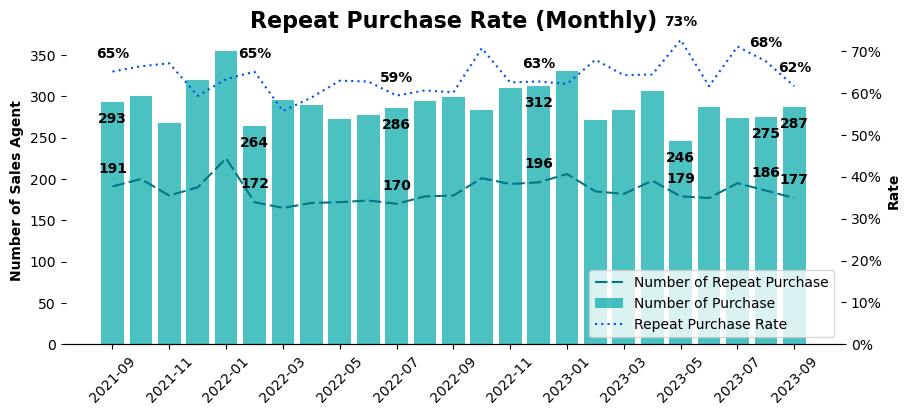

In [55]:
# Chart Number of Sales Agent Purchase & Repeat Purchase
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(df_rpr_arn['month_year'],df_rpr_arn['number_last_id_repeat'],
         label='Number of Repeat Purchase',dashes=[6,2],color='#027683')
ax1.bar(df_rpr_arn['month_year'],df_rpr_arn['number_sales_id'],color='#00A7A7',alpha=0.7,label='Number of Purchase')
ax1.set_ylabel('Number of Sales Agent',fontsize=10,fontweight='bold')
ax1.tick_params(axis='y')#, labelcolor='#027683')
ax1.set_ylim(bottom=0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.xaxis.grid(False)
ax1.yaxis.grid(False)
ax1.set_xticks(df_rpr_arn['month_year'])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
# Set label x-axis
label_indices = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
bar_positions = np.arange(len(df_rpr_arn['month_year']))
visible_indices = [i for i in bar_positions if i in label_indices]
ax1.set_xticks(bar_positions[visible_indices])
ax1.set_xticklabels(df_rpr_arn['month_year'].iloc[visible_indices], rotation=45)

# Chart of Repeat Purchase Rate
ax2 = ax1.twinx()
ax2.plot(df_rpr_arn['month_year'],df_rpr_arn['rpr'],label='Repeat Purchase Rate',dashes=[1,2],color='#0051E8')
ax2.set_xlabel('Month Year',)
ax2.set_ylabel('Rate',fontsize=10,fontweight='bold')
ax2.tick_params(axis='y')#, labelcolor='#027683')
ax2.set_ylim(bottom=0)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

# legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right')

label_indices = [0, 5, 10, 15, 20, 23, 24]
for i in label_indices:
    if i < len(df_rpr_arn):
        ax2.annotate(f'{df_rpr_arn["rpr"].iloc[i]:.0f}%', 
                     (df_rpr_arn['month_year'].iloc[i], df_rpr_arn["rpr"].iloc[i]),
                     textcoords="offset points", xytext=(0, 10), ha='center',fontsize=10,fontweight='bold')
        ax1.annotate(f'{df_rpr_arn["number_last_id_repeat"].iloc[i]}', 
                     (df_rpr_arn['month_year'].iloc[i], df_rpr_arn["number_last_id_repeat"].iloc[i]),
                     textcoords="offset points", xytext=(0, 10), ha='center',fontsize=10,fontweight='bold')
        ax1.annotate(f'{df_rpr_arn["number_sales_id"].iloc[i]}', 
                     (df_rpr_arn['month_year'].iloc[i], df_rpr_arn["number_sales_id"].iloc[i]),
                     textcoords="offset points", xytext=(0, -15), ha='center',fontsize=10,fontweight='bold')
plt.title('Repeat Purchase Rate (Monthly)',fontsize=16,fontweight='bold')
plt.savefig(f'rpr {df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}.png')
plt.show()

### Cohort Retention Rate

In [56]:
# select dataframe in condition : interval last 2 years and contains sales_id other than 1 (sales_id 1 belongs to principal)
df_sales_2years = df_sales[(~df_sales['sales_id'].isin(['1'])) & (df_sales['barcode_date'].dt.year > 2021)]
df_sales_2years

invoice sales_id sales_agent      level distibutor agent reseller  \
36233  K23278     1604      Tatiet   Retailer       Guda  SRIW      NaN   
36234  K23279      441      ROHMIA   Reseller       MAJA   NaN      NaN   
36235  K23282      219      dr.Moh      Agent       RONG   NaN      NaN   
36236  K23282      219      dr.Moh      Agent       RONG   NaN      NaN   
36237  K23282      219      dr.Moh      Agent       RONG   NaN      NaN   
...       ...      ...         ...        ...        ...   ...      ...   
67932  t12403     1972      Sudars   Retailer       RONG   NaN     Mudz   
67933  t12404     1902      DR. ED   Reseller       HAYA   NaN      NaN   
67934  t12404     1902      DR. ED   Reseller       HAYA   NaN      NaN   
67935  t12406      928      Tokar    Retailer       HAYA   NaN      NaN   
67936    2045       76      PT. OR  Principal        NaN   NaN      NaN   

                         customer_email customer_hp  cutomer_name  \
36233                               NaN         NaN           NaN   
36234                               NaN         NaN           NaN   
36235                               NaN         NaN           NaN   
36236                               NaN         NaN           NaN   
36237                               NaN         NaN           NaN   
...                                 ...         ...           ...   
67932            darso1979.ss@gmail.com    6.28E+12     Sudarsono   
67933          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67934          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67935  Konsumentokarindonesia@gmail.com    6.28E+12    Ibu Swanny   
67936                               NaN         NaN           NaN   

      barcode_date  subdistrict            district     province  \
36233   2022-01-01       Ciomas               Bogor   Jawa Barat   
36234   2022-01-01      Srengat              Blitar   Jawa Timur   
36235   2022-01-01        Diwek             Jombang   Jawa Timur   
36236   2022-01-01        Diwek             Jombang   Jawa Timur   
36237   2022-01-01        Diwek             Jombang   Jawa Timur   
...            ...          ...                 ...          ...   
67932   2023-09-30      Rembang  Kabupaten Pasuruan   Jawa Timur   
67933   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67934   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67935   2023-09-30  Kediri Kota         Kota Kediri   Jawa Timur   
67936   2023-09-30      Buduran            Sidoarjo   Jawa Timur   

                   product  box  pack       amount   buyer_type  quantity  \
36233     STARTERPACK AGAT    4     0    770,000.0  sales agent       4.0   
36234      ALGATEA REGULER    4     0    717,500.0  sales agent       4.0   
36235       AG ECCO KARTON    6     0    997,500.0  sales agent       6.0   
36236                   AK    4     0    665,000.0  sales agent       4.0   
36237  ALGATEA ECCO KARTON    2     0    332,500.0  sales agent       2.0   
...                    ...  ...   ...          ...          ...       ...   
67932      FLOSSOM ROSELLA    0     2     71,750.0     end user       0.5   
67933         BERAS KARNUS    0     2     91,000.0     end user       0.5   
67934     STARTERPACK AGAT    2     0    547,750.0     end user       2.0   
67935             GoodMove    0     4    577,500.0     end user       1.0   
67936    Otulgro 10 sachet    0  1152 40,320,000.0  sales agent     288.0   

        brand   main_sku  month  year month_year  
36233  health     Cereal      1  2022    2022-01  
36234  health        Tea      1  2022    2022-01  
36235  health     Cereal      1  2022    2022-01  
36236  health  Chocolate      1  2022    2022-01  
36237  health        Tea      1  2022    2022-01  
...       ...        ...    ...   ...        ...  
67932   other      other      9  2023    2023-09  
67933   other       Rice      9  2023    2023-09  
67934  health     Cereal      9  2023    2023-09  
67935   other   Ointment

In [57]:
#create a monthly date
import datetime as dt
#function for month
def get_month(x):
    return dt.datetime(x.year, x.month,1)

df_sales_2years['barcode_month'] = df_sales_2years['barcode_date'].apply(get_month)
df_sales_2years

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1008\261653772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales_2years['barcode_month'] = df_sales_2years['barcode_date'].apply(get_month)


invoice sales_id sales_agent      level distibutor agent reseller  \
36233  K23278     1604      Tatiet   Retailer       Guda  SRIW      NaN   
36234  K23279      441      ROHMIA   Reseller       MAJA   NaN      NaN   
36235  K23282      219      dr.Moh      Agent       RONG   NaN      NaN   
36236  K23282      219      dr.Moh      Agent       RONG   NaN      NaN   
36237  K23282      219      dr.Moh      Agent       RONG   NaN      NaN   
...       ...      ...         ...        ...        ...   ...      ...   
67932  t12403     1972      Sudars   Retailer       RONG   NaN     Mudz   
67933  t12404     1902      DR. ED   Reseller       HAYA   NaN      NaN   
67934  t12404     1902      DR. ED   Reseller       HAYA   NaN      NaN   
67935  t12406      928      Tokar    Retailer       HAYA   NaN      NaN   
67936    2045       76      PT. OR  Principal        NaN   NaN      NaN   

                         customer_email customer_hp  cutomer_name  \
36233                               NaN         NaN           NaN   
36234                               NaN         NaN           NaN   
36235                               NaN         NaN           NaN   
36236                               NaN         NaN           NaN   
36237                               NaN         NaN           NaN   
...                                 ...         ...           ...   
67932            darso1979.ss@gmail.com    6.28E+12     Sudarsono   
67933          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67934          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67935  Konsumentokarindonesia@gmail.com    6.28E+12    Ibu Swanny   
67936                               NaN         NaN           NaN   

      barcode_date  subdistrict            district     province  \
36233   2022-01-01       Ciomas               Bogor   Jawa Barat   
36234   2022-01-01      Srengat              Blitar   Jawa Timur   
36235   2022-01-01        Diwek             Jombang   Jawa Timur   
36236   2022-01-01        Diwek             Jombang   Jawa Timur   
36237   2022-01-01        Diwek             Jombang   Jawa Timur   
...            ...          ...                 ...          ...   
67932   2023-09-30      Rembang  Kabupaten Pasuruan   Jawa Timur   
67933   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67934   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67935   2023-09-30  Kediri Kota         Kota Kediri   Jawa Timur   
67936   2023-09-30      Buduran            Sidoarjo   Jawa Timur   

                   product  box  pack       amount   buyer_type  quantity  \
36233     STARTERPACK AGAT    4     0    770,000.0  sales agent       4.0   
36234      ALGATEA REGULER    4     0    717,500.0  sales agent       4.0   
36235       AG ECCO KARTON    6     0    997,500.0  sales agent       6.0   
36236                   AK    4     0    665,000.0  sales agent       4.0   
36237  ALGATEA ECCO KARTON    2     0    332,500.0  sales agent       2.0   
...                    ...  ...   ...          ...          ...       ...   
67932      FLOSSOM ROSELLA    0     2     71,750.0     end user       0.5   
67933         BERAS KARNUS    0     2     91,000.0     end user       0.5   
67934     STARTERPACK AGAT    2     0    547,750.0     end user       2.0   
67935             GoodMove    0     4    577,500.0     end user       1.0   
67936    Otulgro 10 sachet    0  1152 40,320,000.0  sales agent     288.0   

        brand   main_sku  month  year month_year barcode_month  
36233  health     Cereal      1  2022    2022-01    2022-01-01  
36234  health        Tea      1  2022    2022-01    2022-01-01  
36235  health     Cereal      1  2022    2022-01    2022-01-01  
36236  health  Chocolate      1  2022    2022-01    2022-01-01  
36237  health        Tea      1  2022    2022-01    2022-01-01  
...       ...        ...    ...   ...        ...           ...  
67932   other      other      9  2023    2023-09    2023-09-01  
67933   other 

In [58]:
# column index with the minimum invoice date, it is the first time customer was acquired
df_sales_2years['cohort_month'] = df_sales_2years.groupby('sales_id')['barcode_month'].transform('min')
df_sales_2years

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1008\1158860914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales_2years['cohort_month'] = df_sales_2years.groupby('sales_id')['barcode_month'].transform('min')


invoice sales_id sales_agent      level distibutor agent reseller  \
36233  K23278     1604      Tatiet   Retailer       Guda  SRIW      NaN   
36234  K23279      441      ROHMIA   Reseller       MAJA   NaN      NaN   
36235  K23282      219      dr.Moh      Agent       RONG   NaN      NaN   
36236  K23282      219      dr.Moh      Agent       RONG   NaN      NaN   
36237  K23282      219      dr.Moh      Agent       RONG   NaN      NaN   
...       ...      ...         ...        ...        ...   ...      ...   
67932  t12403     1972      Sudars   Retailer       RONG   NaN     Mudz   
67933  t12404     1902      DR. ED   Reseller       HAYA   NaN      NaN   
67934  t12404     1902      DR. ED   Reseller       HAYA   NaN      NaN   
67935  t12406      928      Tokar    Retailer       HAYA   NaN      NaN   
67936    2045       76      PT. OR  Principal        NaN   NaN      NaN   

                         customer_email customer_hp  cutomer_name  \
36233                               NaN         NaN           NaN   
36234                               NaN         NaN           NaN   
36235                               NaN         NaN           NaN   
36236                               NaN         NaN           NaN   
36237                               NaN         NaN           NaN   
...                                 ...         ...           ...   
67932            darso1979.ss@gmail.com    6.28E+12     Sudarsono   
67933          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67934          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67935  Konsumentokarindonesia@gmail.com    6.28E+12    Ibu Swanny   
67936                               NaN         NaN           NaN   

      barcode_date  subdistrict            district     province  \
36233   2022-01-01       Ciomas               Bogor   Jawa Barat   
36234   2022-01-01      Srengat              Blitar   Jawa Timur   
36235   2022-01-01        Diwek             Jombang   Jawa Timur   
36236   2022-01-01        Diwek             Jombang   Jawa Timur   
36237   2022-01-01        Diwek             Jombang   Jawa Timur   
...            ...          ...                 ...          ...   
67932   2023-09-30      Rembang  Kabupaten Pasuruan   Jawa Timur   
67933   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67934   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67935   2023-09-30  Kediri Kota         Kota Kediri   Jawa Timur   
67936   2023-09-30      Buduran            Sidoarjo   Jawa Timur   

                   product  box  pack       amount   buyer_type  quantity  \
36233     STARTERPACK AGAT    4     0    770,000.0  sales agent       4.0   
36234      ALGATEA REGULER    4     0    717,500.0  sales agent       4.0   
36235       AG ECCO KARTON    6     0    997,500.0  sales agent       6.0   
36236                   AK    4     0    665,000.0  sales agent       4.0   
36237  ALGATEA ECCO KARTON    2     0    332,500.0  sales agent       2.0   
...                    ...  ...   ...          ...          ...       ...   
67932      FLOSSOM ROSELLA    0     2     71,750.0     end user       0.5   
67933         BERAS KARNUS    0     2     91,000.0     end user       0.5   
67934     STARTERPACK AGAT    2     0    547,750.0     end user       2.0   
67935             GoodMove    0     4    577,500.0     end user       1.0   
67936    Otulgro 10 sachet    0  1152 40,320,000.0  sales agent     288.0   

        brand   main_sku  month  year month_year barcode_month cohort_month  
36233  health     Cereal      1  2022    2022-01    2022-01-01   2022-01-01  
36234  health        Tea      1  2022    2022-01    2022-01-01   2022-01-01  
36235  health     Cereal      1  2022    2022-01    2022-01-01   2022-01-01  
36236  health  Chocolate      1  2022    2022-01    2022-01-01   2022-01-01  
36237  health        Tea      1  2022    2022-01    2022-01-01   2022-01-01  
...       ...        ...    ...   ...        ...           ...    

In [59]:
# substract date elements
def get_date_elements(df, column):
    day = df[column].dt.day
    month = df[column].dt.month
    year = df[column].dt.year
    return day, month, year

# get date elements (month & year) for cohort and barcode_date columns
_,barcode_month,barcode_year =  get_date_elements(df_sales_2years,'barcode_month')
_,cohort_month,cohort_year =  get_date_elements(df_sales_2years,'cohort_month')

#create a cohort index
year_diff = barcode_year - cohort_year
month_diff = barcode_month - cohort_month
df_sales_2years['cohort_index'] = year_diff*12+month_diff+1
df_sales_2years

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1008\3903645229.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales_2years['cohort_index'] = year_diff*12+month_diff+1


invoice sales_id sales_agent      level distibutor agent reseller  \
36233  K23278     1604      Tatiet   Retailer       Guda  SRIW      NaN   
36234  K23279      441      ROHMIA   Reseller       MAJA   NaN      NaN   
36235  K23282      219      dr.Moh      Agent       RONG   NaN      NaN   
36236  K23282      219      dr.Moh      Agent       RONG   NaN      NaN   
36237  K23282      219      dr.Moh      Agent       RONG   NaN      NaN   
...       ...      ...         ...        ...        ...   ...      ...   
67932  t12403     1972      Sudars   Retailer       RONG   NaN     Mudz   
67933  t12404     1902      DR. ED   Reseller       HAYA   NaN      NaN   
67934  t12404     1902      DR. ED   Reseller       HAYA   NaN      NaN   
67935  t12406      928      Tokar    Retailer       HAYA   NaN      NaN   
67936    2045       76      PT. OR  Principal        NaN   NaN      NaN   

                         customer_email customer_hp  cutomer_name  \
36233                               NaN         NaN           NaN   
36234                               NaN         NaN           NaN   
36235                               NaN         NaN           NaN   
36236                               NaN         NaN           NaN   
36237                               NaN         NaN           NaN   
...                                 ...         ...           ...   
67932            darso1979.ss@gmail.com    6.28E+12     Sudarsono   
67933          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67934          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67935  Konsumentokarindonesia@gmail.com    6.28E+12    Ibu Swanny   
67936                               NaN         NaN           NaN   

      barcode_date  subdistrict            district     province  \
36233   2022-01-01       Ciomas               Bogor   Jawa Barat   
36234   2022-01-01      Srengat              Blitar   Jawa Timur   
36235   2022-01-01        Diwek             Jombang   Jawa Timur   
36236   2022-01-01        Diwek             Jombang   Jawa Timur   
36237   2022-01-01        Diwek             Jombang   Jawa Timur   
...            ...          ...                 ...          ...   
67932   2023-09-30      Rembang  Kabupaten Pasuruan   Jawa Timur   
67933   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67934   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67935   2023-09-30  Kediri Kota         Kota Kediri   Jawa Timur   
67936   2023-09-30      Buduran            Sidoarjo   Jawa Timur   

                   product  box  pack       amount   buyer_type  quantity  \
36233     STARTERPACK AGAT    4     0    770,000.0  sales agent       4.0   
36234      ALGATEA REGULER    4     0    717,500.0  sales agent       4.0   
36235       AG ECCO KARTON    6     0    997,500.0  sales agent       6.0   
36236                   AK    4     0    665,000.0  sales agent       4.0   
36237  ALGATEA ECCO KARTON    2     0    332,500.0  sales agent       2.0   
...                    ...  ...   ...          ...          ...       ...   
67932      FLOSSOM ROSELLA    0     2     71,750.0     end user       0.5   
67933         BERAS KARNUS    0     2     91,000.0     end user       0.5   
67934     STARTERPACK AGAT    2     0    547,750.0     end user       2.0   
67935             GoodMove    0     4    577,500.0     end user       1.0   
67936    Otulgro 10 sachet    0  1152 40,320,000.0  sales agent     288.0   

        brand   main_sku  month  year month_year barcode_month cohort_month  \
36233  health     Cereal      1  2022    2022-01    2022-01-01   2022-01-01   
36234  health        Tea      1  2022    2022-01    2022-01-01   2022-01-01   
36235  health     Cereal      1  2022    2022-01    2022-01-01   2022-01-01   
36236  health  Chocolate      1  2022    2022-01    2022-01-01   2022-01-01   
36237  health        Tea      1  2022    2022-01    2022-01-01   2022-01-01   
...       ...        ...    ...   ...        ...           .

In [60]:
#count the customer ID by grouping by Cohort Month  and Cohort Index
cohort_data = df_sales_2years.groupby(['cohort_month','cohort_index'])['sales_id'].apply(pd.Series.nunique).reset_index()
cohort_data

cohort_month  cohort_index  sales_id
0     2022-01-01             1       354
1     2022-01-01             2       171
2     2022-01-01             3       201
3     2022-01-01             4       181
4     2022-01-01             5       170
5     2022-01-01             6       173
6     2022-01-01             7       164
7     2022-01-01             8       163
8     2022-01-01             9       160
9     2022-01-01            10       159
10    2022-01-01            11       158
11    2022-01-01            12       163
12    2022-01-01            13       155
13    2022-01-01            14       135
14    2022-01-01            15       149
15    2022-01-01            16       144
16    2022-01-01            17       125
17    2022-01-01            18       137
18    2022-01-01            19       136
19    2022-01-01            20       132
20    2022-01-01            21       131
21    2022-02-01             1        92
22    2022-02-01             2        33
23    2022-02-01             3        38
24    2022-02-01             4        32
25    2022-02-01             5        32
26    2022-02-01             6        32
27    2022-02-01             7        26
28    2022-02-01             8        32
29    2022-02-01             9        23
30    2022-02-01            10        29
31    2022-02-01            11        26
32    2022-02-01            12        29
33    2022-02-01            13        24
34    2022-02-01            14        26
35    2022-02-01            15        26
36    2022-02-01            16        19
37    2022-02-01            17        24
38    2022-02-01            18        19
39    2022-02-01            19        24
40    2022-02-01            20        20
41    2022-03-01             1        61
42    2022-03-01             2        13
43    2022-03-01             3        18
44    2022-03-01             4        15
45    2022-03-01             5        16
46    2022-03-01             6        13
47    2022-03-01             7        11
48    2022-03-01             8        13
49    2022-03-01             9        10
50    2022-03-01            10        11
51    2022-03-01            11        12
52    2022-03-01            12         5
53    2022-03-01            13        11
54    2022-03-01            14        14
55    2022-03-01            15        11
56    2022-03-01            16        10
57    2022-03-01            17        13
58    2022-03-01            18        11
59    2022-03-01            19         7
60    2022-04-01             1        57
61    2022-04-01             2        21
62    2022-04-01             3        16
63    2022-04-01             4        24
64    2022-04-01             5        22
65    2022-04-01             6        17
66    2022-04-01             7        15
67    2022-04-01             8        15
68    2022-04-01             9        15
69    2022-04-01            10        12
70    2022-04-01            11        15
71    2022-04-01            12        11
72    2022-04-01            13        17
73    2022-04-01            14         9
74    2022-04-01            15        14
75    2022-04-01            16        16
76    2022-04-01            17        15
77    2022-04-01            18        10
78    2022-05-01             1        31
79    2022-05-01             2         9
80    2022-05-01             3         9
81    2022-05-01             4         8
82    2022-05-01             5        10
83    2022-05-01             6         6
84    2022-05-01             7         9
85    2022-05-01             8         5
86    2022-05-01             9         6
87    2022-05-01            10         7
88    2022-05-01            11         6
89    2022-05-01            12         2
90    2022-05-01            13         5
91    2022-05-01            14         5
92    2022-05-01            15         3
93    2022-05-01            16         4
94    2022-05-01            17         7
95    2022-06-01             1        31
96    2022-06-01           

In [61]:
# create a pivot table
cohort_retention_amount = cohort_data.pivot(index='cohort_month', columns=['cohort_index'], values='sales_id')
cohort_retention_amount.index = cohort_retention_amount.index.strftime('%Y-%m')
cohort_retention_rate = cohort_retention_amount.divide(cohort_retention_amount.iloc[:,0],axis=0)
cohort_retention_amount.to_csv(f'df_rr_amount_{df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].dt.year.max()}.csv')
cohort_retention_rate.to_csv(f'df_rr_rate_{df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].dt.year.max()}.csv')

In [62]:
cohort_retention_amount

cohort_index    1     2     3     4     5     6     7     8     9     10  \
cohort_month                                                               
2022-01      354.0 171.0 201.0 181.0 170.0 173.0 164.0 163.0 160.0 159.0   
2022-02       92.0  33.0  38.0  32.0  32.0  32.0  26.0  32.0  23.0  29.0   
2022-03       61.0  13.0  18.0  15.0  16.0  13.0  11.0  13.0  10.0  11.0   
2022-04       57.0  21.0  16.0  24.0  22.0  17.0  15.0  15.0  15.0  12.0   
2022-05       31.0   9.0   9.0   8.0  10.0   6.0   9.0   5.0   6.0   7.0   
2022-06       31.0   9.0  14.0   7.0   8.0   7.0   7.0   5.0   4.0   4.0   
2022-07       31.0  13.0  12.0   7.0   9.0   8.0   9.0   8.0   7.0   5.0   
2022-08       35.0  16.0  14.0  10.0  13.0  11.0  12.0   9.0  13.0  11.0   
2022-09       33.0  17.0  22.0  18.0  17.0  15.0  13.0  15.0  12.0  21.0   
2022-10       21.0  10.0  11.0   9.0   7.0   9.0   9.0   8.0   7.0  11.0   
2022-11       30.0   5.0  10.0   5.0   5.0   6.0   3.0   4.0   3.0   2.0   
2022-12       29.0  18.0  11.0  15.0  13.0   9.0  12.0   9.0   8.0   9.0   
2023-01       37.0  14.0  10.0  15.0   9.0  14.0  10.0   9.0  11.0   NaN   
2023-02        9.0   1.0   3.0   1.0   1.0   1.0   2.0   2.0   NaN   NaN   
2023-03        6.0   3.0   1.0   2.0   3.0   1.0   2.0   NaN   NaN   NaN   
2023-04       17.0   4.0   6.0   8.0   4.0   6.0   NaN   NaN   NaN   NaN   
2023-05        3.0   NaN   1.0   1.0   2.0   NaN   NaN   NaN   NaN   NaN   
2023-06       10.0   5.0   5.0   2.0   NaN   NaN   NaN   NaN   NaN   NaN   
2023-07        6.0   1.0   2.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-08       14.0   2.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-09       30.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

cohort_index    11    12    13    14    15    16    17    18    19    20    21  
cohort_month                                                                    
2022-01      158.0 163.0 155.0 135.0 149.0 144.0 125.0 137.0 136.0 132.0 131.0  
2022-02       26.0  29.0  24.0  26.0  26.0  19.0  24.0  19.0  24.0  20.0   NaN  
2022-03       12.0   5.0  11.0  14.0  11.0  10.0  13.0  11.0   7.0   NaN   NaN  
2022-04       15.0  11.0  17.0   9.0  14.0  16.0  15.0  10.0   NaN   NaN   NaN  
2022-05        6.0   2.0   5.0   5.0   3.0   4.0   7.0   NaN   NaN   NaN   NaN  
2022-06        4.0   7.0   4.0   5.0   4.0   6.0   NaN   NaN   NaN   NaN   NaN  
2022-07        8.0   5.0   6.0   4.0   6.0   NaN   NaN   NaN   NaN   NaN   NaN  
2022-08       10.0   7.0  10.0  12.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2022-09       11.0  14.0  11.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2022-10        9.0   6.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2022-11        2.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2022-12        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2023-01        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2023-02        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2023-04        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2023-05        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2023-06        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2023-07        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2023-08        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2023-09        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [63]:
cohort_retention_rate

cohort_index  1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  \
cohort_month                                                                   
2022-01      1.0 0.5 0.6 0.5 0.5 0.5 0.5 0.5 0.5 0.4 0.4 0.5 0.4 0.4 0.4 0.4   
2022-02      1.0 0.4 0.4 0.3 0.3 0.3 0.3 0.3 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.2   
2022-03      1.0 0.2 0.3 0.2 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.2 0.2 0.2 0.2   
2022-04      1.0 0.4 0.3 0.4 0.4 0.3 0.3 0.3 0.3 0.2 0.3 0.2 0.3 0.2 0.2 0.3   
2022-05      1.0 0.3 0.3 0.3 0.3 0.2 0.3 0.2 0.2 0.2 0.2 0.1 0.2 0.2 0.1 0.1   
2022-06      1.0 0.3 0.5 0.2 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.2 0.1 0.2 0.1 0.2   
2022-07      1.0 0.4 0.4 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.3 0.2 0.2 0.1 0.2 NaN   
2022-08      1.0 0.5 0.4 0.3 0.4 0.3 0.3 0.3 0.4 0.3 0.3 0.2 0.3 0.3 NaN NaN   
2022-09      1.0 0.5 0.7 0.5 0.5 0.5 0.4 0.5 0.4 0.6 0.3 0.4 0.3 NaN NaN NaN   
2022-10      1.0 0.5 0.5 0.4 0.3 0.4 0.4 0.4 0.3 0.5 0.4 0.3 NaN NaN NaN NaN   
2022-11      1.0 0.2 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 NaN NaN NaN NaN NaN   
2022-12      1.0 0.6 0.4 0.5 0.4 0.3 0.4 0.3 0.3 0.3 NaN NaN NaN NaN NaN NaN   
2023-01      1.0 0.4 0.3 0.4 0.2 0.4 0.3 0.2 0.3 NaN NaN NaN NaN NaN NaN NaN   
2023-02      1.0 0.1 0.3 0.1 0.1 0.1 0.2 0.2 NaN NaN NaN NaN NaN NaN NaN NaN   
2023-03      1.0 0.5 0.2 0.3 0.5 0.2 0.3 NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2023-04      1.0 0.2 0.4 0.5 0.2 0.4 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2023-05      1.0 NaN 0.3 0.3 0.7 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2023-06      1.0 0.5 0.5 0.2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2023-07      1.0 0.2 0.3 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2023-08      1.0 0.1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2023-09      1.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

cohort_index  17  18  19  20  21  
cohort_month                      
2022-01      0.4 0.4 0.4 0.4 0.4  
2022-02      0.3 0.2 0.3 0.2 NaN  
2022-03      0.2 0.2 0.1 NaN NaN  
2022-04      0.3 0.2 NaN NaN NaN  
2022-05      0.2 NaN NaN NaN NaN  
2022-06      NaN NaN NaN NaN NaN  
2022-07      NaN NaN NaN NaN NaN  
2022-08      NaN NaN NaN NaN NaN  
2022-09      NaN NaN NaN NaN NaN  
2022-10      NaN NaN NaN NaN NaN  
2022-11      NaN NaN NaN NaN NaN  
2022-12      NaN NaN NaN NaN NaN  
2023-01      NaN NaN NaN NaN NaN  
2023-02      NaN NaN NaN NaN NaN  
2023-03      NaN NaN NaN NaN NaN  
2023-04      NaN NaN NaN NaN NaN  
2023-05      NaN NaN NaN NaN NaN  
2023-06      NaN NaN NaN NaN NaN  
2023-07      NaN NaN NaN NaN NaN  
2023-08      NaN NaN NaN NaN NaN  
2023-09      NaN NaN NaN NaN NaN

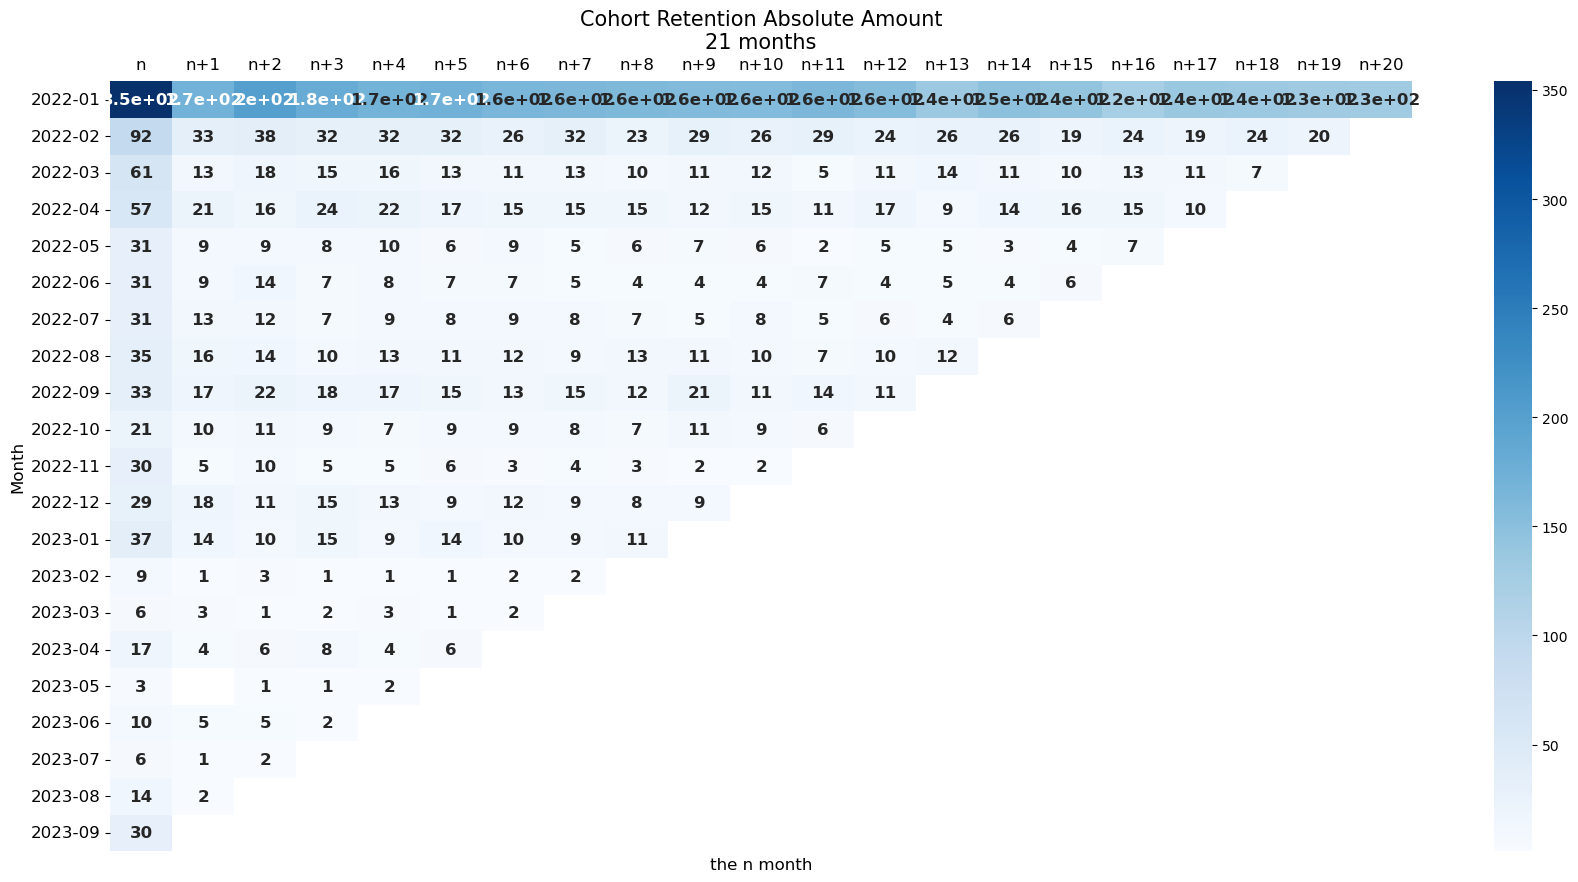

In [64]:
# Cohort Retention Sales Agent Matrix
plt.figure(figsize=(21,10))
sns.heatmap(cohort_retention_amount,cmap='Blues',annot=True,annot_kws={'size':12,'weight':'bold'})
ticks_position = [i+.5 for i in range(len(cohort_retention_amount))]
plt.xticks(ticks=ticks_position,labels=['n' if i==0 else f'n+{i}' for i in range(len(cohort_retention_amount))],fontsize=12)
plt.tick_params(axis='x',which='both',labeltop=True,bottom=False,labelbottom=False)
plt.yticks(ticks=ticks_position,labels=cohort_retention_rate.index,fontsize=12)
plt.title('Cohort Retention Absolute Amount\n21 months',size=15)
plt.xlabel('the n month',size=12)
plt.ylabel('Month',size=12)
plt.savefig(f'cohort retention absolute amount {df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}.png')
plt.show()

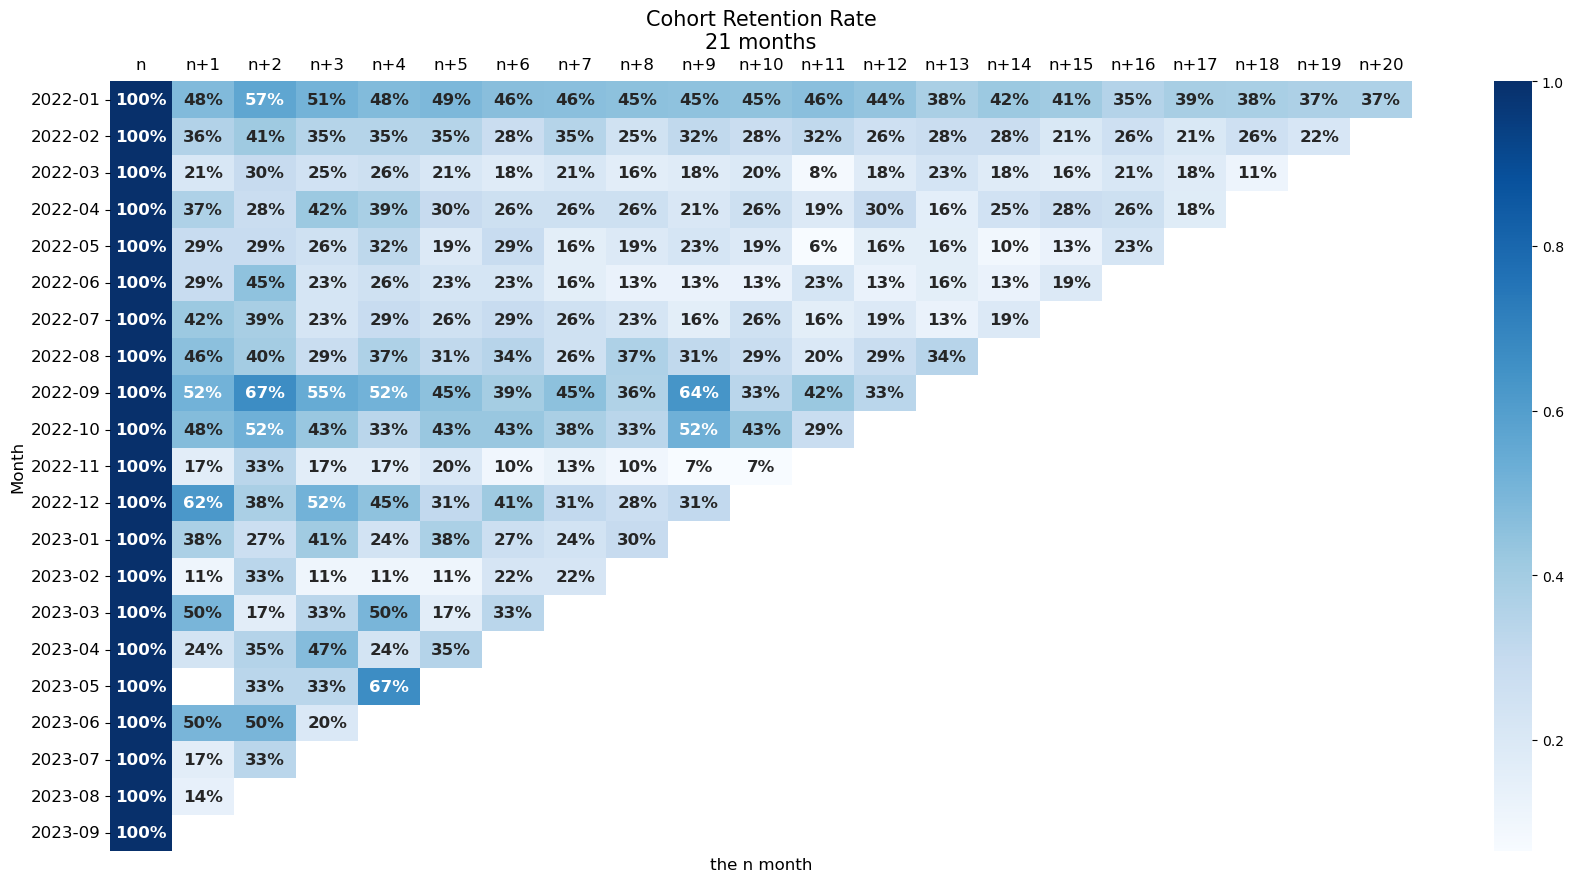

In [65]:
# Cohort Retention Rate Matrix
plt.figure(figsize=(21,10))
sns.heatmap(cohort_retention_rate,fmt='.0%',cmap='Blues',annot=True,annot_kws={'size':12,'weight':'bold'})
ticks_position = [i+.5 for i in range(len(cohort_retention_amount))]
plt.xticks(ticks=ticks_position,labels=['n' if i==0 else f'n+{i}' for i in range(len(cohort_retention_amount))],fontsize=12)
plt.tick_params(axis='x',which='both',labeltop=True,bottom=False,labelbottom=False)
plt.yticks(ticks=ticks_position,labels=cohort_retention_rate.index,fontsize=12)
plt.title('Cohort Retention Rate\n21 months',size=15)
plt.xlabel('the n month',size=12)
plt.ylabel('Month',size=12)
plt.savefig(f'cohort retention rate {df_sales["barcode_date"].max().strftime("%B")} {df_sales["barcode_date"].max().year}.png')
plt.show()

### 2) Monthly Sales Performance
it is usefull in this analysis, excel reporting, and data visualisation (power bi / tableu)

In [66]:
# monthly growth percentage
# aggregate sales monthly
monthly_sales = df_sales.resample('M', on='barcode_date')['amount','quantity'].sum().reset_index()
monthly_sales['month'] = monthly_sales['barcode_date'].dt.strftime('%b')
monthly_sales['year'] = monthly_sales['barcode_date'].dt.year
monthly_sales['month_year'] = monthly_sales['month']+'-'+monthly_sales['year'].astype(str)

# sales growth last month and last 12 months
monthly_sales['amount_last_1_month'] = monthly_sales['amount'].shift(1)
monthly_sales['amount_growth_mtm'] = monthly_sales['amount'].diff() #last month
monthly_sales['amount_last_12_month'] = monthly_sales['amount'].shift(12)
monthly_sales['amount_growth_lym'] = monthly_sales['amount'].diff(periods=12) #last 12 months
monthly_sales['quantity_last_1_month'] = monthly_sales['quantity'].shift(1)
monthly_sales['quantity_growth_mtm'] = monthly_sales['quantity'].diff() #last month
monthly_sales['quantity_last_12_month'] = monthly_sales['quantity'].shift(12)
monthly_sales['quantity_growth_lym'] = monthly_sales['quantity'].diff(periods=12) #last 12 months

# fill the NaN with 0 (no data on the first row)
monthly_sales['amount_last_1_month'].fillna(0,inplace=True)
monthly_sales['amount_growth_mtm'].fillna(0,inplace=True)
monthly_sales['amount_last_12_month'].fillna(0,inplace=True)
monthly_sales['amount_growth_lym'].fillna(0,inplace=True)
monthly_sales['quantity_last_1_month'].fillna(0,inplace=True)
monthly_sales['quantity_growth_mtm'].fillna(0,inplace=True)
monthly_sales['quantity_last_12_month'].fillna(0,inplace=True)
monthly_sales['quantity_growth_lym'].fillna(0,inplace=True)

# Moving Annual Transaction (MAT)
monthly_sales['amount_mat'] = monthly_sales['amount'].rolling(window=12, min_periods=1).sum() # sum 12 months (mat)
monthly_sales['amount_ly_mat'] = monthly_sales['amount_mat'].shift(12)
monthly_sales['amount_growth_mat'] = monthly_sales['amount_mat'].diff(periods=12) # mat in last year
monthly_sales['amount_growth_mat'].fillna(0,inplace=True) # fill the NaN with 0
monthly_sales['quantity_mat'] = monthly_sales['quantity'].rolling(window=12, min_periods=1).sum() # sum 12 months (mat)
monthly_sales['quantity_ly_mat'] = monthly_sales['quantity_mat'].shift(12)
monthly_sales['quantity_growth_mat'] = monthly_sales['quantity_mat'].diff(periods=12) # mat in last year
monthly_sales['quantity_growth_mat'].fillna(0,inplace=True) # fill the NaN with 0

# Amount Year-to-Date
monthly_sales['amount_ytd'] = 0

## total year-to-date amount (Jan to On-Going-Month)
for i, row in monthly_sales.iterrows():
    current_month = row['barcode_date'].month
    if current_month == 1:
        monthly_sales.at[i, 'amount_ytd'] = row['amount']
    else:
        prev_row = monthly_sales.iloc[i - 1]
        monthly_sales.at[i, 'amount_ytd'] = prev_row['amount_ytd'] + row['amount']

monthly_sales['amount_ly_ytd'] = monthly_sales['amount_ytd'].shift(12) # last amount ytd
monthly_sales['amount_growth_ytd'] = monthly_sales['amount_ytd'].diff(periods=12) # growth present-ytd vs ly-ytd
monthly_sales['amount_growth_ytd'].fillna(0,inplace=True) # fill in the NaN with 0

# Quantity Year-to-Date
monthly_sales['quantity_ytd'] = 0

## total year-to-date amount (Jan to On-Going-Month)
for i, row in monthly_sales.iterrows():
    current_month = row['barcode_date'].month
    if current_month == 1:
        monthly_sales.at[i, 'quantity_ytd'] = row['quantity']
    else:
        prev_row = monthly_sales.iloc[i - 1]
        monthly_sales.at[i, 'quantity_ytd'] = prev_row['quantity_ytd'] + row['quantity']

monthly_sales['quantity_ly_ytd'] = monthly_sales['quantity_ytd'].shift(12) # last amount ytd
monthly_sales['quantity_growth_ytd'] = monthly_sales['quantity_ytd'].diff(periods=12) # growth present-ytd vs ly-ytd
monthly_sales['quantity_growth_ytd'].fillna(0,inplace=True) # fill in the NaN with 0

# calculate percentage growth
monthly_sales['amount_percent_growth_mtm'] = (monthly_sales['amount'].pct_change() * 100).fillna(0)
monthly_sales['amount_percent_growth_lym'] = (monthly_sales['amount'].pct_change(periods=12) * 100).fillna(0)
monthly_sales['amount_percent_growth_mat'] = (monthly_sales['amount_mat'].pct_change(periods=12) * 100).fillna(0) # percent growth present-MAT vs last_year MAT
monthly_sales['amount_percent_growth_ytd'] = (monthly_sales['amount_ytd'].pct_change(periods=12)*100).fillna(0)
monthly_sales['quantity_percent_growth_mtm'] = (monthly_sales['quantity'].pct_change() * 100).fillna(0)
monthly_sales['quantity_percent_growth_lym'] = (monthly_sales['quantity'].pct_change(periods=12) * 100).fillna(0)
monthly_sales['quantity_percent_growth_mat'] = (monthly_sales['quantity_mat'].pct_change(periods=12) * 100).fillna(0) # percent growth present-MAT vs last_year MAT
monthly_sales['quantity_percent_growth_ytd'] = (monthly_sales['quantity_ytd'].pct_change(periods=12)*100).fillna(0)

# display last 25 row
df_monthly_sales = monthly_sales.tail(25).reset_index()
df_sep23_sales = df_monthly_sales.to_excel('df_sep23_sales.xlsx')
df_monthly_sales.to_csv(f'df_monthly_sales_performance_{df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].dt.year.max()}.csv')
df_monthly_sales

index barcode_date          amount  quantity month  year month_year  \
0      43   2021-09-30 1,605,418,237.5   9,138.0   Sep  2021   Sep-2021   
1      44   2021-10-31 1,736,108,150.0  10,180.0   Oct  2021   Oct-2021   
2      45   2021-11-30 1,244,796,175.0   7,444.0   Nov  2021   Nov-2021   
3      46   2021-12-31 1,522,970,400.0   8,901.5   Dec  2021   Dec-2021   
4      47   2022-01-31 2,461,467,312.5  14,703.0   Jan  2022   Jan-2022   
5      48   2022-02-28 1,123,577,437.5   5,998.5   Feb  2022   Feb-2022   
6      49   2022-03-31 1,447,892,950.0   7,340.0   Mar  2022   Mar-2022   
7      50   2022-04-30 1,453,985,137.5   7,500.0   Apr  2022   Apr-2022   
8      51   2022-05-31 1,596,788,051.2   8,649.0   May  2022   May-2022   
9      52   2022-06-30 1,276,162,606.2   6,787.5   Jun  2022   Jun-2022   
10     53   2022-07-31 1,625,912,881.2   8,465.5   Jul  2022   Jul-2022   
11     54   2022-08-31 1,520,177,960.0   7,766.0   Aug  2022   Aug-2022   
12     55   2022-09-30 1,707,398,402.5   8,888.0   Sep  2022   Sep-2022   
13     56   2022-10-31 1,719,907,498.8   9,094.0   Oct  2022   Oct-2022   
14     57   2022-11-30 1,679,150,383.8   8,761.0   Nov  2022   Nov-2022   
15     58   2022-12-31 2,157,632,893.5  11,162.0   Dec  2022   Dec-2022   
16     59   2023-01-31 2,255,817,634.0  12,347.0   Jan  2023   Jan-2023   
17     60   2023-02-28 1,456,008,727.2   7,404.5   Feb  2023   Feb-2023   
18     61   2023-03-31 2,125,288,404.8  11,638.0   Mar  2023   Mar-2023   
19     62   2023-04-30 2,477,472,298.0  13,318.5   Apr  2023   Apr-2023   
20     63   2023-05-31 1,680,115,055.5   8,531.0   May  2023   May-2023   
21     64   2023-06-30 2,227,733,621.8  12,666.5   Jun  2023   Jun-2023   
22     65   2023-07-31 2,410,035,206.2  13,056.5   Jul  2023   Jul-2023   
23     66   2023-08-31 3,139,561,475.8  16,437.0   Aug  2023   Aug-2023   
24     67   2023-09-30 3,771,659,953.2  20,410.0   Sep  2023   Sep-2023   

    amount_last_1_month  amount_growth_mtm  amount_last_12_month  \
0       1,531,350,625.0       74,067,612.5       1,076,360,250.0   
1       1,605,418,237.5      130,689,912.5       1,028,459,687.5   
2       1,736,108,150.0     -491,311,975.0       1,125,681,375.0   
3       1,244,796,175.0      278,174,225.0         948,241,437.5   
4       1,522,970,400.0      938,496,912.5         944,237,875.0   
5       2,461,467,312.5   -1,337,889,875.0       1,192,166,500.0   
6       1,123,577,437.5      324,315,512.5       1,217,607,125.0   
7       1,447,892,950.0        6,092,187.5       1,235,887,625.0   
8       1,453,985,137.5      142,802,913.8       1,144,539,725.0   
9       1,596,788,051.2     -320,625,445.0       1,403,458,000.0   
10      1,276,162,606.2      349,750,275.0       1,637,974,362.5   
11      1,625,912,881.2     -105,734,921.2       1,531,350,625.0   
12      1,520,177,960.0      187,220,442.5       1,605,418,237.5   
13      1,707,398,402.5       12,509,096.2       1,736,108,150.0   
14      1,719,907,498.8      -40,757,115.0       1,244,796,175.0   
15      1,679,150,383.8      478,482,509.8       1,522,970,400.0   
16      2,157,632,893.5       98,184,740.5       2,461,467,312.5   
17      2,255,817,634.0     -799,808,906.8       1,123,577,437.5   
18      1,456,008,727.2      669,279,677.5       1,447,892,950.0   
19      2,125,288,404.8      352,183,893.2       1,453,985,137.5   
20      2,477,472,298.0     -797,357,242.5       1,596,788,051.2   
21      1,680,115,055.5      547,618,566.2       1,276,162,606.2   
22      2,227,733,621.8      182,301,584.5       1,625,912,881.2   
23      2,410,035,206.2      729,526,269.5       1,520,177,960.0   
24      3,139,561,475.8      632,098,477.5       1,707,398,402.5   

    amount_growth_lym  quantity_last_1_month  quantity_growth_mtm  \
0       529,057,987.5                8,682.5                455.5   
1       707,648,462.5                9,138.0              1,042.0   
2       119,114,800.0               10,180.0             -2,736.0   
3       

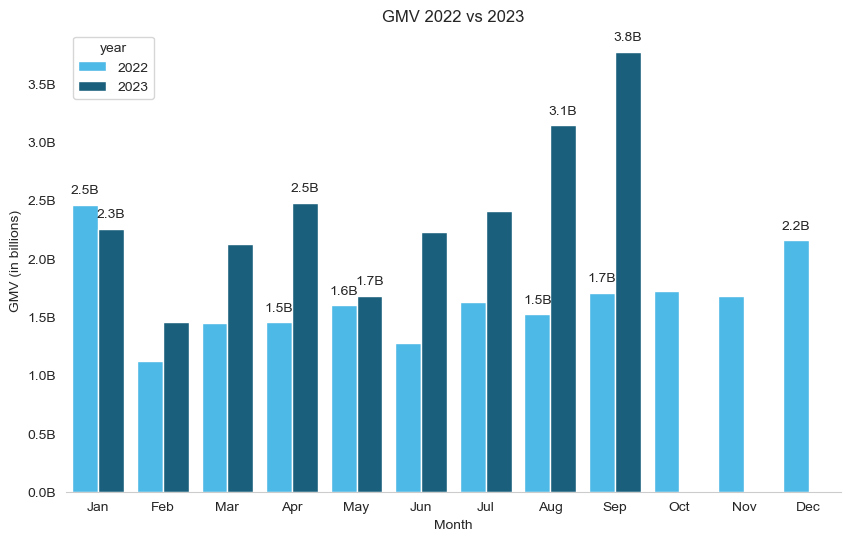

In [67]:
# Monthly GMV 2022 vs 2023
df_monthly_sales_22_23 = df_monthly_sales[df_monthly_sales['year'].isin([2022,2023])]
df_monthly_sales_22_23 = df_monthly_sales_22_23.sort_values(by='barcode_date')
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
ax1 = sns.barplot(data=df_monthly_sales_22_23, x='month', y='amount', hue='year', palette=['#33C4FF','#0A678D'])
ax1.yaxis.grid(False)
ax1.yaxis.set_major_formatter(FuncFormatter(billions_formatter))
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
months_to_label = ['Jan', 'Apr', 'Aug', 'Sep']
for i, p in enumerate(ax1.patches):
    month = df_monthly_sales_22_23['month'].iloc[i % len(months_to_label)]  # Use modulo to cycle through months_to_label
    if month in months_to_label:
        ax1.annotate(f'{p.get_height()/1e9:.1f}B', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title('GMV 2022 vs 2023')
plt.xlabel('Month')
plt.ylabel('GMV (in billions)')
plt.savefig(f'GMV 2022 vs 2023 {df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].dt.year.max()}.png')
plt.show()

In [68]:
df_monthly_sales.tail()

index barcode_date          amount  quantity month  year month_year  \
20     63   2023-05-31 1,680,115,055.5   8,531.0   May  2023   May-2023   
21     64   2023-06-30 2,227,733,621.8  12,666.5   Jun  2023   Jun-2023   
22     65   2023-07-31 2,410,035,206.2  13,056.5   Jul  2023   Jul-2023   
23     66   2023-08-31 3,139,561,475.8  16,437.0   Aug  2023   Aug-2023   
24     67   2023-09-30 3,771,659,953.2  20,410.0   Sep  2023   Sep-2023   

    amount_last_1_month  amount_growth_mtm  amount_last_12_month  \
20      2,477,472,298.0     -797,357,242.5       1,596,788,051.2   
21      1,680,115,055.5      547,618,566.2       1,276,162,606.2   
22      2,227,733,621.8      182,301,584.5       1,625,912,881.2   
23      2,410,035,206.2      729,526,269.5       1,520,177,960.0   
24      3,139,561,475.8      632,098,477.5       1,707,398,402.5   

    amount_growth_lym  quantity_last_1_month  quantity_growth_mtm  \
20       83,327,004.2               13,318.5             -4,787.5   
21      951,571,015.5                8,531.0              4,135.5   
22      784,122,325.0               12,666.5                390.0   
23    1,619,383,515.8               13,056.5              3,380.5   
24    2,064,261,550.8               16,437.0              3,973.0   

    quantity_last_12_month  quantity_growth_lym       amount_mat  \
20                 8,649.0               -118.0 21,681,044,745.5   
21                 6,787.5              5,879.0 22,632,615,761.0   
22                 8,465.5              4,591.0 23,416,738,086.0   
23                 7,766.0              8,671.0 25,036,121,601.8   
24                 8,888.0             11,522.0 27,100,383,152.5   

      amount_ly_mat  amount_growth_mat  quantity_mat  quantity_ly_mat  \
20 18,765,786,838.8    2,915,257,906.8     114,163.0        105,798.5   
21 18,638,491,445.0    3,994,124,316.0     120,042.0        104,611.5   
22 18,626,429,963.8    4,790,308,122.2     124,633.0        103,789.5   
23 18,615,257,298.8    6,420,864,303.0     133,304.0        102,873.0   
24 18,717,237,463.8    8,383,145,688.8     144,826.0        102,623.0   

    quantity_growth_mat       amount_ytd    amount_ly_ytd  amount_growth_ytd  \
20              8,364.5  9,994,702,119.5  8,083,710,888.8    1,910,991,230.8   
21             15,430.5 12,222,435,741.2  9,359,873,495.0    2,862,562,246.2   
22             20,843.5 14,632,470,947.5 10,985,786,376.2    3,646,684,571.2   
23             30,431.0 17,772,032,423.2 12,505,964,336.2    5,266,068,087.0   
24             42,203.0 21,543,692,376.5 14,213,362,738.8    7,330,329,637.8   

    quantity_ytd  quantity_ly_ytd  quantity_growth_ytd  \
20      53,239.0         44,190.5              9,048.5   
21      65,905.5         50,978.0             14,927.5   
22      78,962.0         59,443.5             19,518.5   
23      95,399.0         67,209.5             28,189.5   
24     115,809.0         76,097.5             39,711.5   

    amount_percent_growth_mtm  amount_percent_growth_lym  \
20                      -32.2                        5.2   
21                       32.6                       74.6   
22                        8.2                       48.2   
23                       30.3                      106.5   
24                       20.1                      120.9   

    amount_percent_growth_mat  amount_percent_growth_ytd  \
20                       15.5                       23.6   
21                       21.4                       30.6   
22                       25.7                       33.2   
23                       34.5                       42.1   
24                       44.8                       51.6   

    quantity_percent_growth_mtm  quantity_percent_growth_lym  \
20                        -35.9                         -1.4   
21                         48.5                         86.6   
22                          3.1                         54.2   
23                         25.9                        111.7   
24       

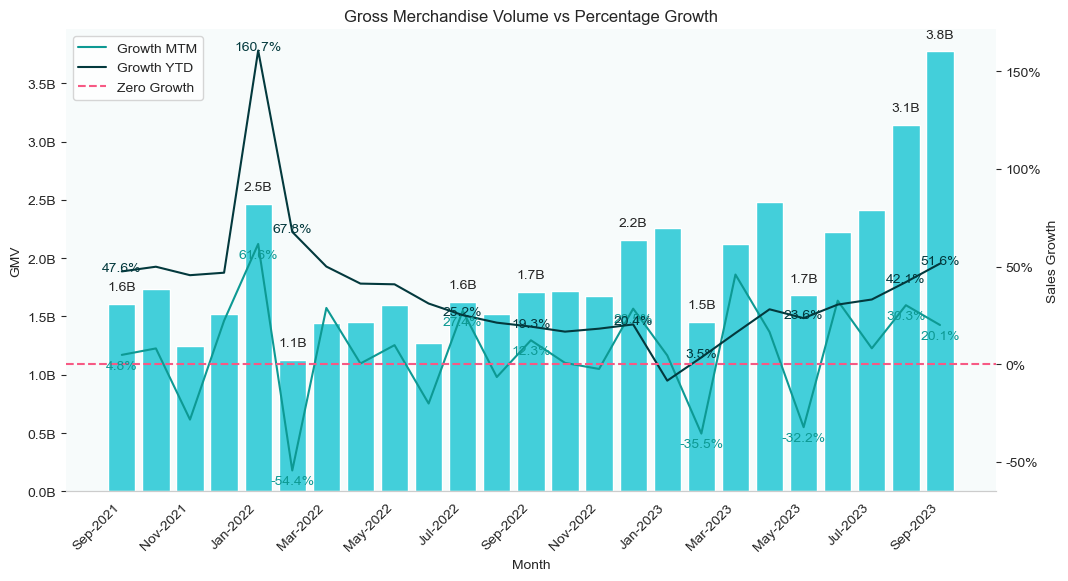

In [69]:
# Monthly GMV vs Growth mtm ytd
plt.figure(figsize=(12,6))
bar_color = '#2AE4F3'
background_color = '#F7FBFB'
line_1_color = '#0D9993'
line_2_color = '#03393D'

# bar chart
ax1 = sns.barplot(data=df_monthly_sales,x='month_year',y='amount',color=bar_color)
ax1.set_xticks(range(len(df_monthly_sales['month_year'])))
ax1.set_xticklabels(['' if i % 2 != 0 else label for i, label in enumerate(df_monthly_sales['month_year'])],
                    rotation=45, ha='right')
ax1.set_xlabel('Month')
ax1.set_ylabel('GMV')
ax1.yaxis.set_major_formatter(FuncFormatter(billions_formatter))
ax1.yaxis.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_facecolor(background_color) # Set background color

# line chart
ax2=ax1.twinx()
ax2.plot(df_monthly_sales['month_year'],df_monthly_sales['amount_percent_growth_mtm'],color=line_1_color, label='Growth MTM')
ax2.plot(df_monthly_sales['month_year'],df_monthly_sales['amount_percent_growth_ytd'],color=line_2_color, label='Growth YTD')
ax2.axhline(0, color='#F75984', linestyle='--', linewidth=1.5, label='Zero Growth')  # zero growth line
ax2.set_ylabel('Sales Growth')
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.yaxis.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.legend(loc='upper left')

# atributes data value label
label_indices = [0, 4, 5, 10, 12, 15, 20, 23, 24,17]
# bar chart
for i, mon in enumerate(df_monthly_sales['month_year']):
    if i in label_indices:
        ax1.annotate(f'{df_monthly_sales["amount"].iloc[i]/1e9:,.1f}B', (i, df_monthly_sales["amount"].iloc[i]),
                     textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Gross Merchandise Volume vs Percentage Growth')
# line chart
for i, (x, y1, y2) in enumerate(zip(df_monthly_sales['month_year'],
                                    df_monthly_sales['amount_percent_growth_mtm'],
                                    df_monthly_sales['amount_percent_growth_ytd'])):
    if i in label_indices:
        ax2.annotate(f'{y1:.1f}%', (x, y1), textcoords="offset points", xytext=(0,-10), ha='center', color=line_1_color)
        ax2.annotate(f'{y2:.1f}%', (x, y2), textcoords="offset points", xytext=(0,0), ha='center', color=line_2_color)

plt.savefig(f'GMV vs Growth {df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].dt.year.max()}.png')
plt.show()

#### Sales Volume (in pcs)

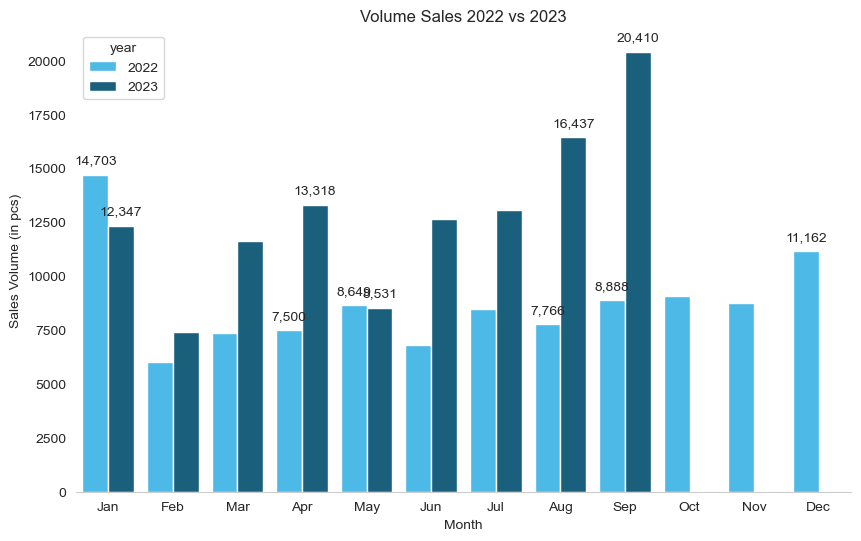

In [70]:
# Monthly Sales Chart 2022 vs 2023
df_monthly_sales_22_23 = df_monthly_sales[df_monthly_sales['year'].isin([2022,2023])]
df_monthly_sales_22_23 = df_monthly_sales_22_23.sort_values(by='barcode_date')
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
ax1 = sns.barplot(data=df_monthly_sales_22_23, x='month', y='quantity', hue='year', palette=['#33C4FF','#0A678D'])
ax1.yaxis.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
months_to_label = ['Jan', 'Apr', 'Aug', 'Sep']
for i, p in enumerate(ax1.patches):
    month = df_monthly_sales_22_23['month'].iloc[i % len(months_to_label)]  # Use modulo to cycle through months_to_label
    if month in months_to_label:
        ax1.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title('Volume Sales 2022 vs 2023')
plt.xlabel('Month')
plt.ylabel('Sales Volume (in pcs)')
plt.savefig(f'quantity 2022 vs 2023 {df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].dt.year.max()}.png')
plt.show()

In [71]:
df_monthly_sales.head(2)

index barcode_date          amount  quantity month  year month_year  \
0     43   2021-09-30 1,605,418,237.5   9,138.0   Sep  2021   Sep-2021   
1     44   2021-10-31 1,736,108,150.0  10,180.0   Oct  2021   Oct-2021   

   amount_last_1_month  amount_growth_mtm  amount_last_12_month  \
0      1,531,350,625.0       74,067,612.5       1,076,360,250.0   
1      1,605,418,237.5      130,689,912.5       1,028,459,687.5   

   amount_growth_lym  quantity_last_1_month  quantity_growth_mtm  \
0      529,057,987.5                8,682.5                455.5   
1      707,648,462.5                9,138.0              1,042.0   

   quantity_last_12_month  quantity_growth_lym       amount_mat  \
0                 6,123.0              3,015.0 15,015,022,575.0   
1                 5,762.5              4,417.5 15,722,671,037.5   

     amount_ly_mat  amount_growth_mat  quantity_mat  quantity_ly_mat  \
0 10,383,559,900.0    4,631,462,675.0      84,916.5         57,884.0   
1 10,465,549,587.5    5,257,121,450.0      89,334.0         59,063.5   

   quantity_growth_mat       amount_ytd   amount_ly_ytd  amount_growth_ytd  \
0             27,032.5 11,912,640,075.0 8,072,378,650.0    3,840,261,425.0   
1             30,270.5 13,648,748,225.0 9,100,838,337.5    4,547,909,887.5   

   quantity_ytd  quantity_ly_ytd  quantity_growth_ytd  \
0      67,451.5         45,618.0             21,833.5   
1      77,631.5         51,380.5             26,251.0   

   amount_percent_growth_mtm  amount_percent_growth_lym  \
0                        4.8                       49.2   
1                        8.1                       68.8   

   amount_percent_growth_mat  amount_percent_growth_ytd  \
0                       44.6                       47.6   
1                       50.2                       50.0   

   quantity_percent_growth_mtm  quantity_percent_growth_lym  \
0                          5.2                         49.2   
1                         11.4                         76.7   

   quantity_percent_growth_mat  quantity_percent_growth_ytd  
0                         46.7                         47.9  
1                         51.3                         51.1

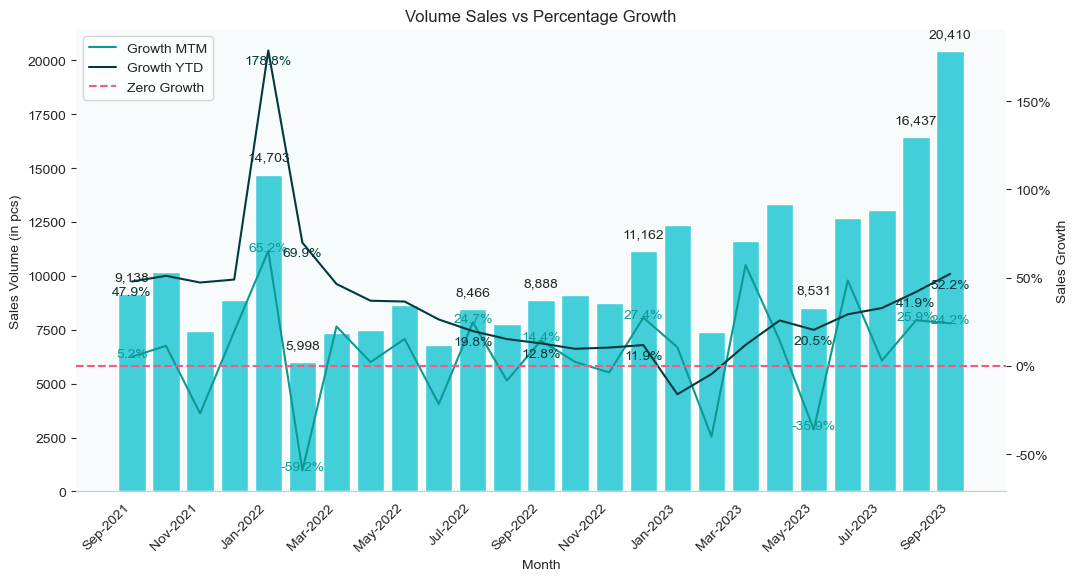

In [72]:
plt.figure(figsize=(12,6))
bar_color = '#2AE4F3'
background_color = '#F7FBFB'
line_1_color = '#0D9993'
line_2_color = '#03393D'

# bar chart
ax1 = sns.barplot(data=df_monthly_sales,x='month_year',y='quantity',color=bar_color)
ax1.set_xticks(range(len(df_monthly_sales['month_year'])))
ax1.set_xticklabels(['' if i % 2 != 0 else label for i, label in enumerate(df_monthly_sales['month_year'])],
                    rotation=45, ha='right')
ax1.set_xlabel('Month')
ax1.set_ylabel('Sales Volume (in pcs)')
ax1.yaxis.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_facecolor(background_color) # Set background color

# line chart
ax2=ax1.twinx()
ax2.plot(df_monthly_sales['month_year'],df_monthly_sales['quantity_percent_growth_mtm'],color=line_1_color, label='Growth MTM')
ax2.plot(df_monthly_sales['month_year'],df_monthly_sales['quantity_percent_growth_ytd'],color=line_2_color, label='Growth YTD')
ax2.axhline(0, color='#F75984', linestyle='--', linewidth=1.5, label='Zero Growth')  # zero growth line
ax2.set_ylabel('Sales Growth')
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.yaxis.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.legend(loc='upper left')

# atributes data value label
label_indices = [0, 4, 5, 10, 12, 15, 20, 23, 24]
# bar chart
for i, mon in enumerate(df_monthly_sales['month_year']):
    if i in label_indices:
        ax1.annotate(f'{df_monthly_sales["quantity"].iloc[i]:,.0f}', (i, df_monthly_sales["quantity"].iloc[i]),
                     textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Volume Sales vs Percentage Growth')
# line chart
for i, (x, y1, y2) in enumerate(zip(df_monthly_sales['month_year'],
                                    df_monthly_sales['quantity_percent_growth_mtm'],
                                    df_monthly_sales['quantity_percent_growth_ytd'])):
    if i in label_indices:
        ax2.annotate(f'{y1:.1f}%', (x, y1), textcoords="offset points", xytext=(0,0), ha='center', color=line_1_color)
        ax2.annotate(f'{y2:.1f}%', (x, y2), textcoords="offset points", xytext=(0,-10), ha='center', color=line_2_color)
plt.savefig(f'quantity vs Growth {df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].dt.year.max()}.png')
plt.show()

<Axes: xlabel='month_year', ylabel='quantity'>

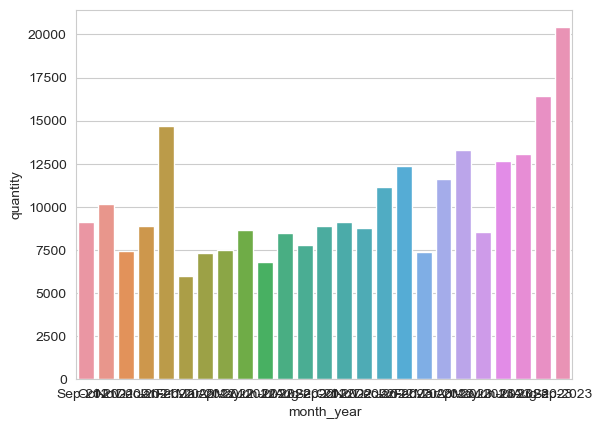

In [73]:
sns.barplot(data=df_monthly_sales,x='month_year',y='quantity')

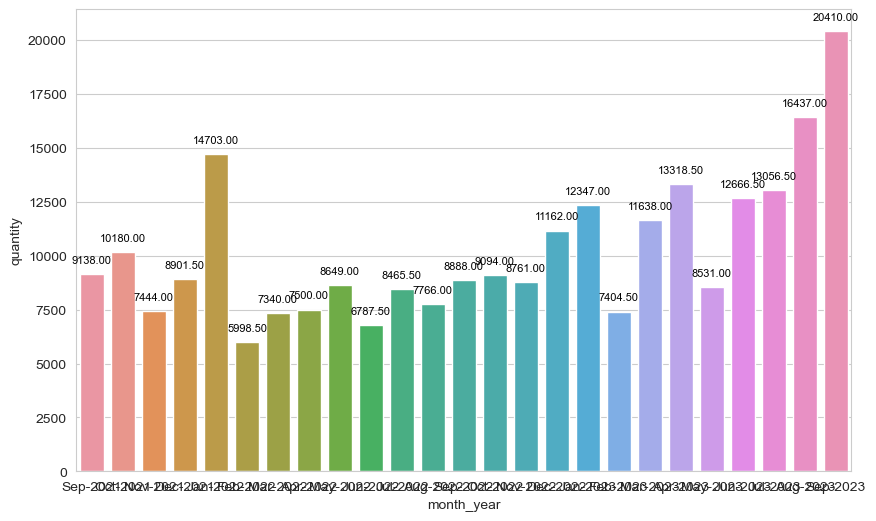

In [74]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_monthly_sales, x='month_year', y='quantity')

# Menambahkan label nilai pada setiap batang
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=8, color='black')

# Menampilkan plot
plt.show()

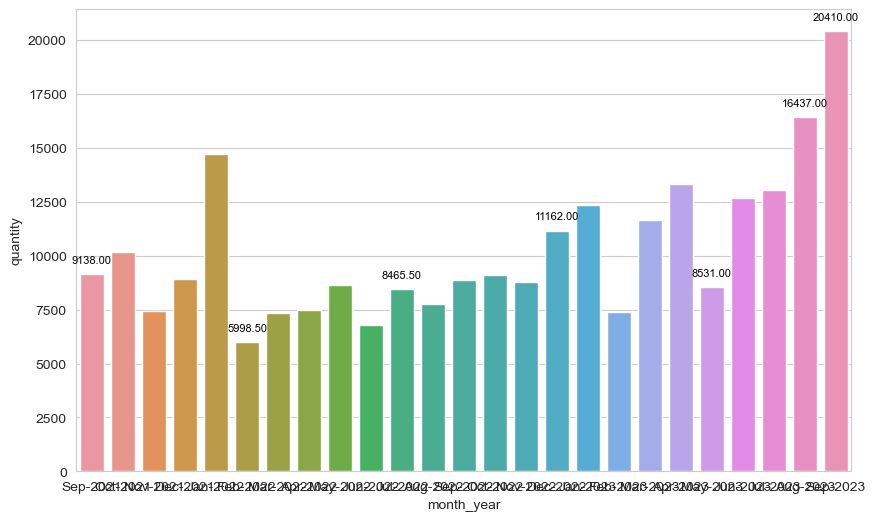

In [75]:
# Membuat plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_monthly_sales, x='month_year', y='quantity')

# Menentukan indeks batang yang akan diberi label
selected_indices = [0, 5, 10, 15, 20, 23, 24]

# Menambahkan label nilai pada batang yang dipilih
for i, p in enumerate(ax.patches):
    if i in selected_indices:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), 
                    textcoords='offset points', fontsize=8, color='black')

# Menampilkan plot
plt.show()

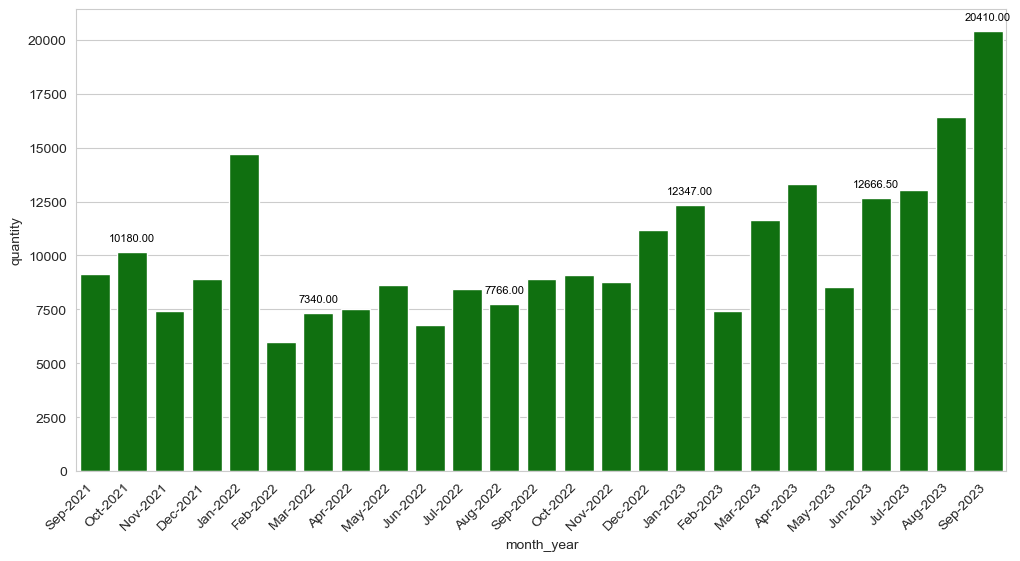

In [76]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_monthly_sales, x='month_year', y='quantity', color='green')

# Menambahkan label nilai pada batang yang diinginkan
highlighted_indices = [1, 6, 11, 16, 21, 24, 25]
for i, p in enumerate(ax.patches):
    if i in highlighted_indices:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), 
                    textcoords='offset points', fontsize=8, color='black')

# Menyesuaikan label x-axis menjadi miring 45 derajat
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Menampilkan plot
plt.show()

### c. Quarterly Sales Performance
#### Table
it is usefull for this analysis, excel reporting, and visualisation (power bi / tableu)

In [77]:
# quarterly growth percentage
# aggregate quarterly sales
quarterly_sales = df_sales.resample('Q', on='barcode_date')['amount','quantity'].sum().reset_index()
quarterly_sales['quarter'] = 'q'+quarterly_sales['barcode_date'].dt.quarter.astype(str)
quarterly_sales['year'] = quarterly_sales['barcode_date'].dt.year
quarterly_sales['quarter_year'] = quarterly_sales['quarter']+'-'+quarterly_sales['year'].astype(str)

# sales growth
quarterly_sales['amount_last_quarter'] = quarterly_sales['amount'].shift(1) # amount in last quarter
quarterly_sales['amount_growth_qtq'] = quarterly_sales['amount'].diff() # quarter-to-quarter
quarterly_sales['amount_last_4_quarter'] = quarterly_sales['amount'].shift(4) # amount in last 4 quarter
quarterly_sales['amount_growth_lyq'] = quarterly_sales['amount'].diff(periods=4) # last year-quarter
quarterly_sales['amount_growth_qtq'].fillna(0, inplace=True) # quarter-to-quarter
quarterly_sales['amount_growth_lyq'].fillna(0, inplace=True) # last year-quarter
quarterly_sales['quantity_last_quarter'] = quarterly_sales['quantity'].shift(1) # amount in last quarter
quarterly_sales['quantity_growth_qtq'] = quarterly_sales['quantity'].diff() # quarter-to-quarter
quarterly_sales['quantity_last_4_quarter'] = quarterly_sales['quantity'].shift(4) # amount in last 4 quarter
quarterly_sales['quantity_growth_lyq'] = quarterly_sales['quantity'].diff(periods=4) # last year-quarter
quarterly_sales['quantity_growth_qtq'].fillna(0, inplace=True) # quarter-to-quarter
quarterly_sales['quantity_growth_lyq'].fillna(0, inplace=True) # last year-quarter

# percentage sales growth
quarterly_sales['amount_growth_percent_qtq'] = (quarterly_sales['amount'].pct_change() * 100).fillna(0)
quarterly_sales['amount_growth_percent_lyq'] = (quarterly_sales['amount'].pct_change(periods=4) * 100).fillna(0)
quarterly_sales['quantity_growth_percent_qtq'] = (quarterly_sales['quantity'].pct_change() * 100).fillna(0)
quarterly_sales['quantity_growth_percent_lyq'] = (quarterly_sales['quantity'].pct_change(periods=4) * 100).fillna(0)

# Display as dataframe
df_quarterly_sales = quarterly_sales.tail(13).reset_index()
df_quarterly_sales.to_csv(f'df_quarterly_sales_performance_{df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].dt.year.max()}.csv')
df_quarterly_sales

index barcode_date          amount  quantity quarter  year quarter_year  \
0      10   2020-09-30 3,166,161,337.5  18,014.0      q3  2020      q3-2020   
1      11   2020-12-31 3,102,382,500.0  17,465.0      q4  2020      q4-2020   
2      12   2021-03-31 3,354,011,500.0  19,144.0      q1  2021      q1-2021   
3      13   2021-06-30 3,783,885,350.0  21,199.5      q2  2021      q2-2021   
4      14   2021-09-30 4,774,743,225.0  27,108.0      q3  2021      q3-2021   
5      15   2021-12-31 4,503,874,725.0  26,525.5      q4  2021      q4-2021   
6      16   2022-03-31 5,032,937,700.0  28,041.5      q1  2022      q1-2022   
7      17   2022-06-30 4,326,935,795.0  22,936.5      q2  2022      q2-2022   
8      18   2022-09-30 4,853,489,243.8  25,119.5      q3  2022      q3-2022   
9      19   2022-12-31 5,556,690,776.0  29,017.0      q4  2022      q4-2022   
10     20   2023-03-31 5,837,114,766.0  31,389.5      q1  2023      q1-2023   
11     21   2023-06-30 6,385,320,975.2  34,516.0      q2  2023      q2-2023   
12     22   2023-09-30 9,321,256,635.2  49,903.5      q3  2023      q3-2023   

    amount_last_quarter  amount_growth_qtq  amount_last_4_quarter  \
0       2,846,666,812.5      319,494,525.0        2,553,262,250.0   
1       3,166,161,337.5      -63,778,837.5        2,311,181,250.0   
2       3,102,382,500.0      251,629,000.0        2,059,550,500.0   
3       3,354,011,500.0      429,873,850.0        2,846,666,812.5   
4       3,783,885,350.0      990,857,875.0        3,166,161,337.5   
5       4,774,743,225.0     -270,868,500.0        3,102,382,500.0   
6       4,503,874,725.0      529,062,975.0        3,354,011,500.0   
7       5,032,937,700.0     -706,001,905.0        3,783,885,350.0   
8       4,326,935,795.0      526,553,448.8        4,774,743,225.0   
9       4,853,489,243.8      703,201,532.2        4,503,874,725.0   
10      5,556,690,776.0      280,423,990.0        5,032,937,700.0   
11      5,837,114,766.0      548,206,209.2        4,326,935,795.0   
12      6,385,320,975.2    2,935,935,660.0        4,853,489,243.8   

    amount_growth_lyq  quantity_last_quarter  quantity_growth_qtq  \
0       612,899,087.5               16,069.0              1,945.0   
1       791,201,250.0               18,014.0               -549.0   
2     1,294,461,000.0               17,465.0              1,679.0   
3       937,218,537.5               19,144.0              2,055.5   
4     1,608,581,887.5               21,199.5              5,908.5   
5     1,401,492,225.0               27,108.0               -582.5   
6     1,678,926,200.0               26,525.5              1,516.0   
7       543,050,445.0               28,041.5             -5,105.0   
8        78,746,018.8               22,936.5              2,183.0   
9     1,052,816,051.0               25,119.5              3,897.5   
10      804,177,066.0               29,017.0              2,372.5   
11    2,058,385,180.2               31,389.5              3,126.5   
12    4,467,767,391.5               34,516.0             15,387.5   

    quantity_last_4_quarter  quantity_growth_lyq  amount_growth_percent_qtq  \
0                  13,801.0              4,213.0                       11.2   
1                  12,266.0              5,199.0                       -2.0   
2                  11,535.0              7,609.0                        8.1   
3                  16,069.0              5,130.5                       12.8   
4                  18,014.0              9,094.0                       26.2   
5                  17,465.0              9,060.5                       -5.7   
6                  19,144.0              8,897.5                       11.7   
7                  21,199.5              1,737.0                      -14.0   
8                  27,108.0             -1,988.5                       12.2   
9                  26,525.5              2,491.5                       14.5   
10                 28,041.5              3,348.0                        5.0   
11             

#### Chart Gross Merchandise Volume

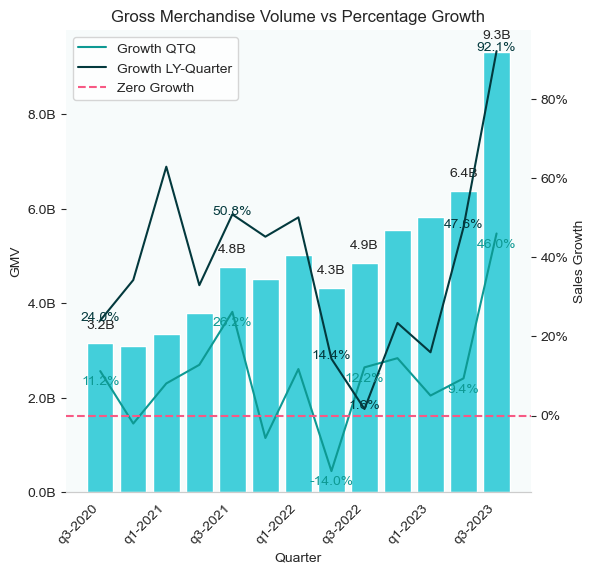

In [78]:
# GMV Quarterly
plt.figure(figsize=(6,6))
bar_color = '#2AE4F3'
background_color = '#F7FBFB'
line_1_color = '#0D9993'
line_2_color = '#03393D'

# bar chart
ax1 = sns.barplot(data=df_quarterly_sales,x='quarter_year',y='amount',color=bar_color)
ax1.set_xticks(range(len(df_quarterly_sales['quarter_year'])))
ax1.set_xticklabels(['' if i % 2 != 0 else label for i, label in enumerate(df_quarterly_sales['quarter_year'])],
                    rotation=45, ha='right')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('GMV')
ax1.yaxis.set_major_formatter(FuncFormatter(billions_formatter))
ax1.yaxis.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_facecolor(background_color) # Set background color

# line chart
ax2=ax1.twinx()
ax2.plot(df_quarterly_sales['quarter_year'],df_quarterly_sales['amount_growth_percent_qtq'],
         color=line_1_color,label='Growth QTQ')
ax2.plot(df_quarterly_sales['quarter_year'],df_quarterly_sales['amount_growth_percent_lyq'],
         color=line_2_color,label='Growth LY-Quarter')
ax2.axhline(0, color='#F75984', linestyle='--', linewidth=1.5, label='Zero Growth')  # zero growth line
ax2.set_ylabel('Sales Growth')
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.yaxis.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.legend(loc='upper left')

# atributes data value label
label_indices = [0, 4, 7, 8, 11, 12]
# bar chart
for i, mon in enumerate(df_quarterly_sales['quarter_year']):
    if i in label_indices:
        ax1.annotate(f'{df_quarterly_sales["amount"].iloc[i]/1e9:,.1f}B', (i, df_quarterly_sales["amount"].iloc[i]),
                     textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Gross Merchandise Volume vs Percentage Growth')
# line chart
for i, (x, y1, y2) in enumerate(zip(df_quarterly_sales['quarter_year'],
                                    df_quarterly_sales['amount_growth_percent_qtq'],
                                    df_quarterly_sales['amount_growth_percent_lyq'])):
    if i in label_indices:
        ax2.annotate(f'{y1:.1f}%', (x, y1), textcoords="offset points", xytext=(0,-10), ha='center', color=line_1_color)
        ax2.annotate(f'{y2:.1f}%', (x, y2), textcoords="offset points", xytext=(0,0), ha='center', color=line_2_color)
plt.savefig(f'GMV vs Growth Q{df_sales["barcode_date"].max().quarter}_{df_sales["barcode_date"].dt.year.max()}.png')
plt.show()

#### Sales Volume

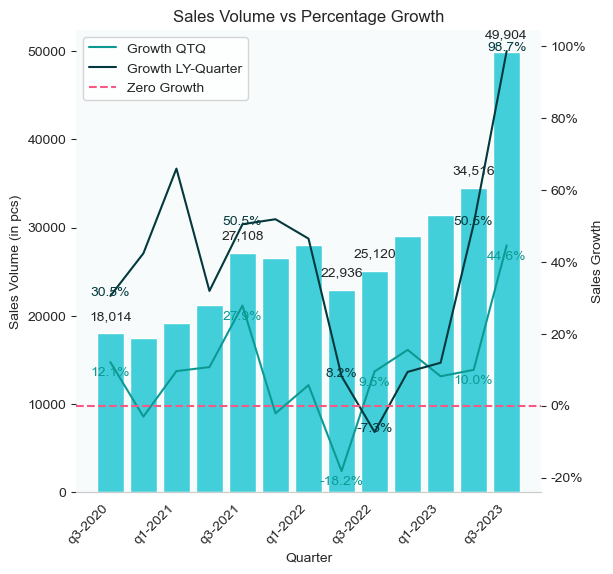

In [79]:
# Volume Sales Quarterly
plt.figure(figsize=(6,6))
bar_color = '#2AE4F3'
background_color = '#F7FBFB'
line_1_color = '#0D9993'
line_2_color = '#03393D'

# bar chart
ax1 = sns.barplot(data=df_quarterly_sales,x='quarter_year',y='quantity',color=bar_color)
ax1.set_xticks(range(len(df_quarterly_sales['quarter_year'])))
ax1.set_xticklabels(['' if i % 2 != 0 else label for i, label in enumerate(df_quarterly_sales['quarter_year'])],
                    rotation=45, ha='right')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Sales Volume (in pcs)')
ax1.yaxis.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_facecolor(background_color) # Set background color

# line chart
ax2=ax1.twinx()
ax2.plot(df_quarterly_sales['quarter_year'],df_quarterly_sales['quantity_growth_percent_qtq'],
         color=line_1_color,label='Growth QTQ')
ax2.plot(df_quarterly_sales['quarter_year'],df_quarterly_sales['quantity_growth_percent_lyq'],
         color=line_2_color,label='Growth LY-Quarter')
ax2.axhline(0, color='#F75984', linestyle='--', linewidth=1.5, label='Zero Growth')  # zero growth line
ax2.set_ylabel('Sales Growth')
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.yaxis.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.legend(loc='upper left')

# atributes data value label
label_indices = [0, 4, 7, 8, 11, 12]
# bar chart
for i, mon in enumerate(df_quarterly_sales['quarter_year']):
    if i in label_indices:
        ax1.annotate(f'{df_quarterly_sales["quantity"].iloc[i]:,.0f}', (i, df_quarterly_sales["quantity"].iloc[i]),
                     textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Sales Volume vs Percentage Growth')
# line chart
for i, (x, y1, y2) in enumerate(zip(df_quarterly_sales['quarter_year'],
                                    df_quarterly_sales['quantity_growth_percent_qtq'],
                                    df_quarterly_sales['quantity_growth_percent_lyq'])):
    if i in label_indices:
        ax2.annotate(f'{y1:.1f}%', (x, y1), textcoords="offset points", xytext=(0,-10), ha='center', color=line_1_color)
        ax2.annotate(f'{y2:.1f}%', (x, y2), textcoords="offset points", xytext=(0,0), ha='center', color=line_2_color)
plt.savefig(f'quantity vs Growth Q{df_sales["barcode_date"].max().quarter}_{df_sales["barcode_date"].dt.year.max()}.png')
plt.show()

### 4. Sales Performance per SKU

In [80]:
df_sales.head(2)

invoice sales_id sales_agent        level distibutor agent reseller  \
0   K1925      116      Anna R     Reseller       HAYA  KRIS      NaN   
1   K1926      121      M Herm  Distributor        NaN   NaN      NaN   

  customer_email customer_hp cutomer_name barcode_date  subdistrict  district  \
0            NaN         NaN          NaN   2018-02-02      Rungkut  Surabaya   
1            NaN         NaN          NaN   2018-02-02  Balongbendo  Sidoarjo   

     province          product  box  pack    amount   buyer_type  quantity  \
0  Jawa Timur  ALGATEA REGULER    2     0 358,750.0  sales agent       2.0   
1  Jawa Timur  ALGATEA REGULER    2     0 315,000.0  sales agent       2.0   

    brand main_sku  month  year month_year  
0  health      Tea      2  2018    2018-02  
1  health      Tea      2  2018    2018-02

In [81]:
sku = df_sales['main_sku'].unique()
sku

array(['Tea', 'Chocolate', 'other', 'Cereal', 'Coffee', 'Rice',
       'Body Care', 'Ointment', 'Beauty Care'], dtype=object)

#### Sales Performance SKU Tea

In [82]:
df_tea_monthly = dataset_monthly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Tea')
df_tea_monthly

index barcode_date        amount month  year month_year      amount_ytd  \
0      43   2021-09-30 252,264,250.0   Sep  2021   Sep-2021 2,194,238,375.0   
1      44   2021-10-31 234,661,000.0   Oct  2021   Oct-2021 2,428,899,375.0   
2      45   2021-11-30 161,883,750.0   Nov  2021   Nov-2021 2,590,783,125.0   
3      46   2021-12-31 196,964,250.0   Dec  2021   Dec-2021 2,787,747,375.0   
4      47   2022-01-31 404,230,750.0   Jan  2022   Jan-2022   404,230,750.0   
5      48   2022-02-28 165,416,125.0   Feb  2022   Feb-2022   569,646,875.0   
6      49   2022-03-31 221,484,375.0   Mar  2022   Mar-2022   791,131,250.0   
7      50   2022-04-30 224,490,000.0   Apr  2022   Apr-2022 1,015,621,250.0   
8      51   2022-05-31 206,841,075.0   May  2022   May-2022 1,222,462,325.0   
9      52   2022-06-30 182,690,375.0   Jun  2022   Jun-2022 1,405,152,700.0   
10     53   2022-07-31 255,100,475.0   Jul  2022   Jul-2022 1,660,253,175.0   
11     54   2022-08-31 252,604,012.5   Aug  2022   Aug-2022 1,912,857,187.5   
12     55   2022-09-30 261,979,637.5   Sep  2022   Sep-2022 2,174,836,825.0   
13     56   2022-10-31 286,164,917.5   Oct  2022   Oct-2022 2,461,001,742.5   
14     57   2022-11-30 269,421,040.0   Nov  2022   Nov-2022 2,730,422,782.5   
15     58   2022-12-31 384,965,350.0   Dec  2022   Dec-2022 3,115,388,132.5   
16     59   2023-01-31 390,209,977.5   Jan  2023   Jan-2023   390,209,977.5   
17     60   2023-02-28 262,106,337.5   Feb  2023   Feb-2023   652,316,315.0   
18     61   2023-03-31 366,076,987.5   Mar  2023   Mar-2023 1,018,393,302.5   
19     62   2023-04-30 461,322,050.0   Apr  2023   Apr-2023 1,479,715,352.5   
20     63   2023-05-31 277,660,687.5   May  2023   May-2023 1,757,376,040.0   
21     64   2023-06-30 413,924,262.5   Jun  2023   Jun-2023 2,171,300,302.5   
22     65   2023-07-31 442,548,627.5   Jul  2023   Jul-2023 2,613,848,930.0   
23     66   2023-08-31 603,478,312.5   Aug  2023   Aug-2023 3,217,327,242.5   
24     67   2023-09-30 680,681,522.5   Sep  2023   Sep-2023 3,898,008,765.0   

    amount_percent_growth_mtm  amount_percent_growth_ytd  
0                        -8.5                       11.7  
1                        -7.0                       12.1  
2                       -31.0                        7.2  
3                        21.7                        6.7  
4                       105.2                       79.5  
5                       -59.1                       16.2  
6                        33.9                        7.7  
7                         1.4                        7.0  
8                        -7.9                        5.3  
9                       -11.7                        0.7  
10                       39.6                       -0.4  
11                       -1.0                       -1.5  
12                        3.7                       -0.9  
13                        9.2                        1.3  
14                       -5.9                        5.4  
15                       42.9                       11.8  
16                        1.4                       -3.5  
17                      -32.8                       14.5  
18                       39.7                       28.7  
19                       26.0                       45.7  
20                      -39.8                       43.8  
21                       49.1                       54.5  
22                        6.9                       57.4  
23                       36.4                       68.2  
24                       12.8                       79.2

In [83]:
df_tea_quarterly = dataset_quarterly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Tea')
df_tea_quarterly

index barcode_date          amount quarter  year quarter_year  \
0      10   2020-09-30   794,351,250.0      q3  2020      q3-2020   
1      11   2020-12-31   648,492,250.0      q4  2020      q4-2020   
2      12   2021-03-31   734,771,625.0      q1  2021      q1-2021   
3      13   2021-06-30   660,780,750.0      q2  2021      q2-2021   
4      14   2021-09-30   798,686,000.0      q3  2021      q3-2021   
5      15   2021-12-31   593,509,000.0      q4  2021      q4-2021   
6      16   2022-03-31   791,131,250.0      q1  2022      q1-2022   
7      17   2022-06-30   614,021,450.0      q2  2022      q2-2022   
8      18   2022-09-30   769,684,125.0      q3  2022      q3-2022   
9      19   2022-12-31   940,551,307.5      q4  2022      q4-2022   
10     20   2023-03-31 1,018,393,302.5      q1  2023      q1-2023   
11     21   2023-06-30 1,152,907,000.0      q2  2023      q2-2023   
12     22   2023-09-30 1,726,708,462.5      q3  2023      q3-2023   

    amount_percent_growth_qtq  amount_percent_growth_lyq  
0                        13.2                       17.2  
1                       -18.4                      -17.0  
2                        13.3                       57.1  
3                       -10.1                       -5.8  
4                        20.9                        0.5  
5                       -25.7                       -8.5  
6                        33.3                        7.7  
7                       -22.4                       -7.1  
8                        25.4                       -3.6  
9                        22.2                       58.5  
10                        8.3                       28.7  
11                       13.2                       87.8  
12                       49.8                      124.3

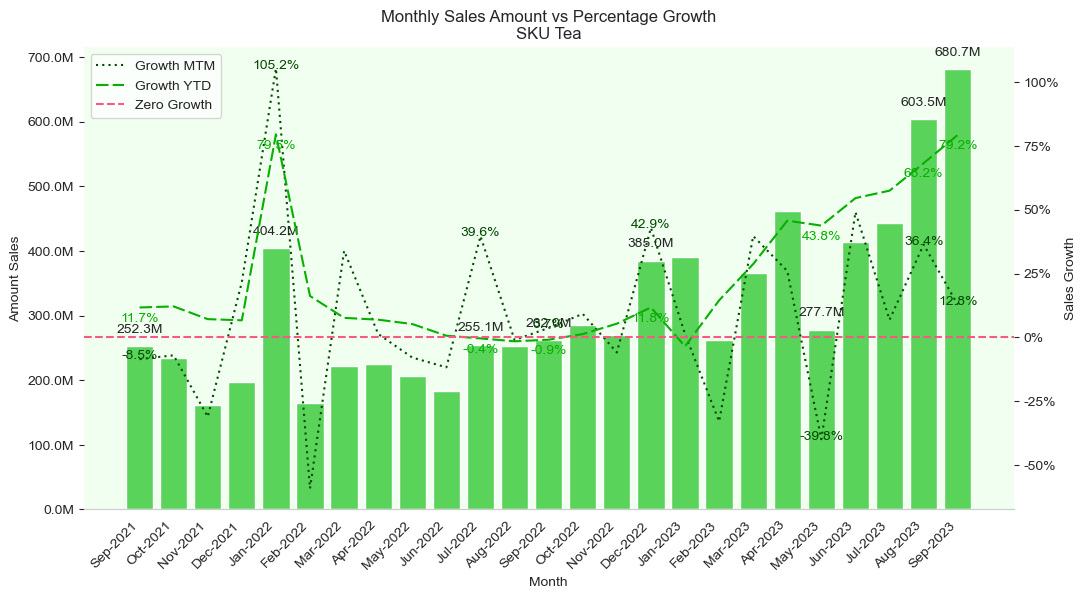

In [84]:
# monthly GMV for SKU tea
chart_monthly_amount_by_condition(
    df=df_sales,
    bar_color='#44E844',
    line_1_color='#07AF00',
    line_2_color='#034900',
    background_color='#F0FFF0',
    col_condition='main_sku',
    condition='Tea')

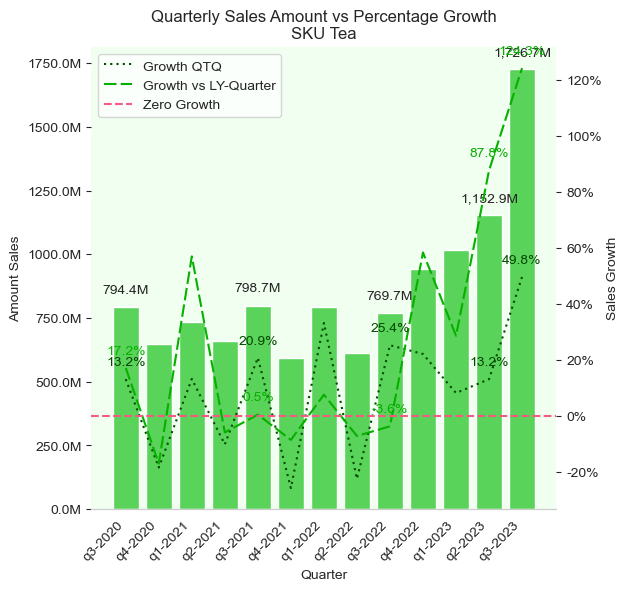

In [85]:
# Quarterly GMV SKU Tea 
chart_quarterly_amount_by_condition(
    df=df_sales,
    bar_color='#44E844',
    line_1_color='#07AF00',
    line_2_color='#034900',
    background_color='#F0FFF0',
    col_condition='main_sku',
    condition='Tea')

#### Sales Performance SKU Chocolate

In [86]:
sku

array(['Tea', 'Chocolate', 'other', 'Cereal', 'Coffee', 'Rice',
       'Body Care', 'Ointment', 'Beauty Care'], dtype=object)

In [87]:
df_chocolate_monthly = dataset_monthly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Chocolate')
df_chocolate_monthly

index barcode_date        amount month  year month_year      amount_ytd  \
0      43   2021-09-30 128,222,500.0   Sep  2021   Sep-2021   862,538,250.0   
1      44   2021-10-31 114,905,000.0   Oct  2021   Oct-2021   977,443,250.0   
2      45   2021-11-30 113,286,250.0   Nov  2021   Nov-2021 1,090,729,500.0   
3      46   2021-12-31 139,807,500.0   Dec  2021   Dec-2021 1,230,537,000.0   
4      47   2022-01-31 206,998,750.0   Jan  2022   Jan-2022   206,998,750.0   
5      48   2022-02-28 131,624,500.0   Feb  2022   Feb-2022   338,623,250.0   
6      49   2022-03-31 120,427,125.0   Mar  2022   Mar-2022   459,050,375.0   
7      50   2022-04-30 113,382,500.0   Apr  2022   Apr-2022   572,432,875.0   
8      51   2022-05-31 109,036,637.5   May  2022   May-2022   681,469,512.5   
9      52   2022-06-30  89,185,232.5   Jun  2022   Jun-2022   770,654,745.0   
10     53   2022-07-31 103,242,300.0   Jul  2022   Jul-2022   873,897,045.0   
11     54   2022-08-31  94,791,462.5   Aug  2022   Aug-2022   968,688,507.5   
12     55   2022-09-30  97,568,905.0   Sep  2022   Sep-2022 1,066,257,412.5   
13     56   2022-10-31 114,533,772.5   Oct  2022   Oct-2022 1,180,791,185.0   
14     57   2022-11-30 110,027,837.5   Nov  2022   Nov-2022 1,290,819,022.5   
15     58   2022-12-31 141,989,750.0   Dec  2022   Dec-2022 1,432,808,772.5   
16     59   2023-01-31 133,814,117.5   Jan  2023   Jan-2023   133,814,117.5   
17     60   2023-02-28  79,637,915.0   Feb  2023   Feb-2023   213,452,032.5   
18     61   2023-03-31 131,240,060.0   Mar  2023   Mar-2023   344,692,092.5   
19     62   2023-04-30 124,627,387.5   Apr  2023   Apr-2023   469,319,480.0   
20     63   2023-05-31  75,656,455.0   May  2023   May-2023   544,975,935.0   
21     64   2023-06-30  92,108,012.5   Jun  2023   Jun-2023   637,083,947.5   
22     65   2023-07-31  89,515,212.5   Jul  2023   Jul-2023   726,599,160.0   
23     66   2023-08-31 113,734,197.5   Aug  2023   Aug-2023   840,333,357.5   
24     67   2023-09-30 136,589,040.0   Sep  2023   Sep-2023   976,922,397.5   

    amount_percent_growth_mtm  amount_percent_growth_ytd  
0                        17.6                        4.7  
1                       -10.4                        5.2  
2                        -1.4                        3.5  
3                        23.4                        7.5  
4                        48.1                      220.7  
5                       -36.4                      131.3  
6                        -8.5                      115.8  
7                        -5.8                       70.1  
8                        -3.8                       58.7  
9                       -18.2                       47.9  
10                       15.8                       39.8  
11                       -8.2                       31.9  
12                        2.9                       23.6  
13                       17.4                       20.8  
14                       -3.9                       18.3  
15                       29.0                       16.4  
16                       -5.8                      -35.4  
17                      -40.5                      -37.0  
18                       64.8                      -24.9  
19                       -5.0                      -18.0  
20                      -39.3                      -20.0  
21                       21.7                      -17.3  
22                       -2.8                      -16.9  
23                       27.1                      -13.3  
24                       20.1                       -8.4

In [88]:
df_chocolate_quarterly = dataset_quarterly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Chocolate')
df_chocolate_quarterly

index barcode_date        amount quarter  year quarter_year  \
0      10   2020-09-30 268,103,500.0      q3  2020      q3-2020   
1      11   2020-12-31 320,318,250.0      q4  2020      q4-2020   
2      12   2021-03-31 212,674,000.0      q1  2021      q1-2021   
3      13   2021-06-30 308,308,000.0      q2  2021      q2-2021   
4      14   2021-09-30 341,556,250.0      q3  2021      q3-2021   
5      15   2021-12-31 367,998,750.0      q4  2021      q4-2021   
6      16   2022-03-31 459,050,375.0      q1  2022      q1-2022   
7      17   2022-06-30 311,604,370.0      q2  2022      q2-2022   
8      18   2022-09-30 295,602,667.5      q3  2022      q3-2022   
9      19   2022-12-31 366,551,360.0      q4  2022      q4-2022   
10     20   2023-03-31 344,692,092.5      q1  2023      q1-2023   
11     21   2023-06-30 292,391,855.0      q2  2023      q2-2023   
12     22   2023-09-30 339,838,450.0      q3  2023      q3-2023   

    amount_percent_growth_qtq  amount_percent_growth_lyq  
0                         4.8                        5.9  
1                        19.5                       27.1  
2                       -33.6                      -29.1  
3                        45.0                       20.5  
4                        10.8                       27.4  
5                         7.7                       14.9  
6                        24.7                      115.8  
7                       -32.1                        1.1  
8                        -5.1                      -13.5  
9                        24.0                       -0.4  
10                       -6.0                      -24.9  
11                      -15.2                       -6.2  
12                       16.2                       15.0

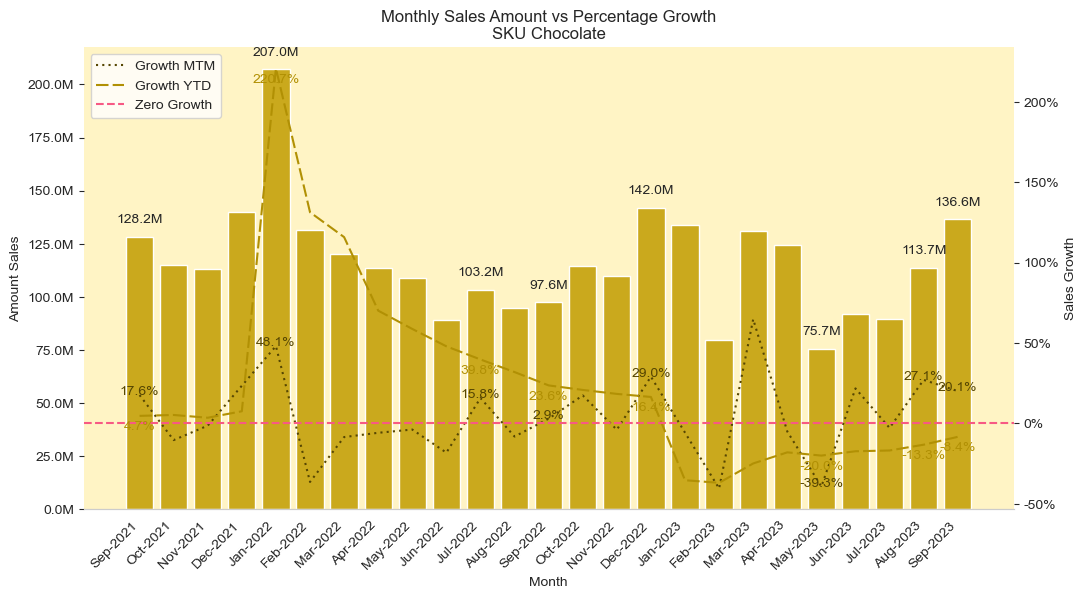

In [89]:
# monthly GMV for SKU Chocolate
chart_monthly_amount_by_condition(
    df=df_sales,
    bar_color='#E7BB00',
    line_1_color='#B19004',
    line_2_color='#564602',
    background_color='#FFF4C5',
    col_condition='main_sku',
    condition='Chocolate')

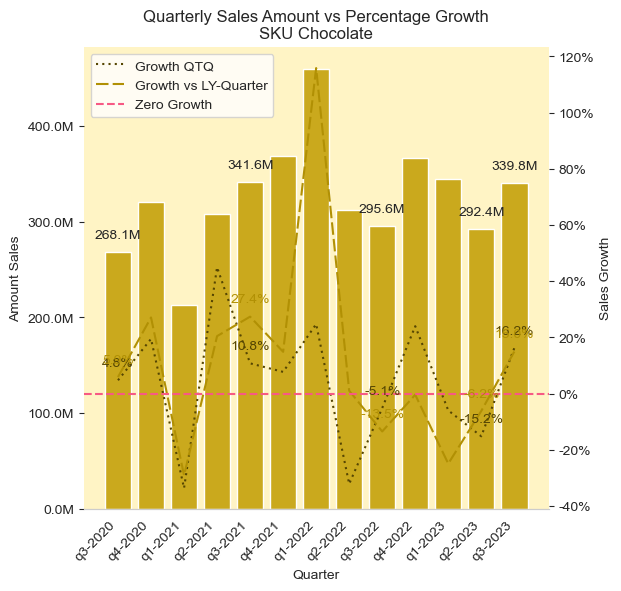

In [90]:
# Quarterly GMV SKU Chocolate
chart_quarterly_amount_by_condition(
    df=df_sales,
    bar_color='#E7BB00',
    line_1_color='#B19004',
    line_2_color='#564602',
    background_color='#FFF4C5',
    col_condition='main_sku',
    condition='Chocolate')

#### Sales Performance SKU Cereal

In [91]:
sku

array(['Tea', 'Chocolate', 'other', 'Cereal', 'Coffee', 'Rice',
       'Body Care', 'Ointment', 'Beauty Care'], dtype=object)

In [92]:
df_cereal_monthly = dataset_monthly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Cereal')
df_cereal_monthly

index barcode_date          amount month  year month_year  \
0      43   2021-09-30 1,129,821,000.0   Sep  2021   Sep-2021   
1      44   2021-10-31 1,309,397,250.0   Oct  2021   Oct-2021   
2      45   2021-11-30   903,094,500.0   Nov  2021   Nov-2021   
3      46   2021-12-31 1,055,850,250.0   Dec  2021   Dec-2021   
4      47   2022-01-31 1,656,807,250.0   Jan  2022   Jan-2022   
5      48   2022-02-28   709,723,875.0   Feb  2022   Feb-2022   
6      49   2022-03-31   854,211,750.0   Mar  2022   Mar-2022   
7      50   2022-04-30   922,953,500.0   Apr  2022   Apr-2022   
8      51   2022-05-31 1,024,090,987.5   May  2022   May-2022   
9      52   2022-06-30   793,528,137.5   Jun  2022   Jun-2022   
10     53   2022-07-31 1,022,277,025.0   Jul  2022   Jul-2022   
11     54   2022-08-31   925,867,950.0   Aug  2022   Aug-2022   
12     55   2022-09-30 1,023,680,997.5   Sep  2022   Sep-2022   
13     56   2022-10-31 1,079,664,950.0   Oct  2022   Oct-2022   
14     57   2022-11-30 1,044,503,775.0   Nov  2022   Nov-2022   
15     58   2022-12-31 1,315,518,382.5   Dec  2022   Dec-2022   
16     59   2023-01-31 1,307,562,830.0   Jan  2023   Jan-2023   
17     60   2023-02-28   825,858,197.5   Feb  2023   Feb-2023   
18     61   2023-03-31 1,324,706,215.0   Mar  2023   Mar-2023   
19     62   2023-04-30 1,620,595,025.0   Apr  2023   Apr-2023   
20     63   2023-05-31 1,103,285,452.5   May  2023   May-2023   
21     64   2023-06-30 1,236,630,150.0   Jun  2023   Jun-2023   
22     65   2023-07-31 1,276,420,687.5   Jul  2023   Jul-2023   
23     66   2023-08-31 1,827,742,595.0   Aug  2023   Aug-2023   
24     67   2023-09-30 2,411,720,535.0   Sep  2023   Sep-2023   

         amount_ytd  amount_percent_growth_mtm  amount_percent_growth_ytd  
0   7,813,621,375.0                        9.1                       69.4  
1   9,123,018,625.0                       15.9                       74.4  
2  10,026,113,125.0                      -31.0                       69.9  
3  11,081,963,375.0                       16.9                       71.3  
4   1,656,807,250.0                       56.9                      184.2  
5   2,366,531,125.0                      -57.2                       75.5  
6   3,220,742,875.0                       20.4                       54.8  
7   4,143,696,375.0                        8.0                       48.1  
8   5,167,787,362.5                       11.0                       47.2  
9   5,961,315,500.0                      -22.5                       32.8  
10  6,983,592,525.0                       28.8                       23.6  
11  7,909,460,475.0                       -9.4                       18.3  
12  8,933,141,472.5                       10.6                       14.3  
13 10,012,806,422.5                        5.5                        9.8  
14 11,057,310,197.5                       -3.3                       10.3  
15 12,372,828,580.0                       25.9                       11.6  
16  1,307,562,830.0                       -0.6                      -21.1  
17  2,133,421,027.5                      -36.8                       -9.9  
18  3,458,127,242.5                       60.4                        7.4  
19  5,078,722,267.5                       22.3                       22.6  
20  6,182,007,720.0                      -31.9                       19.6  
21  7,418,637,870.0                       12.1                       24.4  
22  8,695,058,557.5                        3.2                       24.5  
23 10,522,801,152.5                       43.2                       33.0  
24 12,934,521,687.5                       32.0                       44.8

In [93]:
df_cereal_quarterly = dataset_quarterly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Cereal')
df_cereal_quarterly

index barcode_date          amount quarter  year quarter_year  \
0      10   2020-09-30 1,891,104,250.0      q3  2020      q3-2020   
1      11   2020-12-31 1,856,008,000.0      q4  2020      q4-2020   
2      12   2021-03-31 2,081,184,875.0      q1  2021      q1-2021   
3      13   2021-06-30 2,407,039,250.0      q2  2021      q2-2021   
4      14   2021-09-30 3,325,397,250.0      q3  2021      q3-2021   
5      15   2021-12-31 3,268,342,000.0      q4  2021      q4-2021   
6      16   2022-03-31 3,220,742,875.0      q1  2022      q1-2022   
7      17   2022-06-30 2,740,572,625.0      q2  2022      q2-2022   
8      18   2022-09-30 2,971,825,972.5      q3  2022      q3-2022   
9      19   2022-12-31 3,439,687,107.5      q4  2022      q4-2022   
10     20   2023-03-31 3,458,127,242.5      q1  2023      q1-2023   
11     21   2023-06-30 3,960,510,627.5      q2  2023      q2-2023   
12     22   2023-09-30 5,515,883,817.5      q3  2023      q3-2023   

    amount_percent_growth_qtq  amount_percent_growth_lyq  
0                        14.9                       28.5  
1                        -1.9                       74.5  
2                        12.1                       93.5  
3                        15.7                       46.2  
4                        38.2                       75.8  
5                        -1.7                       76.1  
6                        -1.5                       54.8  
7                       -14.9                       13.9  
8                         8.4                      -10.6  
9                        15.7                        5.2  
10                        0.5                        7.4  
11                       14.5                       44.5  
12                       39.3                       85.6

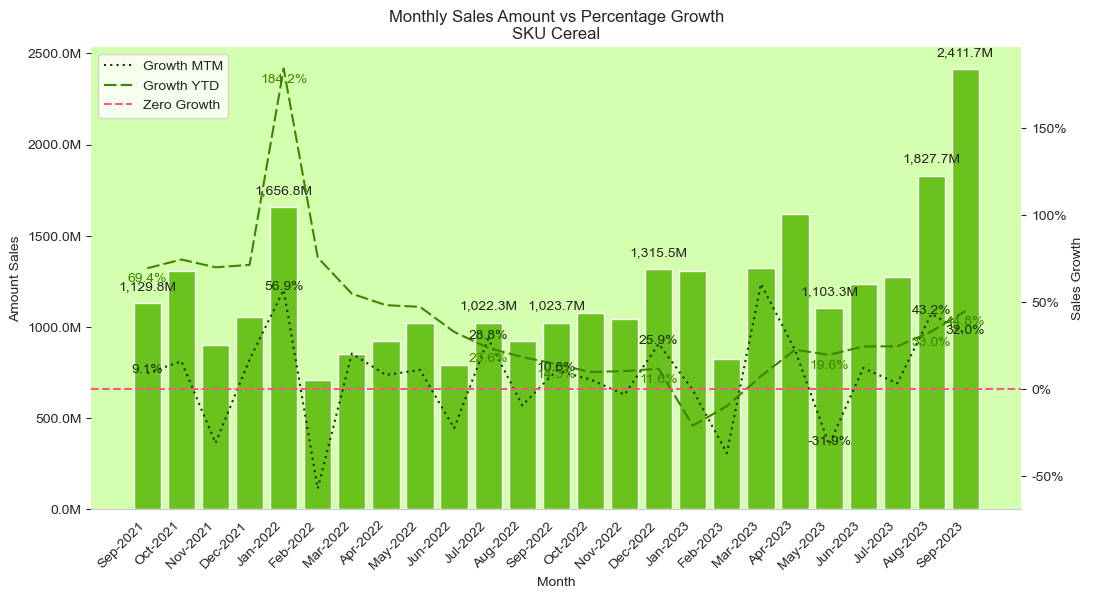

In [94]:
# monthly GMV for SKU Cereal
chart_monthly_amount_by_condition(
    df=df_sales,
    bar_color='#67DF00',
    line_1_color='#3D8400',
    line_2_color='#163000',
    background_color='#D4FFAE',
    col_condition='main_sku',
    condition='Cereal')

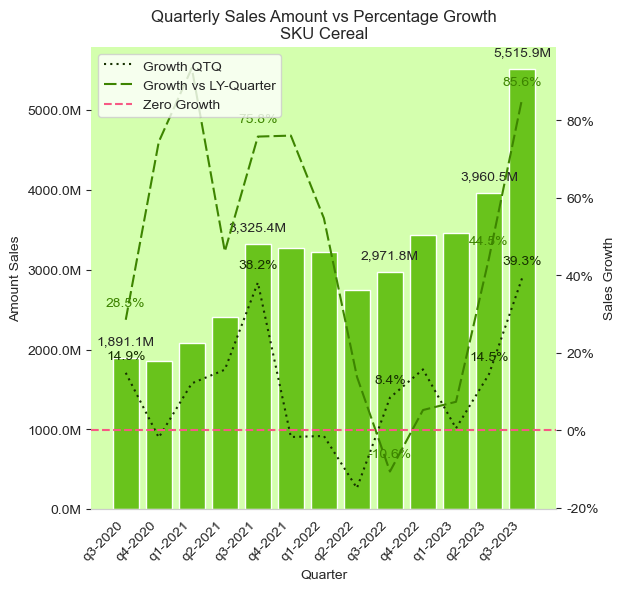

In [95]:
# monthly GMV for SKU Cereal
chart_quarterly_amount_by_condition(
    df=df_sales,
    bar_color='#67DF00',
    line_1_color='#3D8400',
    line_2_color='#163000',
    background_color='#D4FFAE',
    col_condition='main_sku',
    condition='Cereal')

#### Sales Performance SKU Coffee

In [96]:
sku

array(['Tea', 'Chocolate', 'other', 'Cereal', 'Coffee', 'Rice',
       'Body Care', 'Ointment', 'Beauty Care'], dtype=object)

In [97]:
df_coffee_monthly = dataset_monthly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Coffee')
df_coffee_monthly

index barcode_date       amount month  year month_year    amount_ytd  \
0      43   2021-09-30 16,206,750.0   Sep  2021   Sep-2021 150,549,000.0   
1      44   2021-10-31  6,487,950.0   Oct  2021   Oct-2021 157,036,950.0   
2      45   2021-11-30  1,125,250.0   Nov  2021   Nov-2021 158,162,200.0   
3      46   2021-12-31    127,750.0   Dec  2021   Dec-2021 158,289,950.0   
4      47   2022-01-31  5,932,500.0   Jan  2022   Jan-2022   5,932,500.0   
5      48   2022-02-28  4,306,750.0   Feb  2022   Feb-2022  10,239,250.0   
6      49   2022-03-31    859,250.0   Mar  2022   Mar-2022  11,098,500.0   
7      50   2022-04-30 17,628,625.0   Apr  2022   Apr-2022  28,727,125.0   
8      51   2022-05-31 25,056,587.5   May  2022   May-2022  53,783,712.5   
9      52   2022-06-30  7,958,125.0   Jun  2022   Jun-2022  61,741,837.5   
10     53   2022-07-31 13,741,875.0   Jul  2022   Jul-2022  75,483,712.5   
11     54   2022-08-31 13,734,000.0   Aug  2022   Aug-2022  89,217,712.5   
12     55   2022-09-30 20,265,192.5   Sep  2022   Sep-2022 109,482,905.0   
13     56   2022-10-31 19,612,442.5   Oct  2022   Oct-2022 129,095,347.5   
14     57   2022-11-30 12,824,875.0   Nov  2022   Nov-2022 141,920,222.5   
15     58   2022-12-31 20,311,637.5   Dec  2022   Dec-2022 162,231,860.0   
16     59   2023-01-31 27,407,327.5   Jan  2023   Jan-2023  27,407,327.5   
17     60   2023-02-28  9,602,250.0   Feb  2023   Feb-2023  37,009,577.5   
18     61   2023-03-31 13,849,500.0   Mar  2023   Mar-2023  50,859,077.5   
19     62   2023-04-30  9,014,250.0   Apr  2023   Apr-2023  59,873,327.5   
20     63   2023-05-31 10,216,885.0   May  2023   May-2023  70,090,212.5   
21     64   2023-06-30 10,342,885.0   Jun  2023   Jun-2023  80,433,097.5   
22     65   2023-07-31  7,853,125.0   Jul  2023   Jul-2023  88,286,222.5   
23     66   2023-08-31 12,207,510.0   Aug  2023   Aug-2023 100,493,732.5   
24     67   2023-09-30 22,555,452.5   Sep  2023   Sep-2023 123,049,185.0   

    amount_percent_growth_mtm  amount_percent_growth_ytd  
0                       -12.7                      -27.1  
1                       -60.0                      -32.0  
2                       -82.7                      -35.5  
3                       -88.6                      -39.3  
4                     4,543.8                      -60.8  
5                       -27.4                      -60.1  
6                       -80.0                      -78.9  
7                     1,951.6                      -63.1  
8                        42.1                      -41.8  
9                       -68.2                      -40.6  
10                       72.7                      -34.8  
11                       -0.1                      -33.6  
12                       47.6                      -27.3  
13                       -3.2                      -17.8  
14                      -34.6                      -10.3  
15                       58.4                        2.5  
16                       34.9                      362.0  
17                      -65.0                      261.4  
18                       44.2                      358.3  
19                      -34.9                      108.4  
20                       13.3                       30.3  
21                        1.2                       30.3  
22                      -24.1                       17.0  
23                       55.4                       12.6  
24                       84.8                       12.4

In [98]:
df_coffee_quarterly = dataset_quarterly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Coffee')
df_coffee_quarterly

index barcode_date       amount quarter  year quarter_year  \
0      10   2020-09-30 59,043,250.0      q3  2020      q3-2020   
1      11   2020-12-31 54,311,250.0      q4  2020      q4-2020   
2      12   2021-03-31 52,505,250.0      q1  2021      q1-2021   
3      13   2021-06-30 51,394,000.0      q2  2021      q2-2021   
4      14   2021-09-30 46,649,750.0      q3  2021      q3-2021   
5      15   2021-12-31  7,740,950.0      q4  2021      q4-2021   
6      16   2022-03-31 11,098,500.0      q1  2022      q1-2022   
7      17   2022-06-30 50,643,337.5      q2  2022      q2-2022   
8      18   2022-09-30 47,741,067.5      q3  2022      q3-2022   
9      19   2022-12-31 52,748,955.0      q4  2022      q4-2022   
10     20   2023-03-31 50,859,077.5      q1  2023      q1-2023   
11     21   2023-06-30 29,574,020.0      q2  2023      q2-2023   
12     22   2023-09-30 42,616,087.5      q3  2023      q3-2023   

    amount_percent_growth_qtq  amount_percent_growth_lyq  
0                       -22.5                       -6.8  
1                        -8.0                        1.1  
2                        -3.3                      -26.5  
3                        -2.1                      -32.5  
4                        -9.2                      -21.0  
5                       -83.4                      -85.7  
6                        43.4                      -78.9  
7                       356.3                       -1.5  
8                        -5.7                        2.3  
9                        10.5                      581.4  
10                       -3.6                      358.3  
11                      -41.9                      -41.6  
12                       44.1                      -10.7

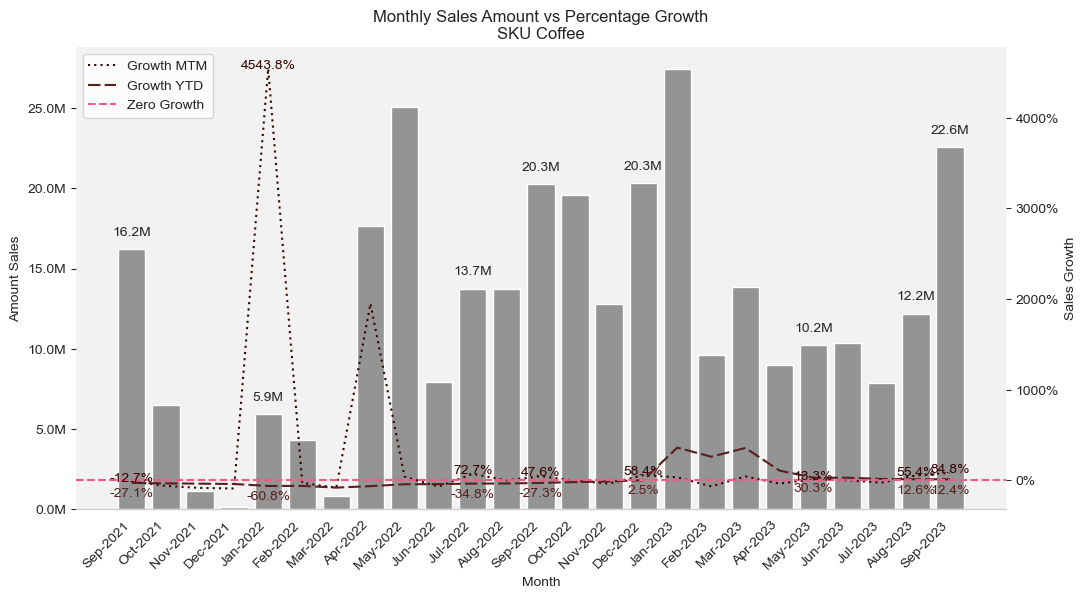

In [99]:
# monthly GMV for SKU Coffee
chart_monthly_amount_by_condition(
    df=df_sales,
    bar_color='#949494',
    line_1_color='#571F1F',
    line_2_color='#340000',
    background_color='#F2F2F2',
    col_condition='main_sku',
    condition='Coffee')

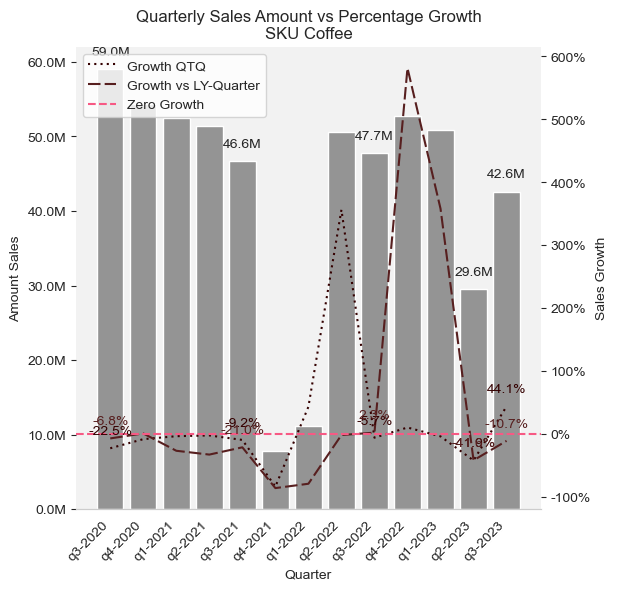

In [100]:
# Quarterly GMV for SKU Coffee
chart_quarterly_amount_by_condition(
    df=df_sales,
    bar_color='#949494',
    line_1_color='#571F1F',
    line_2_color='#340000',
    background_color='#F2F2F2',
    col_condition='main_sku',
    condition='Coffee')

In [101]:
sku

array(['Tea', 'Chocolate', 'other', 'Cereal', 'Coffee', 'Rice',
       'Body Care', 'Ointment', 'Beauty Care'], dtype=object)

#### Sales Performance SKU Rice

In [102]:
df_rice_monthly = dataset_monthly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Rice')
df_rice_monthly

index barcode_date        amount month  year month_year      amount_ytd  \
0      12   2021-09-30   8,384,687.5   Sep  2021   Sep-2021   115,328,062.5   
1      13   2021-10-31  11,845,312.5   Oct  2021   Oct-2021   127,173,375.0   
2      14   2021-11-30   9,673,125.0   Nov  2021   Nov-2021   136,846,500.0   
3      15   2021-12-31  27,636,875.0   Dec  2021   Dec-2021   164,483,375.0   
4      16   2022-01-31  41,542,812.5   Jan  2022   Jan-2022    41,542,812.5   
5      17   2022-02-28  26,687,937.5   Feb  2022   Feb-2022    68,230,750.0   
6      18   2022-03-31  28,925,750.0   Mar  2022   Mar-2022    97,156,500.0   
7      19   2022-04-30  44,920,750.0   Apr  2022   Apr-2022   142,077,250.0   
8      20   2022-05-31  58,887,500.0   May  2022   May-2022   200,964,750.0   
9      21   2022-06-30  48,993,000.0   Jun  2022   Jun-2022   249,957,750.0   
10     22   2022-07-31  77,610,750.0   Jul  2022   Jul-2022   327,568,500.0   
11     23   2022-08-31  45,358,250.0   Aug  2022   Aug-2022   372,926,750.0   
12     24   2022-09-30 101,696,000.0   Sep  2022   Sep-2022   474,622,750.0   
13     25   2022-10-31  66,211,250.0   Oct  2022   Oct-2022   540,834,000.0   
14     26   2022-11-30  66,218,250.0   Nov  2022   Nov-2022   607,052,250.0   
15     27   2022-12-31  86,700,250.0   Dec  2022   Dec-2022   693,752,500.0   
16     28   2023-01-31 120,377,250.0   Jan  2023   Jan-2023   120,377,250.0   
17     29   2023-02-28 112,344,750.0   Feb  2023   Feb-2023   232,722,000.0   
18     30   2023-03-31 106,235,500.0   Mar  2023   Mar-2023   338,957,500.0   
19     31   2023-04-30 105,504,000.0   Apr  2023   Apr-2023   444,461,500.0   
20     32   2023-05-31  69,984,250.0   May  2023   May-2023   514,445,750.0   
21     33   2023-06-30  91,677,250.0   Jun  2023   Jun-2023   606,123,000.0   
22     34   2023-07-31 131,356,750.0   Jul  2023   Jul-2023   737,479,750.0   
23     35   2023-08-31 250,908,000.0   Aug  2023   Aug-2023   988,387,750.0   
24     36   2023-09-30 236,766,250.0   Sep  2023   Sep-2023 1,225,154,000.0   

    amount_percent_growth_mtm  amount_percent_growth_ytd  
0                       -32.5                      318.1  
1                        41.3                      147.4  
2                       -18.3                      120.5  
3                       185.7                      101.7  
4                        50.3                      285.1  
5                       -35.8                      225.3  
6                         8.4                      211.9  
7                        55.3                      216.5  
8                        31.1                      235.9  
9                       -16.8                      223.3  
10                       58.4                      246.5  
11                      -41.6                      248.7  
12                      124.2                      311.5  
13                      -34.9                      325.3  
14                        0.0                      343.6  
15                       30.9                      321.8  
16                       38.8                      189.8  
17                       -6.7                      241.1  
18                       -5.4                      248.9  
19                       -0.7                      212.8  
20                      -33.7                      156.0  
21                       31.0                      142.5  
22                       43.3                      125.1  
23                       91.0                      165.0  
24                       -5.6                      158.1

In [103]:
df_rice_quarterly = dataset_quarterly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Rice')
df_rice_quarterly

index barcode_date        amount quarter  year quarter_year  \
0       0   2020-09-30  27,585,250.0      q3  2020      q3-2020   
1       1   2020-12-31  53,973,500.0      q4  2020      q4-2020   
2       2   2021-03-31  31,149,562.5      q1  2021      q1-2021   
3       3   2021-06-30  46,156,250.0      q2  2021      q2-2021   
4       4   2021-09-30  38,022,250.0      q3  2021      q3-2021   
5       5   2021-12-31  49,155,312.5      q4  2021      q4-2021   
6       6   2022-03-31  97,156,500.0      q1  2022      q1-2022   
7       7   2022-06-30 152,801,250.0      q2  2022      q2-2022   
8       8   2022-09-30 224,665,000.0      q3  2022      q3-2022   
9       9   2022-12-31 219,129,750.0      q4  2022      q4-2022   
10     10   2023-03-31 338,957,500.0      q1  2023      q1-2023   
11     11   2023-06-30 267,165,500.0      q2  2023      q2-2023   
12     12   2023-09-30 619,031,000.0      q3  2023      q3-2023   

    amount_percent_growth_qtq  amount_percent_growth_lyq  
0                         0.0                        0.0  
1                        95.7                        0.0  
2                       -42.3                        0.0  
3                        48.2                        0.0  
4                       -17.6                       37.8  
5                        29.3                       -8.9  
6                        97.7                      211.9  
7                        57.3                      231.1  
8                        47.0                      490.9  
9                        -2.5                      345.8  
10                       54.7                      248.9  
11                      -21.2                       74.8  
12                      131.7                      175.5

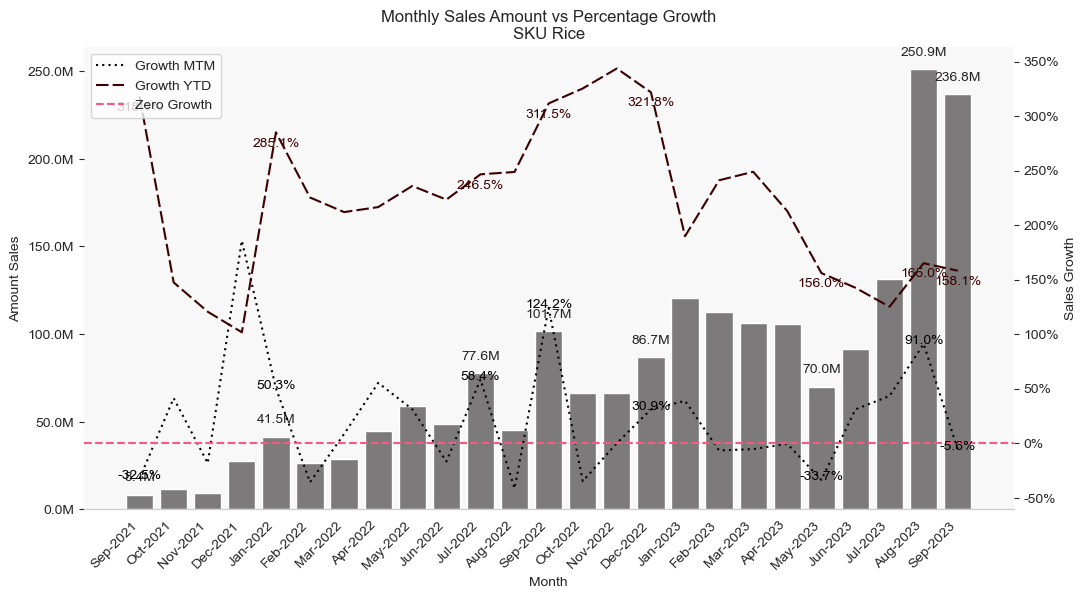

In [104]:
# Monthly GMV for SKU Rice
chart_monthly_amount_by_condition(
    df=df_sales,
    bar_color='#7D7979',
    line_1_color='#3B0000',
    line_2_color='#000000',
    background_color='#F8F8F8',
    col_condition='main_sku',
    condition='Rice')

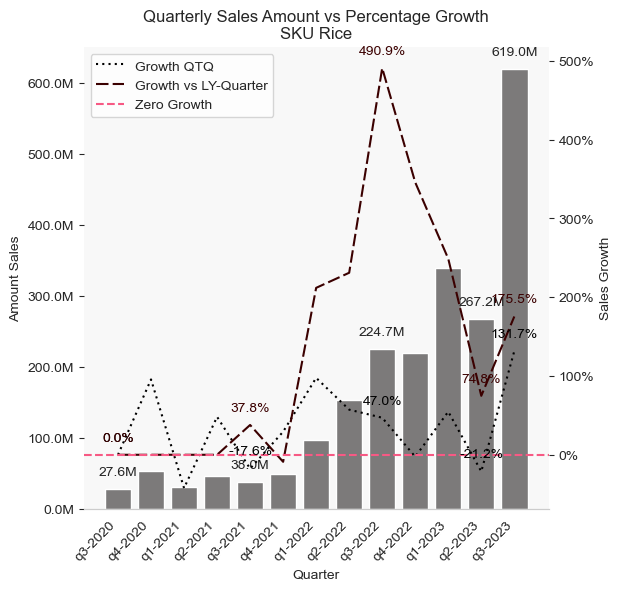

In [105]:
# Quarterly GMV for SKU Rice
chart_quarterly_amount_by_condition(
    df=df_sales,
    bar_color='#7D7979',
    line_1_color='#3B0000',
    line_2_color='#000000',
    background_color='#F8F8F8',
    col_condition='main_sku',
    condition='Rice')

In [106]:
sku

array(['Tea', 'Chocolate', 'other', 'Cereal', 'Coffee', 'Rice',
       'Body Care', 'Ointment', 'Beauty Care'], dtype=object)

#### Sales Performance SKU Body Care

In [107]:
df_bodycare_monthly = dataset_monthly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Body Care')
df_bodycare_monthly

index barcode_date       amount month  year month_year    amount_ytd  \
0       6   2021-09-30 14,218,750.0   Sep  2021   Sep-2021 223,081,250.0   
1       7   2021-10-31 15,624,000.0   Oct  2021   Oct-2021 238,705,250.0   
2       8   2021-11-30 17,032,750.0   Nov  2021   Nov-2021 255,738,000.0   
3       9   2021-12-31 12,766,250.0   Dec  2021   Dec-2021 268,504,250.0   
4      10   2022-01-31 29,207,500.0   Jan  2022   Jan-2022  29,207,500.0   
5      11   2022-02-28 12,228,125.0   Feb  2022   Feb-2022  41,435,625.0   
6      12   2022-03-31 12,636,750.0   Mar  2022   Mar-2022  54,072,375.0   
7      13   2022-04-30  7,658,000.0   Apr  2022   Apr-2022  61,730,375.0   
8      14   2022-05-31  7,678,125.0   May  2022   May-2022  69,408,500.0   
9      15   2022-06-30  9,856,000.0   Jun  2022   Jun-2022  79,264,500.0   
10     16   2022-07-31  7,592,375.0   Jul  2022   Jul-2022  86,856,875.0   
11     17   2022-08-31  8,291,500.0   Aug  2022   Aug-2022  95,148,375.0   
12     18   2022-09-30  7,804,125.0   Sep  2022   Sep-2022 102,952,500.0   
13     19   2022-10-31  7,883,347.5   Oct  2022   Oct-2022 110,835,847.5   
14     20   2022-11-30  6,822,375.0   Nov  2022   Nov-2022 117,658,222.5   
15     21   2022-12-31  8,788,885.0   Dec  2022   Dec-2022 126,447,107.5   
16     22   2023-01-31  7,454,702.5   Jan  2023   Jan-2023   7,454,702.5   
17     23   2023-02-28  7,113,452.5   Feb  2023   Feb-2023  14,568,155.0   
18     24   2023-03-31  8,294,107.5   Mar  2023   Mar-2023  22,862,262.5   
19     25   2023-04-30  5,566,750.0   Apr  2023   Apr-2023  28,429,012.5   
20     26   2023-05-31  9,974,300.0   May  2023   May-2023  38,403,312.5   
21     27   2023-06-30 68,661,250.0   Jun  2023   Jun-2023 107,064,562.5   
22     28   2023-07-31 66,066,000.0   Jul  2023   Jul-2023 173,130,562.5   
23     29   2023-08-31  7,000,770.0   Aug  2023   Aug-2023 180,131,332.5   
24     30   2023-09-30  8,473,885.0   Sep  2023   Sep-2023 188,605,217.5   

    amount_percent_growth_mtm  amount_percent_growth_ytd  
0                        48.1                        0.0  
1                         9.9                        0.0  
2                         9.0                        0.0  
3                       -25.0                        0.0  
4                       128.8                        0.0  
5                       -58.1                        0.0  
6                         3.3                      -18.4  
7                       -39.4                      -54.5  
8                         0.3                      -59.4  
9                        28.4                      -57.6  
10                      -23.0                      -56.4  
11                        9.2                      -54.4  
12                       -5.9                      -53.8  
13                        1.0                      -53.6  
14                      -13.5                      -54.0  
15                       28.8                      -52.9  
16                      -15.2                      -74.5  
17                       -4.6                      -64.8  
18                       16.6                      -57.7  
19                      -32.9                      -53.9  
20                       79.2                      -44.7  
21                      588.4                       35.1  
22                       -3.8                       99.3  
23                      -89.4                       89.3  
24                       21.0                       83.2

In [108]:
df_bodycare_quarterly = dataset_quarterly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Body Care')
df_bodycare_quarterly

index barcode_date        amount quarter  year quarter_year  \
0       0   2021-03-31  66,237,500.0      q1  2021      q1-2021   
1       1   2021-06-30 120,548,750.0      q2  2021      q2-2021   
2       2   2021-09-30  36,295,000.0      q3  2021      q3-2021   
3       3   2021-12-31  45,423,000.0      q4  2021      q4-2021   
4       4   2022-03-31  54,072,375.0      q1  2022      q1-2022   
5       5   2022-06-30  25,192,125.0      q2  2022      q2-2022   
6       6   2022-09-30  23,688,000.0      q3  2022      q3-2022   
7       7   2022-12-31  23,494,607.5      q4  2022      q4-2022   
8       8   2023-03-31  22,862,262.5      q1  2023      q1-2023   
9       9   2023-06-30  84,202,300.0      q2  2023      q2-2023   
10     10   2023-09-30  81,540,655.0      q3  2023      q3-2023   

    amount_percent_growth_qtq  amount_percent_growth_lyq  
0                         0.0                        0.0  
1                        82.0                        0.0  
2                       -69.9                        0.0  
3                        25.1                        0.0  
4                        19.0                      -18.4  
5                       -53.4                      -79.1  
6                        -6.0                      -34.7  
7                        -0.8                      -48.3  
8                        -2.7                      -57.7  
9                       268.3                      234.2  
10                       -3.2                      244.2

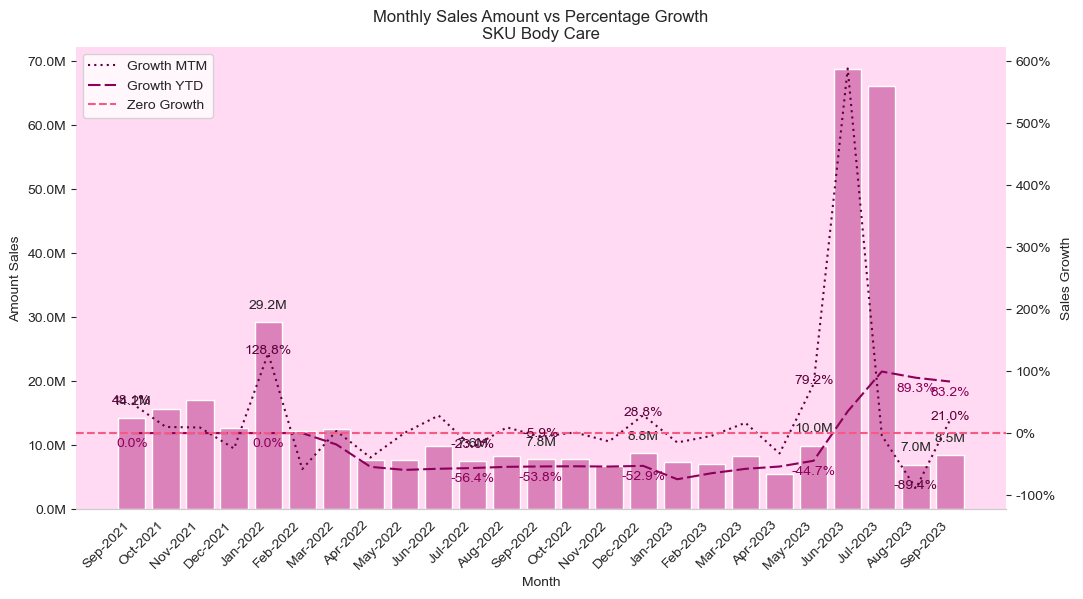

In [109]:
# Monthly GMV for SKU Body Care
chart_monthly_amount_by_condition(
    df=df_sales,
    bar_color='#EA73BF',
    line_1_color='#8B0058',
    line_2_color='#5D003B',
    background_color='#FFDAF2',
    col_condition='main_sku',
    condition='Body Care')

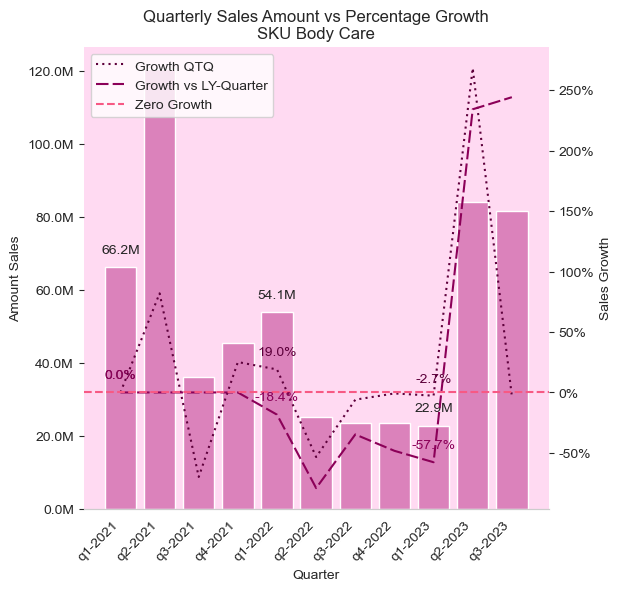

In [110]:
# Quarterly GMV for SKU Body Care
chart_quarterly_amount_by_condition(
    df=df_sales,
    bar_color='#EA73BF',
    line_1_color='#8B0058',
    line_2_color='#5D003B',
    background_color='#FFDAF2',
    col_condition='main_sku',
    condition='Body Care')

In [111]:
sku

array(['Tea', 'Chocolate', 'other', 'Cereal', 'Coffee', 'Rice',
       'Body Care', 'Ointment', 'Beauty Care'], dtype=object)

#### Sales Performance SKU Ointment

In [112]:
df_ointment_monthly = dataset_monthly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Ointment')
df_ointment_monthly

index barcode_date        amount month  year month_year  amount_ytd  \
0       0   2021-12-31  31,930,500.0   Dec  2021   Dec-2021    31930500   
1       1   2022-01-31  63,799,750.0   Jan  2022   Jan-2022    63799750   
2       2   2022-02-28  31,281,250.0   Feb  2022   Feb-2022    95081000   
3       3   2022-03-31  31,114,125.0   Mar  2022   Mar-2022   126195125   
4       4   2022-04-30  27,091,750.0   Apr  2022   Apr-2022   153286875   
5       5   2022-05-31  10,289,125.0   May  2022   May-2022   163576000   
6       6   2022-06-30  21,233,625.0   Jun  2022   Jun-2022   184809625   
7       7   2022-07-31  24,814,125.0   Jul  2022   Jul-2022   209623750   
8       8   2022-08-31  29,928,500.0   Aug  2022   Aug-2022   239552250   
9       9   2022-09-30  30,824,500.0   Sep  2022   Sep-2022   270376750   
10     10   2022-10-31  22,911,000.0   Oct  2022   Oct-2022   293287750   
11     11   2022-11-30  26,152,000.0   Nov  2022   Nov-2022   319439750   
12     12   2022-12-31  22,286,250.0   Dec  2022   Dec-2022   341726000   
13     13   2023-01-31  34,760,250.0   Jan  2023   Jan-2023    34760250   
14     14   2023-02-28  25,684,750.0   Feb  2023   Feb-2023    60445000   
15     15   2023-03-31  25,389,000.0   Mar  2023   Mar-2023    85834000   
16     16   2023-04-30  29,596,875.0   Apr  2023   Apr-2023   115430875   
17     17   2023-05-31  19,434,625.0   May  2023   May-2023   134865500   
18     18   2023-06-30  37,647,750.0   Jun  2023   Jun-2023   172513250   
19     19   2023-07-31  21,299,250.0   Jul  2023   Jul-2023   193812500   
20     20   2023-08-31 122,051,125.0   Aug  2023   Aug-2023   315863625   
21     21   2023-09-30  51,963,625.0   Sep  2023   Sep-2023   367827250   

    amount_percent_growth_mtm  amount_percent_growth_ytd  
0                         0.0                        0.0  
1                        99.8                        0.0  
2                       -51.0                        0.0  
3                        -0.5                        0.0  
4                       -12.9                        0.0  
5                       -62.0                        0.0  
6                       106.4                        0.0  
7                        16.9                        0.0  
8                        20.6                        0.0  
9                         3.0                        0.0  
10                      -25.7                        0.0  
11                       14.1                        0.0  
12                      -14.8                      970.2  
13                       56.0                      -45.5  
14                      -26.1                      -36.4  
15                       -1.2                      -32.0  
16                       16.6                      -24.7  
17                      -34.3                      -17.6  
18                       93.7                       -6.7  
19                      -43.4                       -7.5  
20                      473.0                       31.9  
21                      -57.4                       36.0

In [113]:
df_ointment_quarterly = dataset_quarterly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Ointment')
df_ointment_quarterly

index barcode_date        amount quarter  year quarter_year  \
0      0   2021-12-31  31,930,500.0      q4  2021      q4-2021   
1      1   2022-03-31 126,195,125.0      q1  2022      q1-2022   
2      2   2022-06-30  58,614,500.0      q2  2022      q2-2022   
3      3   2022-09-30  85,567,125.0      q3  2022      q3-2022   
4      4   2022-12-31  71,349,250.0      q4  2022      q4-2022   
5      5   2023-03-31  85,834,000.0      q1  2023      q1-2023   
6      6   2023-06-30  86,679,250.0      q2  2023      q2-2023   
7      7   2023-09-30 195,314,000.0      q3  2023      q3-2023   

   amount_percent_growth_qtq  amount_percent_growth_lyq  
0                        0.0                        0.0  
1                      295.2                        0.0  
2                      -53.6                        0.0  
3                       46.0                        0.0  
4                      -16.6                      123.5  
5                       20.3                      -32.0  
6                        1.0                       47.9  
7                      125.3                      128.3

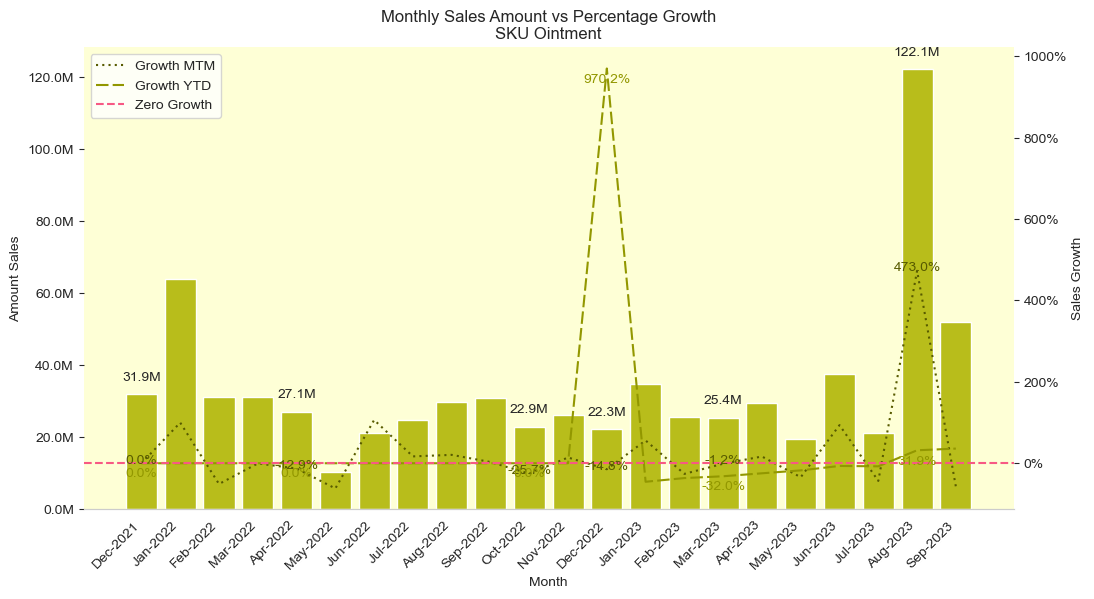

In [114]:
# Monthly GMV for SKU Ointment
chart_monthly_amount_by_condition(
    df=df_sales,
    bar_color='#D1D800',
    line_1_color='#929700',
    line_2_color='#585B00',
    background_color='#FEFFD6',
    col_condition='main_sku',
    condition='Ointment')

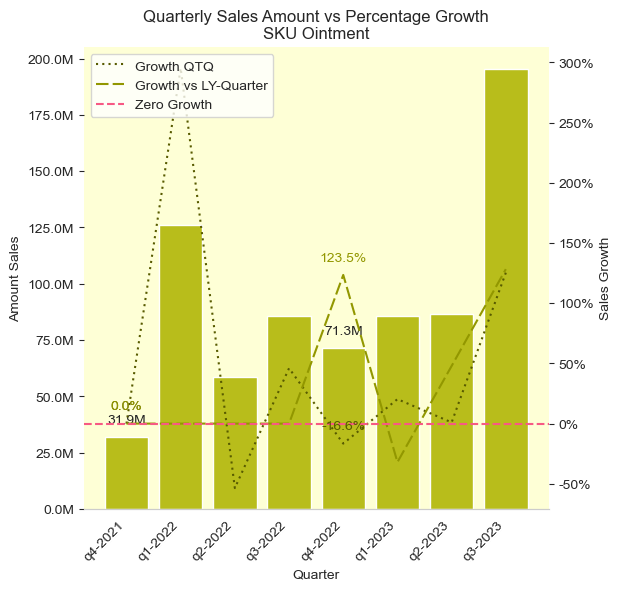

In [115]:
# Quarterly GMV for SKU Ointment
chart_quarterly_amount_by_condition(
    df=df_sales,
    bar_color='#D1D800',
    line_1_color='#929700',
    line_2_color='#585B00',
    background_color='#FEFFD6',
    col_condition='main_sku',
    condition='Ointment')

In [116]:
sku

array(['Tea', 'Chocolate', 'other', 'Cereal', 'Coffee', 'Rice',
       'Body Care', 'Ointment', 'Beauty Care'], dtype=object)

#### Sales Performance SKU Beauty Care

In [117]:
df_beautycare_monthly = dataset_monthly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Beauty Care')
df_beautycare_monthly

index barcode_date        amount month  year month_year    amount_ytd  \
0       0   2022-03-31 118,688,325.0   Mar  2022   Mar-2022 118,688,325.0   
1       1   2022-04-30  44,392,512.5   Apr  2022   Apr-2022 163,080,837.5   
2       2   2022-05-31  62,798,513.8   May  2022   May-2022 225,879,351.2   
3       3   2022-06-30  48,759,331.2   Jun  2022   Jun-2022 274,638,682.5   
4       4   2022-07-31  68,009,331.2   Jul  2022   Jul-2022 342,648,013.8   
5       5   2022-08-31  57,670,410.0   Aug  2022   Aug-2022 400,318,423.8   
6       6   2022-09-30  59,430,910.0   Sep  2022   Sep-2022 459,749,333.8   
7       7   2022-10-31  61,527,943.8   Oct  2022   Oct-2022 521,277,277.5   
8       8   2022-11-30  75,340,221.2   Nov  2022   Nov-2022 596,617,498.8   
9       9   2022-12-31  48,974,033.5   Dec  2022   Dec-2022 645,591,532.2   
10     10   2023-01-31  59,319,869.0   Jan  2023   Jan-2023  59,319,869.0   
11     11   2023-02-28  34,145,714.8   Feb  2023   Feb-2023  93,465,583.8   
12     12   2023-03-31  38,273,072.2   Mar  2023   Mar-2023 131,738,656.0   
13     13   2023-04-30  55,045,525.5   Apr  2023   Apr-2023 186,784,181.5   
14     14   2023-05-31  39,398,653.0   May  2023   May-2023 226,182,834.5   
15     15   2023-06-30 204,330,386.8   Jun  2023   Jun-2023 430,513,221.2   
16     16   2023-07-31 243,013,373.8   Jul  2023   Jul-2023 673,526,595.0   
17     17   2023-08-31  79,108,765.8   Aug  2023   Aug-2023 752,635,360.8   
18     18   2023-09-30  39,565,730.8   Sep  2023   Sep-2023 792,201,091.5   

    amount_percent_growth_mtm  amount_percent_growth_ytd  
0                         0.0                        0.0  
1                       -62.6                        0.0  
2                        41.5                        0.0  
3                       -22.4                        0.0  
4                        39.5                        0.0  
5                       -15.2                        0.0  
6                         3.1                        0.0  
7                         3.5                        0.0  
8                        22.4                        0.0  
9                       -35.0                        0.0  
10                       21.1                        0.0  
11                      -42.4                        0.0  
12                       12.1                       11.0  
13                       43.8                       14.5  
14                      -28.4                        0.1  
15                      418.6                       56.8  
16                       18.9                       96.6  
17                      -67.4                       88.0  
18                      -50.0                       72.3

In [118]:
df_beautycare_quarterly = dataset_quarterly_amount_by_condition(df=df_sales,col_condition='main_sku',condition='Beauty Care')
df_beautycare_quarterly

index barcode_date        amount quarter  year quarter_year  \
0      0   2022-03-31 118,688,325.0      q1  2022      q1-2022   
1      1   2022-06-30 155,950,357.5      q2  2022      q2-2022   
2      2   2022-09-30 185,110,651.2      q3  2022      q3-2022   
3      3   2022-12-31 185,842,198.5      q4  2022      q4-2022   
4      4   2023-03-31 131,738,656.0      q1  2023      q1-2023   
5      5   2023-06-30 298,774,565.2      q2  2023      q2-2023   
6      6   2023-09-30 361,687,870.2      q3  2023      q3-2023   

   amount_percent_growth_qtq  amount_percent_growth_lyq  
0                        0.0                        0.0  
1                       31.4                        0.0  
2                       18.7                        0.0  
3                        0.4                        0.0  
4                      -29.1                       11.0  
5                      126.8                       91.6  
6                       21.1                       95.4

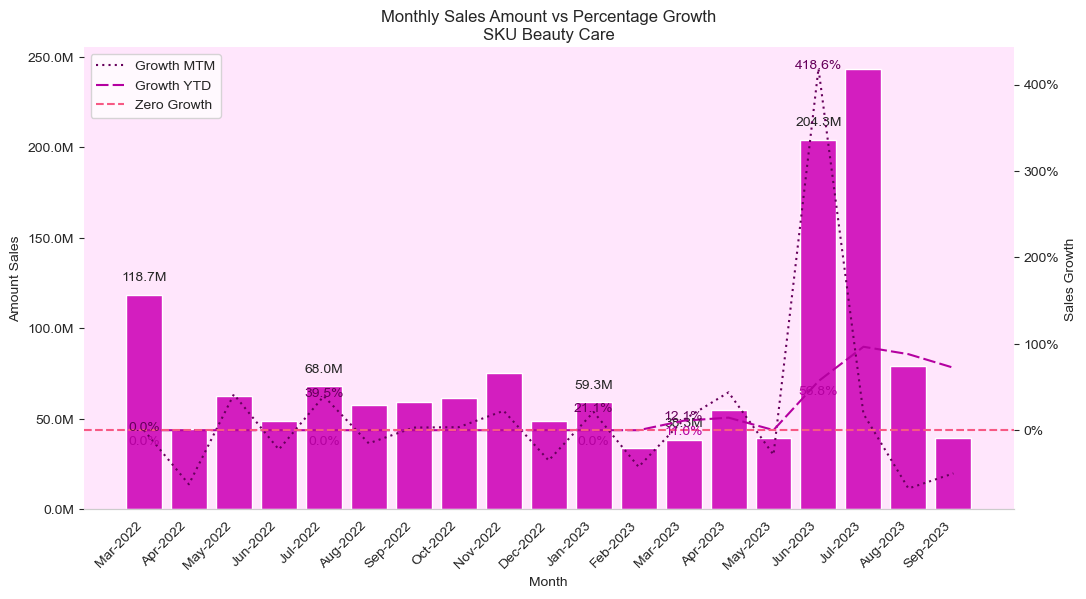

In [119]:
# Monthly GMV for SKU Beauty Care
chart_monthly_amount_by_condition(
    df=df_sales,
    bar_color='#F100D6',
    line_1_color='#B400A0',
    line_2_color='#66005B',
    background_color='#FFE6FC',
    col_condition='main_sku',
    condition='Beauty Care')

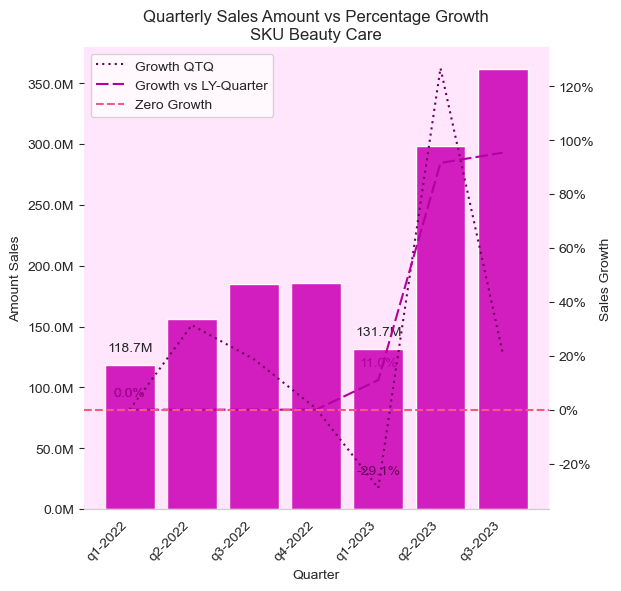

In [120]:
# Monthly GMV for SKU Beauty Care
chart_quarterly_amount_by_condition(
    df=df_sales,
    bar_color='#F100D6',
    line_1_color='#B400A0',
    line_2_color='#66005B',
    background_color='#FFE6FC',
    col_condition='main_sku',
    condition='Beauty Care')

#### 5. Evaluation of Sales Agent Status
Evaluate the sales agent status based on business relationship in the last 2 years

In [121]:
df_sales.head(3)

invoice sales_id sales_agent        level distibutor agent reseller  \
0   K1925      116      Anna R     Reseller       HAYA  KRIS      NaN   
1   K1926      121      M Herm  Distributor        NaN   NaN      NaN   
2   K1927       63      HERI S        Agent       HAYA   NaN      NaN   

  customer_email customer_hp cutomer_name barcode_date  subdistrict  district  \
0            NaN         NaN          NaN   2018-02-02      Rungkut  Surabaya   
1            NaN         NaN          NaN   2018-02-02  Balongbendo  Sidoarjo   
2            NaN         NaN          NaN   2018-02-02  Balongbendo  Sidoarjo   

     province          product  box  pack    amount   buyer_type  quantity  \
0  Jawa Timur  ALGATEA REGULER    2     0 358,750.0  sales agent       2.0   
1  Jawa Timur  ALGATEA REGULER    2     0 315,000.0  sales agent       2.0   
2  Jawa Timur               AK    2     0 332,500.0  sales agent       2.0   

    brand   main_sku  month  year month_year  
0  health        Tea      2  2018    2018-02  
1  health        Tea      2  2018    2018-02  
2  health  Chocolate      2  2018    2018-02

## DBSCAN Clustering
#### Unsupervised Machine Learning Method DBSCAN : Density-Based Spatial Clustering of Applications with Noise
- Diagnose whether there is a false leveling of sales agent due to their purchase behavior as business partner
- Due to we have 5 level sales agent, it should be that we have 5 cluster based on purchase behavior, but we assumed that some sales agent didn't perform a business performance as their contract with company

In [122]:
# Define dataframe for evaluation process (3 years performance)
df_sales_3years = df_sales[df_sales['year'] > 2020]
#check
df_sales_3years.tail()

invoice sales_id sales_agent      level distibutor agent reseller  \
67932  t12403     1972      Sudars   Retailer       RONG   NaN     Mudz   
67933  t12404     1902      DR. ED   Reseller       HAYA   NaN      NaN   
67934  t12404     1902      DR. ED   Reseller       HAYA   NaN      NaN   
67935  t12406      928      Tokar    Retailer       HAYA   NaN      NaN   
67936    2045       76      PT. OR  Principal        NaN   NaN      NaN   

                         customer_email customer_hp  cutomer_name  \
67932            darso1979.ss@gmail.com    6.28E+12     Sudarsono   
67933          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67934          konsumendr.edy@gmail.com    6.29E+12  Sri Wijayati   
67935  Konsumentokarindonesia@gmail.com    6.28E+12    Ibu Swanny   
67936                               NaN         NaN           NaN   

      barcode_date  subdistrict            district     province  \
67932   2023-09-30      Rembang  Kabupaten Pasuruan   Jawa Timur   
67933   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67934   2023-09-30     Sidorejo       Kota Salatiga  Jawa Tengah   
67935   2023-09-30  Kediri Kota         Kota Kediri   Jawa Timur   
67936   2023-09-30      Buduran            Sidoarjo   Jawa Timur   

                 product  box  pack       amount   buyer_type  quantity  \
67932    FLOSSOM ROSELLA    0     2     71,750.0     end user       0.5   
67933       BERAS KARNUS    0     2     91,000.0     end user       0.5   
67934   STARTERPACK AGAT    2     0    547,750.0     end user       2.0   
67935           GoodMove    0     4    577,500.0     end user       1.0   
67936  Otulgro 10 sachet    0  1152 40,320,000.0  sales agent     288.0   

        brand  main_sku  month  year month_year  
67932   other     other      9  2023    2023-09  
67933   other      Rice      9  2023    2023-09  
67934  health    Cereal      9  2023    2023-09  
67935   other  Ointment      9  2023    2023-09  
67936   other     other      9  2023    2023-09

In [123]:
df_salesid_month_year = df_sales_3years.groupby(['sales_id','month','year','month_year'])['amount','quantity'].sum().sort_values(by=['sales_id','year','month'],ascending=True).reset_index()
df_salesid_month_year

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1008\4148114719.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_salesid_month_year = df_sales_3years.groupby(['sales_id','month','year','month_year'])['amount','quantity'].sum().sort_values(by=['sales_id','year','month'],ascending=True).reset_index()


sales_id  month  year month_year      amount  quantity
0           1      1  2021    2021-01 1,292,812.5       6.5
1           1      2  2021    2021-02 3,535,000.0      14.5
2           1      3  2021    2021-03 2,572,500.0      10.5
3           1      4  2021    2021-04 2,406,250.0      10.0
4           1      5  2021    2021-05 5,068,000.0      21.0
...       ...    ...   ...        ...         ...       ...
9610      996      3  2022    2022-03 4,725,875.0      22.0
9611      996      4  2022    2022-04 2,148,125.0      10.0
9612      996      5  2022    2022-05 2,148,125.0      10.0
9613      996      7  2022    2022-07 1,718,500.0       8.0
9614      997      3  2021    2021-03   962,500.0       4.0

[9615 rows x 6 columns]

In [124]:
df_pivot_amount = df_salesid_month_year.pivot(index='sales_id', columns=['month_year'], values='amount').fillna(0)
average_sales_amount = df_pivot_amount.mean(axis=1)
average_sales_amount

sales_id
1       4,423,968.2
10     14,968,587.3
1000      268,333.3
1002       43,803.0
1003       48,814.4
           ...     
969       624,590.9
976       142,704.5
98      1,925,229.1
996     1,657,859.8
997        29,166.7
Length: 1318, dtype: float64

In [125]:
df_pivot_quantity = df_salesid_month_year.pivot(index='sales_id', columns=['year','month'], values='quantity').fillna(0)
average_sales_quantity = df_pivot_quantity.mean(axis=1)
average_sales_quantity

sales_id
1       20.3
10     104.2
1000     1.4
1002     0.2
1003     0.3
        ... 
969      2.6
976      0.7
98       9.8
996      8.4
997      0.1
Length: 1318, dtype: float64

In [126]:
# DataFrame for Cluster Analysis
df_business_behavior = df_sales_3years[['sales_id','sales_agent','level']].drop_duplicates(subset='sales_id',keep='first').sort_values(by='sales_id').set_index(['sales_id'])
df_business_behavior['average_sales_amount'] = average_sales_amount
df_business_behavior['average_sales_quantity'] = average_sales_quantity
df_business_behavior = df_business_behavior.reset_index()
df_business_behavior.head()

sales_id sales_agent      level  average_sales_amount  \
0        1       Hendy  Principal           4,423,968.2   
1       10      Muhamm  Principal          14,968,587.3   
2     1000      HILMAN   Retailer             268,333.3   
3     1002      ERRIS    Retailer              43,803.0   
4     1003      MOKHAM   Retailer              48,814.4   

   average_sales_quantity  
0                    20.3  
1                   104.2  
2                     1.4  
3                     0.2  
4                     0.3

### Exploration Data Analysis

In [127]:
number_sales_agent = df_business_behavior.groupby('level').size()
percent_sales_agent = 100*number_sales_agent/len(df_business_behavior)
df_sales_agent_level = pd.DataFrame({'number_sales_agent':number_sales_agent,
                                     'percent_sales_agent':percent_sales_agent}).reset_index('level')
df_sales_agent_level.to_csv('composition level agency 3 years.csv')
df_sales_agent_level

level  number_sales_agent  percent_sales_agent
0        Agent                  60                  4.6
1  Distributor                  24                  1.8
2    Principal                  44                  3.3
3     Reseller                 102                  7.7
4     Retailer                1088                 82.5

In [128]:
number_sales_agent.sum()

1318

<Figure size 400x400 with 0 Axes>

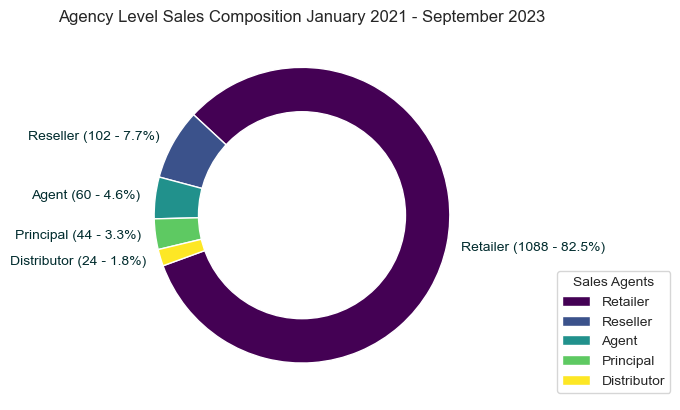

In [129]:
plt.figure(figsize=(4,4))
# Data
level_agents = df_business_behavior['level']
level_agent_counts = df_business_behavior['level'].value_counts()

# Set up donut chart
fig, ax = plt.subplots()
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
total_sales_agents = len(level_agents)
colors = plt.cm.viridis(np.linspace(0, 1, len(level_agent_counts)))
labels = [f'{agent} ({count} - {count/total_sales_agents*100:.1f}%)' for agent, count in level_agent_counts.items()]

# Donut chart
wedges, texts, autotexts = ax.pie(level_agent_counts, labels=labels, autopct='',
                                  textprops=dict(color="#012C2E"),colors=colors,
                                  wedgeprops=dict(width=0.4),startangle=200)

center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

ax.legend(wedges, level_agent_counts.index, title='Sales Agents', loc="lower left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.savefig(f'composition level agency 3 years.png')
plt.title(f'Agency Level Sales Composition {df_sales_3years["barcode_date"].min().strftime("%B")} {df_sales_3years["barcode_date"].min().year} - {df_sales_3years["barcode_date"].max().strftime("%B")} {df_sales_3years["barcode_date"].max().year}')
plt.show()

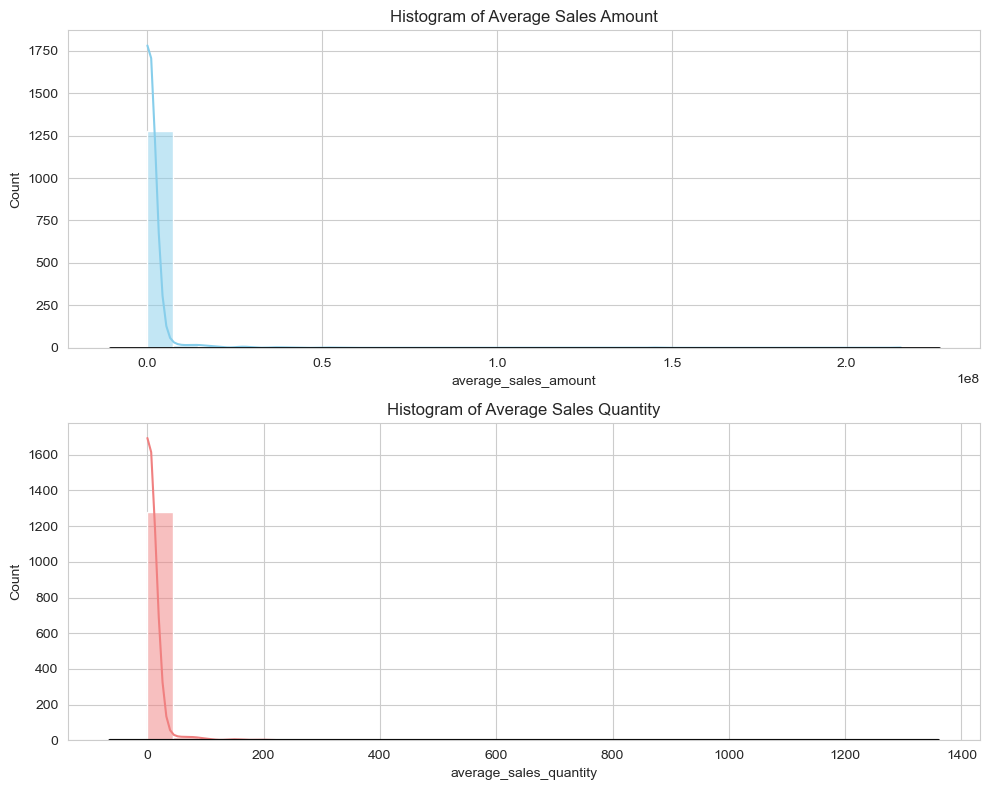

In [130]:
from scipy.stats import norm

avg_amount_monthly = df_business_behavior['average_sales_amount']
avg_qty_monthly = df_business_behavior['average_sales_quantity']

# Set up the figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot histograms
sns.histplot(avg_amount_monthly, bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Histogram of Average Sales Amount')

sns.histplot(avg_qty_monthly, bins=30, kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title('Histogram of Average Sales Quantity')

# Plot normal distribution curve
for ax, data in zip(axes, [avg_amount_monthly, avg_qty_monthly]):
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    mu, std = data.mean(), data.std()
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)

plt.tight_layout()
plt.savefig('Histogram Average Amount & Quantity Sales.png')
plt.show()

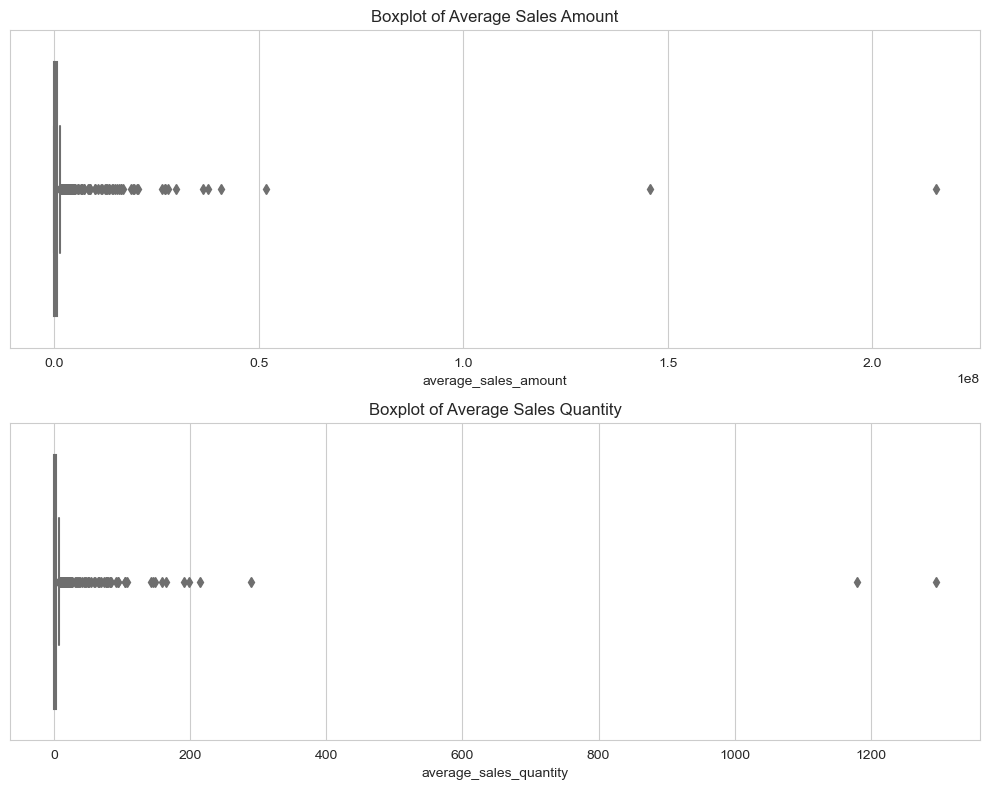

In [131]:
# Set up the figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Create boxplots
sns.boxplot(x=avg_amount_monthly, ax=axes[0], color='skyblue')
axes[0].set_title('Boxplot of Average Sales Amount')

sns.boxplot(x=avg_qty_monthly, ax=axes[1], color='lightcoral')
axes[1].set_title('Boxplot of Average Sales Quantity')

plt.tight_layout()
plt.savefig('Boxplot Average Amount & Quantity Sales.png')
plt.show()

####  DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

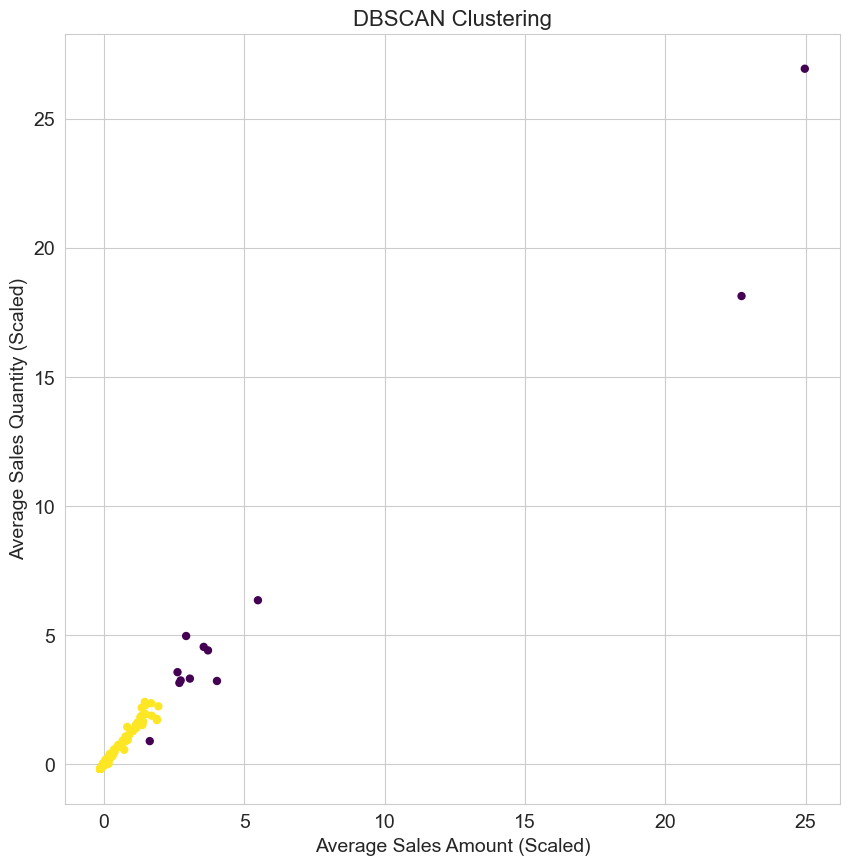

In [132]:
# Feature Engineering in Clustering ('average_sales_amount' dan 'average_sales_quantity')
selected_features = ['average_sales_amount', 'average_sales_quantity']
X = df_business_behavior[selected_features]
# Normalized the Feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Develope DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# assign new label
df_business_behavior['cluster_label'] = labels

# Visualize the clustering result
plt.figure(figsize=(10,10))
plt.scatter(X_scaled[:, 1], X_scaled[:, 0], c=labels, cmap='viridis', s=25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('DBSCAN Clustering', fontsize=16)
plt.xlabel('Average Sales Amount (Scaled)', fontsize=14)
plt.ylabel('Average Sales Quantity (Scaled)', fontsize=14)
plt.savefig(f'DBSCAN Clustering {df_sales["barcode_date"].max().strftime("%B")}_{df_sales["barcode_date"].dt.year.max()}.png')
plt.show()

In [133]:
# cek new DataFrame Purchase Behavior with clustering label
df_business_behavior.to_excel('dbscan_clustering_sales_agent.xlsx')
df_business_behavior

sales_id sales_agent      level  average_sales_amount  \
0           1       Hendy  Principal           4,423,968.2   
1          10      Muhamm  Principal          14,968,587.3   
2        1000      HILMAN   Retailer             268,333.3   
3        1002      ERRIS    Retailer              43,803.0   
4        1003      MOKHAM   Retailer              48,814.4   
...       ...         ...        ...                   ...   
1313      969      Raden    Retailer             624,590.9   
1314      976      Arif R   Retailer             142,704.5   
1315       98      IR.EFF   Reseller           1,925,229.1   
1316      996      DACHIL   Retailer           1,657,859.8   
1317      997      IVIK Y   Retailer              29,166.7   

      average_sales_quantity  cluster_label  
0                       20.3              0  
1                      104.2              0  
2                        1.4              0  
3                        0.2              0  
4                        0.3              0  
...                      ...            ...  
1313                     2.6              0  
1314                     0.7              0  
1315                     9.8              0  
1316                     8.4              0  
1317                     0.1              0  

[1318 rows x 6 columns]

In [134]:
# check the cluster label
df_business_behavior['cluster_label'].unique()

array([ 0, -1], dtype=int64)

In [135]:
# check business performance each cluster
df_business_behavior.groupby(['cluster_label'])[['average_sales_amount','average_sales_quantity']].describe().T

cluster_label                           -1            0
average_sales_amount   count          12.0      1,306.0
                       mean   56,190,544.9    823,212.3
                       std    60,837,683.4  2,176,658.2
                       min     8,508,192.4      1,590.9
                       25%    27,139,133.8     69,781.2
                       50%    33,078,133.0    191,333.3
                       75%    43,611,839.9    622,769.3
                       max   215,499,925.2 20,562,741.3
average_sales_quantity count          12.0      1,306.0
                       mean          351.5          4.1
                       std           417.5         11.0
                       min            91.1          0.0
                       25%           147.3          0.4
                       50%           177.6          1.0
                       75%           233.5          3.1
                       max         1,295.8        106.9

due to **purchase behavior** there is only **one cluster** and **noise** *group* (noise means they dont have cluster).
- all of our sales agents whether they have different level are have similar purchase behavior. so it means leveling are not working properly.
- noise group made sophisticated business performance whereas they come from not only highest level, but also low level such as Reseller and Retailer
- Sales Agent in noise group deserve to be leveled up, and other agents in _one group_ need to be considered for lowering the level

In [136]:
# check Sales Agent in Noise Data
noise_data = df_business_behavior[df_business_behavior['cluster_label'] == -1]
print("Noise Data:")
noise_data

Noise Data:


sales_id sales_agent        level  average_sales_amount  \
28       1070      RUDI H     Retailer          29,726,823.6   
609      1925      Bamban     Reseller          37,512,259.7   
709      2029      SUNARY        Agent          26,419,787.7   
766        21      MAJAPA  Distributor         215,499,925.2   
916       225      TARDIY  Distributor          27,749,237.2   
965        23      Ragil         Agent          51,873,064.2   
1035      271      AFIF F        Agent          27,180,991.8   
1049       32        asad    Principal          27,013,559.7   
1075       40      SUSY'A     Retailer         145,515,156.8   
1226       76      MEILIN     Retailer           8,508,192.4   
1246       81      Pondok    Principal          36,429,442.4   
1298      928      Tokar      Retailer          40,858,098.5   

      average_sales_quantity  cluster_label  
28                     142.1             -1  
609                    190.3             -1  
709                    145.5             -1  
766                  1,295.8             -1  
916                    164.9             -1  
965                    290.0             -1  
1035                   147.9             -1  
1049                   214.7             -1  
1075                 1,179.4             -1  
1226                    91.1             -1  
1246                   198.2             -1  
1298                   157.9             -1

In [137]:
noise_data.to_csv('noise data.csv')

## SUMMARY
1. Sept 2023 we achieve
- **GMV** Rp.3.77B
- 20,410 **pcs sold**
- 287 **Sales Agent active**
- 855 **orders (invoices)**
- **AOV** 4.4M
- **ARPU** 13.1M
2. **Top 3 most popular products** are Cereal sold Rp2.4B, Tea Rp680.7M, Rice Rp236.8M
3. **Sales Agent loyalty was not maintained well**, in is indicated from RPR 61.7% agents repeat purchase and RR is around 30% above n+2 which means there were around 30% agent active after 2 months they were acquired
4. **in Sept we have anomaly growth ytd** which are very high in the last 2 months Aug-23 41.9% and Sep-23 52.2%, whereas every month this year we had a growth ytd around 20%, our search into some of Sales Agentsand and our Business Department found that there was a **PANIC BUYING ISSUES** from sales agents due to we had of raw material scarcity in next October 2023
5. Based on DSCAN clustering analysis, as we have 4 sales agents level (Distributor, Agent, Reseller, and Retailer), our **leveling agencys is not working properly**. those 4 level don't have significant differences of purchase behavior, or it means those 4 level have similar purchase behavior

### Suggestion
1. search another channel distribution (create new sales agent) due to most our sales agents are overstocked in following October
2. due to leveling is not working properly, evaluate the sales agent contract, rearrange the level based on their performance